# 这里是Model_Article的大致副本版本，主要是数据集经过了替换，并且补充试验细节： PFT→LandCover
（如果没有特殊说明，运行使用的默认环境为Project312）

## 1 反演模型部分

### 1.1 数据集的预处理


其整体运行流程如下：

1. **A1_process_GlobeLFMC**  
   初步根据信息处理原始表格数据；

2. **A2_process_GlobeLFMC_To_Grid**  
   将站点尺度数据转换为 **0.1° 空间分辨率的像元数据**，并同时保留不同植被类型的信息；

3. **rename_Lai_Mat**  
4. **reProcess_LC_Mat**  
5. **MCCA_VOD_Gaussian_Smoothing**
   上述两个脚本主要用于数据整理与处理，统一不同变量与文件的格式；处理出11日高斯窗口平滑的VOD副本

5. **A3_infilling_Variables_In_GridLFMC**  
   对网格化后的变量数据进行遥感数据的填充处理；

6. **后续模型求解**  
   在完成变量填充后，进一步计算并得到后续模型所需的变量结果。

通过以上步骤，最终获得 **0.1° 分辨率的数据表格**，并在此基础上开展后续数据处理与分析。



此外，**Python** 代码部分主要用于构建固定的训练集与验证集，其设计原则包括：

- **空间独立性**：  
  在所有 0.1° 像元中，部分像元仅用于训练，另一部分仅用于验证，避免空间信息泄露；

- **植被类型覆盖性**：  
  在 `IGBP_MainType` 维度上尽可能覆盖所有主要植被类型；

- **时间覆盖性**：  
  在时间维度上尽可能保证样本分布的完整性与代表性。

该流程为后续模型训练与评估提供了稳定且可靠的数据基础。


#### 1.1.1 先统计数据各个像元索引情况、Main IGBP情况以及月份情况

In [1]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

# -----------------------
# 1. 读取 Excel
# -----------------------
in_file = r"G:\data\VWCModelData\LFMC-gridMean-ML.xlsx"

df = pd.read_excel(in_file, engine="openpyxl")

required_cols = ["RowVOD", "ColVOD", "IGBP_MainType", "SamplingDate"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"缺少必要列: {c}")

# 确保日期是 datetime
df["SamplingDate"] = pd.to_datetime(df["SamplingDate"])
df["month"] = df["SamplingDate"].dt.month

# 生成像元ID（字符串方便操作）
df["pixel_id"] = df["RowVOD"].astype(str) + "_" + df["ColVOD"].astype(str)

# -----------------------
# 2. 统计像元数量 & 各类型像元数
# -----------------------

# 总像元数（RowVOD, ColVOD 的唯一组合）
unique_pixels = df[["RowVOD", "ColVOD"]].drop_duplicates()
n_pixels = len(unique_pixels)
print(f"不同像元总数: {n_pixels}")

# 按 (RowVOD, ColVOD, IGBP_MainType) 去重，统计每个类型的像元个数
pixel_type = df[["RowVOD", "ColVOD", "IGBP_MainType"]].drop_duplicates()
type_pixel_counts = pixel_type.groupby("IGBP_MainType").size().sort_values(ascending=False)
print("\n每个IGBP_MainType对应的像元数量：")
print(type_pixel_counts)

# 如果你只把“含植被类型”作为关注对象，可以在这里自行筛选，
# 比如排除水体/城市等（根据你自己IGBP_MainType的编码来写）。


# -----------------------
# 3. 构建像元级元数据：主类型 + 月份集合
# -----------------------

# 对每个像元汇总：
# - 主类型（取众数或第一个）
# - 该像元包含的月份集合
pixel_group = df.groupby("pixel_id")

def mode_or_first(series):
    # 简单取众数；若有多众数，取第一个
    counts = Counter(series.dropna())
    if not counts:
        return np.nan
    return counts.most_common(1)[0][0]

pixel_meta = pixel_group.agg({
    "RowVOD": "first",
    "ColVOD": "first",
    "IGBP_MainType": mode_or_first,
    "month": lambda x: sorted(x.dropna().unique())
}).reset_index()

print("\n像元级元信息示例：")
print(pixel_meta.head())

all_types = pixel_meta["IGBP_MainType"].dropna().unique()
print(f"\n共有 {len(all_types)} 种 IGBP_MainType：", all_types)

# -----------------------
# 4. 像元级别划分训练/验证
# -----------------------

max_train_ratio = 0.8
max_train_pixels = int(np.floor(max_train_ratio * n_pixels))

# 按类型把像元分组
type_to_pixels = {
    t: pixel_meta[pixel_meta["IGBP_MainType"] == t]["pixel_id"].tolist()
    for t in all_types
}

# 预先计算每个像元的月份集合（转换为 set）
pixel_months = {
    row["pixel_id"]: set(row["month"])
    for _, row in pixel_meta.iterrows()
}

# 辅助：按每个像元拥有的月份数排序（降序），便于选择“时间较完整”的像元
type_to_pixels_sorted = {}
for t, pix_list in type_to_pixels.items():
    pix_list_sorted = sorted(
        pix_list,
        key=lambda pid: len(pixel_months.get(pid, set())),
        reverse=True
    )
    type_to_pixels_sorted[t] = pix_list_sorted

train_pixels = set()

# ---- A. 先保证每个类型至少有一个像元进入训练集（优先选月份多的） ----
for t, pix_list_sorted in type_to_pixels_sorted.items():
    if not pix_list_sorted:
        continue
    chosen = pix_list_sorted[0]
    train_pixels.add(chosen)

print(f"\n初始为每种类型选了 1 个像元作为训练像元，共 {len(train_pixels)} 个。")

# 若初始已经超过 80%（极少发生），则直接裁剪
if len(train_pixels) > max_train_pixels:
    print("警告：仅保证类型覆盖时训练集像元已超过80%，将随机裁剪到80%。")
    train_pixels = set(list(train_pixels)[:max_train_pixels])

# ---- B. 尝试为每种类型补足 1-12 月覆盖（如果可能且不超80%） ----
target_months = set(range(1, 13))

for t in all_types:
    # 找出该类型当前在训练集中有哪些像元
    current_train_pids_of_type = [pid for pid in train_pixels if pid in type_to_pixels[t]]
    if not current_train_pids_of_type:
        # 理论上不会发生（A步已经保证至少1个）
        continue

    # 当前类型已经覆盖的月份
    covered_months = set()
    for pid in current_train_pids_of_type:
        covered_months |= pixel_months.get(pid, set())

    missing_months = target_months - covered_months
    if not missing_months:
        # 已经覆盖1-12月
        continue

    # 从该类型剩余像元中尝试补缺
    candidate_pixels = [pid for pid in type_to_pixels_sorted[t] if pid not in train_pixels]

    for pid in candidate_pixels:
        if len(train_pixels) >= max_train_pixels:
            print("训练像元数已达80%上限，停止补充月份覆盖。")
            break

        pix_months = pixel_months.get(pid, set())
        new_months = pix_months - covered_months
        if not new_months:
            # 这一个像元不带来新的月份信息，就不选
            continue

        # 选择这个像元
        train_pixels.add(pid)
        covered_months |= pix_months
        missing_months = target_months - covered_months

        if not missing_months:
            break  # 该类型已覆盖1-12月

print(f"\n最终选出的训练像元数量: {len(train_pixels)} / {n_pixels} "
      f"({len(train_pixels)/n_pixels*100:.2f}%)")

# -----------------------
# 5. 构造训练/验证 DataFrame，并检查条件
# -----------------------

# 为每个样本标记 train / val
df["is_train"] = df["pixel_id"].isin(train_pixels)
train_df = df[df["is_train"]].copy()
val_df   = df[~df["is_train"]].copy()

# (1) 空间独立性检查：像元集合是否有交集
train_pixel_ids = set(train_df["pixel_id"].unique())
val_pixel_ids   = set(val_df["pixel_id"].unique())
intersection = train_pixel_ids & val_pixel_ids
print("\n训练集与验证集像元交集大小:", len(intersection))

# (2) 训练集地物类型覆盖情况
train_types = train_df["IGBP_MainType"].dropna().unique()
print("训练集中包含的IGBP_MainType:", train_types)
print("是否覆盖所有类型:", set(train_types) >= set(all_types))

# (3) 各类型在训练集中的月份覆盖情况（简单表格）
print("\n各类型在训练集中的月份覆盖情况：")
for t in all_types:
    sub = train_df[train_df["IGBP_MainType"] == t]
    months_t = sorted(sub["month"].dropna().unique())
    print(f"  类型 {t}: 月份 {months_t}")

# 你可以根据需要保存 train_df / val_df 到新的文件，例如：
# train_df.to_csv(r"G:\data\VWCModelData\LFMC-gridMean-ML-train.csv", index=False)
# val_df.to_csv(r"G:\data\VWCModelData\LFMC-gridMean-ML-val.csv", index=False)


不同像元总数: 1301

每个IGBP_MainType对应的像元数量：
IGBP_MainType
GRA             718
WSA             243
SAV             183
ENF             147
OSH              61
CRO              45
NoVegetation     41
EBF              25
CSH              19
DBF              15
MF               14
dtype: int64

像元级元信息示例：
    pixel_id  RowVOD  ColVOD IGBP_MainType                       month
0  1056_3083    1056    3083           GRA      [4, 5, 6, 7, 8, 9, 12]
1  1071_3052    1071    3052           GRA         [4, 5, 6, 8, 9, 11]
2  1071_3053    1071    3053           GRA               [5, 6, 8, 11]
3  1072_3054    1072    3054           GRA         [4, 5, 6, 8, 9, 11]
4  1162_3016    1162    3016           OSH  [2, 4, 5, 6, 7, 8, 10, 11]

共有 11 种 IGBP_MainType： ['GRA' 'OSH' 'WSA' 'SAV' 'CRO' 'EBF' 'NoVegetation' 'ENF' 'MF' 'DBF' 'CSH']

初始为每种类型选了 1 个像元作为训练像元，共 11 个。

最终选出的训练像元数量: 11 / 1301 (0.85%)

训练集与验证集像元交集大小: 0
训练集中包含的IGBP_MainType: ['NoVegetation' 'ENF' 'WSA' 'GRA' 'MF' 'CSH' 'SAV' 'CRO' 'EBF' 'DBF' 'OSH']

##### 
根据上述结果，每个类型都存在至少1个涵盖所有月份的像元，所以时间上不需要过于担忧。
但是上面选取训练集的思路有问题，因为它找到涵盖所有月份的像元之后，就不再处理了。自/因变量均只保留小数点后6位

In [1]:
import pandas as pd
import numpy as np
import os

# -----------------------
# 1. 读取 Excel
# -----------------------
in_file = r"G:\data\VWCModelData\LFMC-gridMean-ML.xlsx"
df = pd.read_excel(in_file, engine="openpyxl")

# 基本必需列
base_required_cols = [
    "RowVOD", "ColVOD", "SamplingDate",
    "AGB", "LFMCValue", "NoVegetation"
]

# 自变量（特征）列
feature_cols = [
    "VOD_Ku_Hpol_Asc", "VOD_Ku_Vpol_Asc",
    "VOD_X_Hpol_Asc",  "VOD_X_Vpol_Asc",
    "VOD_C_Hpol_Asc",  "VOD_C_Vpol_Asc",
    "LAI", "Hveg",
    "Evergreen Needleleaf Forests (ENF)",
    "Evergreen Broadleaf Forests (EBF)",
    "Deciduous Needleleaf Forests (DNF)",
    "Deciduous Broadleaf Forests (DBF)",
    "Mixed_Forests (MF)",
    "Closed Shrublands (CSH)",
    "Open Shrublands (OSH)",
    "Woody Savannas (WSA)",
    "Savannas (SAV)",
    "Grasslands (GRA)",
    "Permanent Wetlands (WET)",
    "Croplands (CRO)",
    "Cropland or Natural Vegetation Mosaics (CVM)",
]

required_cols = base_required_cols + feature_cols
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"缺少必要列: {c}")
    
# 保存原始行索引，方便将来在原始表里定位
df["orig_index"] = df.index

# -----------------------
# 2. 日期与月份
# -----------------------
df["SamplingDate"] = pd.to_datetime(df["SamplingDate"])
df["month"] = df["SamplingDate"].dt.month

# 如果有月为 NaN 的（极少），直接丢掉
df = df[df["month"].notna()].copy()

# # -----------------------
# # 3. 过滤 NoVegetation < 0.05
# # -----------------------
# df = df[df["NoVegetation"] < 0.05].copy()

# print(f"过滤 NoVegetation<0.05 后剩余行数: {len(df)}")

# -----------------------
# 4. 计算因变量 y，并应用筛选条件
# -----------------------
# 因变量：AGB * LFMCValue / 1000.0
df["y"] = df["AGB"] * df["LFMCValue"] / 1000.0

# (1) y 非 NaN
mask_y_notna = df["y"].notna()

# (2) y 非负（最好大于0）且 <= 30
mask_y_nonneg = df["y"] > 0
mask_y_le_30 = df["y"] <= 30

# (3) 自变量非 NaN
mask_x_notna = df[feature_cols].notna().all(axis=1)

# (4) 自变量非负
mask_x_nonneg = (df[feature_cols] >= 0).all(axis=1)

mask_all = mask_y_notna & mask_y_nonneg & mask_y_le_30 & mask_x_notna & mask_x_nonneg

df = df[mask_all].copy()
print(f"应用自/因变量筛选后剩余行数: {len(df)}")

# 如果此时行数太少，你可以打印一下各条件的通过率来诊断

# -----------------------
# 5. 像元 ID & 按 IGBP_MainType 分层的像元级划分 (约 80% / 20%)
# -----------------------
df["pixel_id"] = df["RowVOD"].astype(int).astype(str) + "_" + df["ColVOD"].astype(int).astype(str)

# 先构建像元级元数据，确定每个像元的“主 IGBP_MainType”
def mode_or_first(s):
    s = s.dropna()
    if s.empty:
        return np.nan
    mode_vals = s.mode()
    if not mode_vals.empty:
        return mode_vals.iloc[0]
    return s.iloc[0]

pixel_meta = df.groupby("pixel_id").agg({
    "RowVOD": "first",
    "ColVOD": "first",
    "IGBP_MainType": mode_or_first,
}).reset_index()

# 所有像元总数
n_pixels = len(pixel_meta)
print(f"过滤后不同像元总数: {n_pixels}")

# 按 IGBP_MainType 分组到像元列表
type_to_pixels = {
    t: pixel_meta.loc[pixel_meta["IGBP_MainType"] == t, "pixel_id"].tolist()
    for t in pixel_meta["IGBP_MainType"].dropna().unique()
}

train_ratio = 0.8
train_pixel_ids = set()
val_pixel_ids   = set()

np.random.seed(42)

for t, pix_list in type_to_pixels.items():
    pix_list = list(set(pix_list))  # 去重以防万一
    n_t = len(pix_list)
    if n_t == 0:
        continue

    np.random.shuffle(pix_list)

    if n_t == 1:
        # 只有 1 个像元，没法再分一部分给验证集，这里放训练集
        train_pixel_ids.add(pix_list[0])
        continue

    # 目标：这个类型大约 train_ratio 的像元在训练集中
    target_train_t = int(round(train_ratio * n_t))

    # 避免极端：不能全进训练或全进验证
    if target_train_t <= 0:
        target_train_t = 1
    if target_train_t >= n_t:
        target_train_t = n_t - 1  # 至少留 1 个给验证集

    train_pixels_t = pix_list[:target_train_t]
    val_pixels_t   = pix_list[target_train_t:]

    train_pixel_ids.update(train_pixels_t)
    val_pixel_ids.update(val_pixels_t)

# 安全检查：训练 / 验证像元集合不交叉
intersection = train_pixel_ids & val_pixel_ids
print(f"训练/验证像元交集大小: {len(intersection)}")

# 再算一下最终训练/验证像元占比（会非常接近 80%）
n_train_pixels_real = len(train_pixel_ids)
n_val_pixels_real   = len(val_pixel_ids)
print("分层划分后像元比例大致为：")
print(f"  训练集像元数: {n_train_pixels_real} / {n_pixels} "
      f"({n_train_pixels_real / n_pixels * 100:.2f}%)")
print(f"  验证集像元数: {n_val_pixels_real} / {n_pixels} "
      f"({n_val_pixels_real / n_pixels * 100:.2f}%)")

# -----------------------
# 6. 构造训练集 / 验证集 DataFrame
# -----------------------
df["is_train"] = df["pixel_id"].isin(train_pixel_ids)

train_df = df[df["is_train"]].copy()
val_df   = df[~df["is_train"]].copy()

all_types  = set(df["IGBP_MainType"].dropna().unique())
train_types = set(train_df["IGBP_MainType"].dropna().unique())
val_types   = set(val_df["IGBP_MainType"].dropna().unique())

missing_in_val = train_types - val_types
print("\n仅在训练集中出现、验证集缺失的类型:", missing_in_val)

# 对每个“验证集中缺失”的类型，从训练集中挑一个像元搬到验证集
for t in missing_in_val:
    # 在训练集中，找出这个类型出现过的像元
    candidate_pixels = train_df.loc[train_df["IGBP_MainType"] == t, "pixel_id"].unique()
    if len(candidate_pixels) == 0:
        continue

    # 选一个对该类型贡献行数最多的像元，这样验证集里该类型的样本不会太少
    best_pid = None
    best_cnt = -1
    for pid in candidate_pixels:
        cnt = train_df[(train_df["pixel_id"] == pid) & (train_df["IGBP_MainType"] == t)].shape[0]
        if cnt > best_cnt:
            best_cnt = cnt
            best_pid = pid

    if best_pid is None:
        continue

    # 把这个像元从训练集像元集合移到验证集像元集合
    if best_pid in train_pixel_ids:
        train_pixel_ids.remove(best_pid)
        val_pixel_ids.add(best_pid)
        print(f"  为类型 {t} 将像元 {best_pid} 从训练集移到验证集，提供 {best_cnt} 行该类型样本。")

# 根据更新后的 train_pixel_ids / val_pixel_ids 重新构造 train_df / val_df
df["is_train"] = df["pixel_id"].isin(train_pixel_ids)
train_df = df[df["is_train"]].copy()
val_df   = df[~df["is_train"]].copy()

# 更新一次统计
n_train_pixels_real = train_df["pixel_id"].nunique()
n_val_pixels_real   = val_df["pixel_id"].nunique()
n_train_rows = len(train_df)
n_val_rows   = len(val_df)
n_total_rows = n_train_rows + n_val_rows

print("\n=== 像元级统计 ===")
print(f"训练集像元数: {n_train_pixels_real} / {n_pixels} "
      f"({n_train_pixels_real / n_pixels * 100:.2f}%)")
print(f"验证集像元数: {n_val_pixels_real} / {n_pixels} "
      f"({n_val_pixels_real / n_pixels * 100:.2f}%)")

print("\n=== 行数统计 ===")
print(f"训练集行数: {n_train_rows} / {n_total_rows} "
      f"({n_train_rows / n_total_rows * 100:.2f}%)")
print(f"验证集行数: {n_val_rows} / {n_total_rows} "
      f"({n_val_rows / n_total_rows * 100:.2f}%)")

# -----------------------
# 6a 将输入/输出变量统一保留小数点后 6 位
# -----------------------
cols_to_round = feature_cols + ["y"]

# 为避免潜在的 SettingWithCopy 警告，这里使用 .loc 显式赋值
train_df.loc[:, cols_to_round] = train_df[cols_to_round].round(6)
val_df.loc[:, cols_to_round]   = val_df[cols_to_round].round(6)

# -----------------------
# 7. 各月份行数及比例（训练 & 验证）
# -----------------------
def print_month_stats(sub_df, name="训练集"):
    total = len(sub_df)
    month_counts = sub_df.groupby("month").size().sort_index()
    print(f"\n=== {name} 各月份行数及比例 ===")
    for m, cnt in month_counts.items():
        ratio = cnt / total * 100 if total > 0 else 0
        print(f"  月份 {int(m):2d}: 行数 {cnt:6d}, 占 {ratio:6.2f}%")

print_month_stats(train_df, name="训练集")
print_month_stats(val_df,   name="验证集")

# -----------------------
# 8. 各 MainType 的像元数和行数统计（训练 & 验证）
# -----------------------
def print_type_stats(sub_df, name="训练集"):
    """
    按 IGBP_MainType 统计：
    - 像元个数（nunique(pixel_id)）
    - 数据行数（行数）
    以及它们各自占该数据集的比例
    """
    if "IGBP_MainType" not in sub_df.columns:
        print(f"\n{name}: 数据中没有列 'IGBP_MainType'，无法按主类型统计。")
        return

    total_pixels = sub_df["pixel_id"].nunique()
    total_rows   = len(sub_df)

    if total_rows == 0:
        print(f"\n{name}: 数据为空。")
        return

    grp = sub_df.groupby("IGBP_MainType").agg(
        pixel_count=("pixel_id", "nunique"),
        row_count=("pixel_id", "size"),
    ).sort_values("row_count", ascending=False)

    print(f"\n=== {name} 各 IGBP_MainType 的像元数和行数 ===")
    for t, row in grp.iterrows():
        p = row["pixel_count"]
        r = row["row_count"]
        p_ratio = p / total_pixels * 100 if total_pixels > 0 else 0.0
        r_ratio = r / total_rows   * 100 if total_rows   > 0 else 0.0
        print(
            f"  类型 {t}: "
            f"像元 {p:4d} ({p_ratio:6.2f}%), "
            f"行数 {r:6d} ({r_ratio:6.2f}%)"
        )

print_type_stats(train_df, name="训练集")
print_type_stats(val_df,   name="验证集")


# -----------------------
# 9. 保存训练/验证集的索引和数据
# -----------------------
out_dir = r"G:\data\VWCModelData\RF_Dataset"
os.makedirs(out_dir, exist_ok=True)

# 1）保存训练集 / 验证集的原始行索引（orig_index）
train_idx_path = os.path.join(out_dir, "train_row_indices.csv")
val_idx_path   = os.path.join(out_dir, "val_row_indices.csv")

# 只保存一列 orig_index，方便用来回查原始 Excel
train_df["orig_index"].to_csv(train_idx_path, index=False)
val_df["orig_index"].to_csv(val_idx_path, index=False)

print(f"\n训练集行索引已保存到: {train_idx_path}")
print(f"验证集行索引已保存到: {val_idx_path}")

# 2）保存训练集 / 验证集完整数据（你可以根据需要选列）
# 如果想只保留“关键列”，可以用下面这个 cols_for_save；否则可以直接保存 train_df / val_df 全部列

cols_for_save = (
    ["orig_index", "RowVOD", "ColVOD", "SamplingDate", "month",
     "pixel_id", "IGBP_MainType", "NoVegetation"]
    + feature_cols
    + ["y"]
)

out_dir = r"G:\data\VWCModelData\RF_Dataset"
os.makedirs(out_dir, exist_ok=True)

train_csv_path = os.path.join(out_dir, "RF_train_dataset.csv")
val_csv_path   = os.path.join(out_dir, "RF_val_dataset.csv")
train_full_csv_path = os.path.join(out_dir, "RF_train_dataset_full.csv")
val_full_csv_path   = os.path.join(out_dir, "RF_val_dataset_full.csv")

# 只保存关键列
train_df[cols_for_save].to_csv(train_csv_path, index=False)
val_df[cols_for_save].to_csv(val_csv_path, index=False)
# 保存所有列信息
train_df.to_csv(train_full_csv_path, index=False)
val_df.to_csv(val_full_csv_path, index=False)

print(f"训练集数据已保存到: {train_csv_path}")
print(f"验证集数据已保存到: {val_csv_path}")
print(f"训练集（全部信息）已保存到: {train_full_csv_path}")
print(f"验证集（全部信息）已保存到: {val_full_csv_path}")

应用自/因变量筛选后剩余行数: 24972
过滤后不同像元总数: 1015
训练/验证像元交集大小: 0
分层划分后像元比例大致为：
  训练集像元数: 811 / 1015 (79.90%)
  验证集像元数: 204 / 1015 (20.10%)

仅在训练集中出现、验证集缺失的类型: set()

=== 像元级统计 ===
训练集像元数: 811 / 1015 (79.90%)
验证集像元数: 204 / 1015 (20.10%)

=== 行数统计 ===
训练集行数: 20156 / 24972 (80.71%)
验证集行数: 4816 / 24972 (19.29%)

=== 训练集 各月份行数及比例 ===
  月份  1: 行数    276, 占   1.37%
  月份  2: 行数    286, 占   1.42%
  月份  3: 行数    357, 占   1.77%
  月份  4: 行数    966, 占   4.79%
  月份  5: 行数   2024, 占  10.04%
  月份  6: 行数   3574, 占  17.73%
  月份  7: 行数   4361, 占  21.64%
  月份  8: 行数   3893, 占  19.31%
  月份  9: 行数   2683, 占  13.31%
  月份 10: 行数   1106, 占   5.49%
  月份 11: 行数    418, 占   2.07%
  月份 12: 行数    212, 占   1.05%

=== 验证集 各月份行数及比例 ===
  月份  1: 行数     43, 占   0.89%
  月份  2: 行数     49, 占   1.02%
  月份  3: 行数     67, 占   1.39%
  月份  4: 行数    206, 占   4.28%
  月份  5: 行数    527, 占  10.94%
  月份  6: 行数    889, 占  18.46%
  月份  7: 行数   1058, 占  21.97%
  月份  8: 行数    929, 占  19.29%
  月份  9: 行数    652, 占  13.54%
  月份 10: 行数    243, 占   5.05%

但是基于后续的实验结果，似乎保持空间独立性，反而会导致验证集的精度显著低于训练集，因为训练集在五折交叉验证的时候，信息已经被泄露了。不过外部精度情况倒是差不多

##### 
还是按照原先的思路，按照7：3的比例划分训练集和验证集

In [18]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# -----------------------
# 1. 读取 Excel
# -----------------------
in_file = r"G:\data\VWCModelData\LFMC-gridMean-ML.xlsx"
df = pd.read_excel(in_file, engine="openpyxl")

# 基本必需列
base_required_cols = [
    "RowVOD", "ColVOD", "SamplingDate",
    "AGB", "LFMCValue", "NoVegetation"
]

# 自变量（特征）列
feature_cols = [
    "VOD_Ku_Hpol_Asc", "VOD_Ku_Vpol_Asc",
    "VOD_X_Hpol_Asc",  "VOD_X_Vpol_Asc",
    "VOD_C_Hpol_Asc",  "VOD_C_Vpol_Asc",
    "LAI", "Hveg",
    "Evergreen Needleleaf Forests (ENF)",
    "Evergreen Broadleaf Forests (EBF)",
    "Deciduous Needleleaf Forests (DNF)",
    "Deciduous Broadleaf Forests (DBF)",
    "Mixed_Forests (MF)",
    "Closed Shrublands (CSH)",
    "Open Shrublands (OSH)",
    "Woody Savannas (WSA)",
    "Savannas (SAV)",
    "Grasslands (GRA)",
    "Permanent Wetlands (WET)",
    "Croplands (CRO)",
    "Cropland or Natural Vegetation Mosaics (CVM)",
]

required_cols = base_required_cols + feature_cols
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"缺少必要列: {c}")
    
# 保存原始行索引，方便将来在原始表里定位
df["orig_index"] = df.index

# -----------------------
# 2. 日期与月份
# -----------------------
df["SamplingDate"] = pd.to_datetime(df["SamplingDate"])
df["month"] = df["SamplingDate"].dt.month

# 如果有月为 NaN 的（极少），直接丢掉
df = df[df["month"].notna()].copy()

# # -----------------------
# # 3. 过滤 NoVegetation < 0.05
# # -----------------------
# df = df[df["NoVegetation"] < 0.05].copy()
# print(f"过滤 NoVegetation<0.05 后剩余行数: {len(df)}")

# -----------------------
# 4. 计算因变量 y，并应用筛选条件
# -----------------------
# 因变量：AGB * LFMCValue / 1000.0
df["y"] = df["AGB"] * df["LFMCValue"] / 1000.0

# (1) y 非 NaN
mask_y_notna = df["y"].notna()

# (2) y > 0 且 <= 30
mask_y_nonneg = df["y"] > 0
mask_y_le_30 = df["y"] <= 30

# (3) 自变量非 NaN
mask_x_notna = df[feature_cols].notna().all(axis=1)

# (4) 自变量非负
mask_x_nonneg = (df[feature_cols] >= 0).all(axis=1)

mask_all = mask_y_notna & mask_y_nonneg & mask_y_le_30 & mask_x_notna & mask_x_nonneg

df = df[mask_all].copy()
print(f"应用自/因变量筛选后剩余行数: {len(df)}")

# -----------------------
# 5. 像元 ID（保留以便统计，但不再用来划分）
# -----------------------
df["pixel_id"] = df["RowVOD"].astype(int).astype(str) + "_" + df["ColVOD"].astype(int).astype(str)

# -----------------------
# 6. 按行随机划分训练/验证集（random_state=42，而非空间独立）
# -----------------------

train_df, val_df = train_test_split(
    df,
    test_size=0.2,        # 80% / 20%
    random_state=42,
    shuffle=True
)

# 重新索引（可选，不影响 orig_index）
train_df = train_df.copy()
val_df   = val_df.copy()

# 像元级统计（此时训练/验证会共享像元）
all_pixels = df["pixel_id"].nunique()
train_pixels = train_df["pixel_id"].nunique()
val_pixels   = val_df["pixel_id"].nunique()
intersection = set(train_df["pixel_id"]) & set(val_df["pixel_id"])

print("\n=== 像元级统计（行随机划分） ===")
print(f"总像元数: {all_pixels}")
print(f"训练集像元数: {train_pixels} ({train_pixels / all_pixels * 100:.2f}%)")
print(f"验证集像元数: {val_pixels} ({val_pixels / all_pixels * 100:.2f}%)")
print(f"训练/验证共享像元数: {len(intersection)}")

# 行数统计
n_train_rows = len(train_df)
n_val_rows   = len(val_df)
n_total_rows = n_train_rows + n_val_rows

print("\n=== 行数统计 ===")
print(f"训练集行数: {n_train_rows} / {n_total_rows} ({n_train_rows / n_total_rows * 100:.2f}%)")
print(f"验证集行数: {n_val_rows} / {n_total_rows} ({n_val_rows / n_total_rows * 100:.2f}%)")

# -----------------------
# 6a 将输入/输出变量统一保留小数点后 6 位
# -----------------------
cols_to_round = feature_cols + ["y"]
train_df.loc[:, cols_to_round] = train_df[cols_to_round].round(6)
val_df.loc[:, cols_to_round]   = val_df[cols_to_round].round(6)

# -----------------------
# 7. 各月份行数及比例（训练 & 验证）
# -----------------------
def print_month_stats(sub_df, name="训练集"):
    total = len(sub_df)
    month_counts = sub_df.groupby("month").size().sort_index()
    print(f"\n=== {name} 各月份行数及比例 ===")
    for m, cnt in month_counts.items():
        ratio = cnt / total * 100 if total > 0 else 0
        print(f"  月份 {int(m):2d}: 行数 {cnt:6d}, 占 {ratio:6.2f}%")

print_month_stats(train_df, name="训练集")
print_month_stats(val_df,   name="验证集")

# -----------------------
# 8. 各 MainType 的像元数和行数统计（训练 & 验证）
# -----------------------
def print_type_stats(sub_df, name="训练集"):
    """
    按 IGBP_MainType 统计：
    - 像元个数（nunique(pixel_id)）
    - 数据行数（行数）
    以及它们各自占该数据集的比例
    """
    if "IGBP_MainType" not in sub_df.columns:
        print(f"\n{name}: 数据中没有列 'IGBP_MainType'，无法按主类型统计。")
        return

    total_pixels = sub_df["pixel_id"].nunique()
    total_rows   = len(sub_df)

    if total_rows == 0:
        print(f"\n{name}: 数据为空。")
        return

    grp = sub_df.groupby("IGBP_MainType").agg(
        pixel_count=("pixel_id", "nunique"),
        row_count=("pixel_id", "size"),
    ).sort_values("row_count", ascending=False)

    print(f"\n=== {name} 各 IGBP_MainType 的像元数和行数 ===")
    for t, row in grp.iterrows():
        p = row["pixel_count"]
        r = row["row_count"]
        p_ratio = p / total_pixels * 100 if total_pixels > 0 else 0.0
        r_ratio = r / total_rows   * 100 if total_rows   > 0 else 0.0
        print(
            f"  类型 {t}: "
            f"像元 {p:4d} ({p_ratio:6.2f}%), "
            f"行数 {r:6d} ({r_ratio:6.2f}%)"
        )

print_type_stats(train_df, name="训练集")
print_type_stats(val_df,   name="验证集")

# -----------------------
# 9. 保存训练/验证集的索引和数据（带“RowRandom”后缀以区分空间独立版）
# -----------------------
out_dir = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"
os.makedirs(out_dir, exist_ok=True)

# 1）保存训练集 / 验证集的原始行索引（orig_index）
train_idx_path = os.path.join(out_dir, "train_row_indices_RowRandom.csv")
val_idx_path   = os.path.join(out_dir, "val_row_indices_RowRandom.csv")

train_df["orig_index"].to_csv(train_idx_path, index=False)
val_df["orig_index"].to_csv(val_idx_path, index=False)

print(f"\n训练集行索引已保存到: {train_idx_path}")
print(f"验证集行索引已保存到: {val_idx_path}")

# 2）保存训练集 / 验证集关键列 & 全部列
cols_for_save = (
    ["orig_index", "RowVOD", "ColVOD", "SamplingDate", "month",
     "pixel_id", "IGBP_MainType", "NoVegetation"]
    + feature_cols
    + ["y"]
)

train_csv_path       = os.path.join(out_dir, "RF_train_dataset_RowRandom.csv")
val_csv_path         = os.path.join(out_dir, "RF_val_dataset_RowRandom.csv")
train_full_csv_path  = os.path.join(out_dir, "RF_train_dataset_full_RowRandom.csv")
val_full_csv_path    = os.path.join(out_dir, "RF_val_dataset_full_RowRandom.csv")

# 只保存关键列
train_df[cols_for_save].to_csv(train_csv_path, index=False)
val_df[cols_for_save].to_csv(val_csv_path, index=False)

# 保存所有列信息
train_df.to_csv(train_full_csv_path, index=False)
val_df.to_csv(val_full_csv_path, index=False)

print(f"\n训练集数据已保存到: {train_csv_path}")
print(f"验证集数据已保存到: {val_csv_path}")
print(f"训练集（全部信息）已保存到: {train_full_csv_path}")
print(f"验证集（全部信息）已保存到: {val_full_csv_path}")


应用自/因变量筛选后剩余行数: 24972

=== 像元级统计（行随机划分） ===
总像元数: 1015
训练集像元数: 996 (98.13%)
验证集像元数: 815 (80.30%)
训练/验证共享像元数: 796

=== 行数统计 ===
训练集行数: 19977 / 24972 (80.00%)
验证集行数: 4995 / 24972 (20.00%)

=== 训练集 各月份行数及比例 ===
  月份  1: 行数    257, 占   1.29%
  月份  2: 行数    282, 占   1.41%
  月份  3: 行数    350, 占   1.75%
  月份  4: 行数    930, 占   4.66%
  月份  5: 行数   2045, 占  10.24%
  月份  6: 行数   3564, 占  17.84%
  月份  7: 行数   4359, 占  21.82%
  月份  8: 行数   3842, 占  19.23%
  月份  9: 行数   2664, 占  13.34%
  月份 10: 行数   1057, 占   5.29%
  月份 11: 行数    415, 占   2.08%
  月份 12: 行数    212, 占   1.06%

=== 验证集 各月份行数及比例 ===
  月份  1: 行数     62, 占   1.24%
  月份  2: 行数     53, 占   1.06%
  月份  3: 行数     74, 占   1.48%
  月份  4: 行数    242, 占   4.84%
  月份  5: 行数    506, 占  10.13%
  月份  6: 行数    899, 占  18.00%
  月份  7: 行数   1060, 占  21.22%
  月份  8: 行数    980, 占  19.62%
  月份  9: 行数    671, 占  13.43%
  月份 10: 行数    292, 占   5.85%
  月份 11: 行数    102, 占   2.04%
  月份 12: 行数     54, 占   1.08%

=== 训练集 各 IGBP_MainType 的像元数和行数 ===
  类型 GRA: 像元 

### 1.2 模型训练并保存

这里需要测试多个模型，最终选取验证集精度最高的模型用于后续的内容。

##### 模型设计
=======
VWC=A*LAI+B*Hveg (对照组Ⅰ)（A、B分为林（ENF + MF + DBF + EBF）稀树草原（WSA + SAV）灌（OSH + CSH）草（GRA + CRO）四个大类，这是为了保证每个类都有充足数据）
VWC=VOD/b，b——f(LandCover-MainType（参考对照组Ⅰ）、pol、band) (对照组Ⅱ-分为6个类别)

RF Group 0:
VWC=RF(LAI、Hveg)
VWC=RF(LAI、Hveg、LandCover)

RF Group 1:
VWC=RF(C-VOD,H-pol,LAI、Hveg、LandCover)
VWC=RF(C-VOD,V-pol,LAI、Hveg、LandCover)
VWC=RF(C-VOD,2-pol,LAI、Hveg、LandCover)

RF Group 2:
VWC=RF(X-VOD,H-pol,LAI、Hveg、LandCover)
VWC=RF(X-VOD,V-pol,LAI、Hveg、LandCover)
VWC=RF(X-VOD,2-pol,LAI、Hveg、LandCover)

RF Group 3:
VWC=RF(Ku-VOD,H-pol,LAI、Hveg、LandCover)
VWC=RF(Ku-VOD,V-pol,LAI、Hveg、LandCover)
VWC=RF(Ku-VOD,2-pol,LAI、Hveg、LandCover)

RF Group 4:
VWC=RF(C&X-VOD,H-pol,LAI、Hveg、LandCover)
VWC=RF(C&X-VOD,2-pol,LAI、Hveg、LandCover)
VWC=RF(C&Ku-VOD,H-pol,LAI、Hveg、LandCover)
VWC=RF(C&Ku-VOD,2-pol,LAI、Hveg、LandCover)

RF Group 5:
VWC=RF(3-Band 2-pol VOD、LAI、Hveg、LandCover)

选择最后一个模型，找出表现最好的参数，然后其他模型也使用该超参数 ("All RF models share the same hyper-parameter setting, which was tuned on the full-feature model using Bayesian optimization.")

评价指标：
RMSE:如果考虑和R方组合为一个新的评价指标，则考虑NRMSE
R^2:S=max(0,R^2)  （确保不低于0）

最终：只优化RMSE，因为RMSE越小本质上是R方越大，和以前一样，但最终这两个指标都需要进行报道，报告时保留4位小数。

#### 1.2.1(a) 对照组I，使用训练集数据，做出4个大类的A、B，打印并保存结果

In [2]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import lsq_linear

# -----------------------
# 0. 路径
# -----------------------
base_dir = r"G:\data\VWCModelData\RF_Dataset"
# base_dir = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

train_path = os.path.join(base_dir, "RF_train_dataset.csv")
val_path   = os.path.join(base_dir, "RF_val_dataset.csv")
# train_path = os.path.join(base_dir, "RF_train_dataset_RowRandom.csv")
# val_path   = os.path.join(base_dir, "RF_val_dataset_RowRandom.csv")

# 输出目录
out_dir = os.path.join(base_dir, "ControlGroup1")
os.makedirs(out_dir, exist_ok=True)
val_out_path = os.path.join(out_dir, "Val_result.csv")

# -----------------------
# 1. 读取训练集 / 验证集
# -----------------------
train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)

# 简单检查必要列
for c in ["IGBP_MainType", "LAI", "Hveg", "y"]:
    if c not in train_df.columns:
        raise ValueError(f"训练集中缺少必要列: {c}")
    if c not in val_df.columns:
        raise ValueError(f"验证集中缺少必要列: {c}")

# -----------------------
# 2. 定义 4 个大类的映射
# -----------------------
forest_types   = {"ENF", "MF", "DBF", "EBF"}
savanna_types  = {"WSA", "SAV"}
shrub_types    = {"OSH", "CSH"}
grass_types    = {"GRA", "CRO"}

def map_main_type(main_type: str) -> str | None:
    """把 IGBP_MainType 映射到 4 个大类；其它类型返回 None（可选择丢弃）"""
    if main_type in forest_types:
        return "Forest"
    elif main_type in savanna_types:
        return "Savanna"
    elif main_type in shrub_types:
        return "Shrub"
    elif main_type in grass_types:
        return "Grass"
    else:
        return None

train_df["Group"] = train_df["IGBP_MainType"].astype(str).map(map_main_type)
val_df["Group"]   = val_df["IGBP_MainType"].astype(str).map(map_main_type)

# 只保留 4 类中有映射的样本
train_df = train_df[train_df["Group"].notna()].copy()
val_df   = val_df[val_df["Group"].notna()].copy()

print("训练集按 4 大类分布：")
print(train_df["Group"].value_counts())
print("\n验证集按 4 大类分布：")
print(val_df["Group"].value_counts())

# -----------------------
# 3. 定义一个“带非负约束的无截距线性回归”函数
# -----------------------
def fit_nonnegative_linear_regression(X, y):
    """
    拟合 y ≈ X @ beta，在约束 beta >= 0 且不含截距项的条件下。
    X: (n_samples, 2)  -> [LAI, Hveg]
    y: (n_samples,)
    返回 beta: shape (2,), 以及训练集上 RMSE, R^2
    """
    # 用 lsq_linear 解决 min ||X*beta - y||^2, s.t. beta >= 0
    res = lsq_linear(X, y, bounds=(0, np.inf))  # 下界 0，上界 +∞
    beta = res.x  # [A, B]

    y_pred = X @ beta
    residual = y - y_pred

    rmse = np.sqrt(np.mean(residual ** 2))
    # R^2 计算
    y_mean = np.mean(y)
    ss_tot = np.sum((y - y_mean) ** 2)
    ss_res = np.sum(residual ** 2)
    if ss_tot > 0:
        r2 = 1.0 - ss_res / ss_tot
    else:
        r2 = np.nan

    return beta, rmse, r2

# -----------------------
# 4. 对每个大类在训练集上拟合 y = A*LAI + B*Hveg
# -----------------------
group_coefs = {}  # 保存每个大类的 (A, B)

groups = ["Forest", "Savanna", "Shrub", "Grass"]

print("\n=== 各组多元线性回归结果（训练集） ===")
for g in groups:
    sub = train_df[train_df["Group"] == g].copy()
    # 只保留非 NaN
    sub = sub[["LAI", "Hveg", "y"]].dropna()
    n = len(sub)
    if n < 2:
        print(f"\n组 {g}: 有效样本数太少 ({n})，无法拟合，跳过。")
        continue

    X = sub[["LAI", "Hveg"]].values  # (n, 2)
    y = sub["y"].values              # (n,)

    beta, rmse, r2 = fit_nonnegative_linear_regression(X, y)
    A, B = beta.tolist()
    group_coefs[g] = (A, B)

    print(f"\n组 {g}:")
    print(f"  回归方程: y ≈ {A:.6f} * LAI + {B:.6f} * Hveg  (A>0, B>0)")
    print(f"  训练集样本数: {n}")
    print(f"  训练集 RMSE: {rmse:.6f}")
    print(f"  训练集 R^2:  {r2:.6f}")

# -----------------------
# 5. 在验证集上用各自组的 A, B 做预测，并输出 Reference / Satellite
# -----------------------
# 为验证集准备预测结果 Series
val_pred = pd.Series(index=val_df.index, dtype=float)

for g, (A, B) in group_coefs.items():
    sub_idx = val_df[val_df["Group"] == g].index
    if len(sub_idx) == 0:
        continue
    lai  = val_df.loc[sub_idx, "LAI"].values
    hveg = val_df.loc[sub_idx, "Hveg"].values
    y_pred = A * lai + B * hveg
    val_pred.loc[sub_idx] = y_pred

# 有可能某些组没拟合成功（样本太少），对应预测为 NaN
val_result = pd.DataFrame({
    "Reference": val_df["y"].values,   # 实际值
    "Satellite": val_pred.values       # 预测值
})

# 也可以附带 group 信息方便之后分析：
# val_result["Group"] = val_df["Group"].values

# -----------------------
# 5b. 计算验证集整体 RMSE 和 R^2
# -----------------------
# 有些组可能没拟合（样本太少），对应 Satellite 为 NaN，先过滤掉
mask_valid = val_result["Reference"].notna() & val_result["Satellite"].notna()
ref = val_result.loc[mask_valid, "Reference"].values
pred = val_result.loc[mask_valid, "Satellite"].values

if len(ref) > 1:
    residual = ref - pred
    rmse_val = np.sqrt(np.mean(residual ** 2))
    ss_tot = np.sum((ref - ref.mean()) ** 2)
    ss_res = np.sum(residual ** 2)
    r2_val = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    print("\n=== 验证集整体表现（所有有预测值的样本） ===")
    print(f"验证集样本数: {len(ref)}")
    print(f"验证集 RMSE: {rmse_val:.6f}")
    print(f"验证集 R^2:  {r2_val:.6f}")
else:
    print("\n验证集中有效预测样本过少，无法计算整体 RMSE / R^2。")
    
# -----------------------
# 6. 保存验证集预测结果
# -----------------------
val_result.to_csv(val_out_path, index=False)
print(f"\n验证集实际值和预测值已保存到: {val_out_path}")


训练集按 4 大类分布：
Group
Grass      12847
Savanna     4966
Forest      1467
Shrub        693
Name: count, dtype: int64

验证集按 4 大类分布：
Group
Grass      3150
Savanna    1122
Forest      434
Shrub       105
Name: count, dtype: int64

=== 各组多元线性回归结果（训练集） ===

组 Forest:
  回归方程: y ≈ 0.762558 * LAI + 0.491011 * Hveg  (A>0, B>0)
  训练集样本数: 1467
  训练集 RMSE: 5.338097
  训练集 R^2:  0.344876

组 Savanna:
  回归方程: y ≈ 0.968696 * LAI + 0.344046 * Hveg  (A>0, B>0)
  训练集样本数: 4966
  训练集 RMSE: 3.418956
  训练集 R^2:  0.450696

组 Shrub:
  回归方程: y ≈ 1.087169 * LAI + 0.089966 * Hveg  (A>0, B>0)
  训练集样本数: 693
  训练集 RMSE: 0.903254
  训练集 R^2:  0.245213

组 Grass:
  回归方程: y ≈ 0.461838 * LAI + 0.279325 * Hveg  (A>0, B>0)
  训练集样本数: 12847
  训练集 RMSE: 1.548126
  训练集 R^2:  0.552045

=== 验证集整体表现（所有有预测值的样本） ===
验证集样本数: 4811
验证集 RMSE: 2.476005
验证集 R^2:  0.754951

验证集实际值和预测值已保存到: G:\data\VWCModelData\RF_Dataset\ControlGroup1\Val_result.csv


#### 1.2.1(b) 对照组I，使用训练集数据，做出4个大类的A、B，打印并保存结果

In [19]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import lsq_linear

# -----------------------
# 0. 路径
# -----------------------
# base_dir = r"G:\data\VWCModelData\RF_Dataset"
base_dir = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

# train_path = os.path.join(base_dir, "RF_train_dataset.csv")
# val_path   = os.path.join(base_dir, "RF_val_dataset.csv")
train_path = os.path.join(base_dir, "RF_train_dataset_RowRandom.csv")
val_path   = os.path.join(base_dir, "RF_val_dataset_RowRandom.csv")

# 输出目录
out_dir = os.path.join(base_dir, "ControlGroup1")
os.makedirs(out_dir, exist_ok=True)
val_out_path = os.path.join(out_dir, "Val_result.csv")

# -----------------------
# 1. 读取训练集 / 验证集
# -----------------------
train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)

# 简单检查必要列
for c in ["IGBP_MainType", "LAI", "Hveg", "y"]:
    if c not in train_df.columns:
        raise ValueError(f"训练集中缺少必要列: {c}")
    if c not in val_df.columns:
        raise ValueError(f"验证集中缺少必要列: {c}")

# -----------------------
# 2. 定义 4 个大类的映射
# -----------------------
forest_types   = {"ENF", "MF", "DBF", "EBF"}
savanna_types  = {"WSA", "SAV"}
shrub_types    = {"OSH", "CSH"}
grass_types    = {"GRA", "CRO"}

def map_main_type(main_type: str) -> str | None:
    """把 IGBP_MainType 映射到 4 个大类；其它类型返回 None（可选择丢弃）"""
    if main_type in forest_types:
        return "Forest"
    elif main_type in savanna_types:
        return "Savanna"
    elif main_type in shrub_types:
        return "Shrub"
    elif main_type in grass_types:
        return "Grass"
    else:
        return None

train_df["Group"] = train_df["IGBP_MainType"].astype(str).map(map_main_type)
val_df["Group"]   = val_df["IGBP_MainType"].astype(str).map(map_main_type)

# 只保留 4 类中有映射的样本
train_df = train_df[train_df["Group"].notna()].copy()
val_df   = val_df[val_df["Group"].notna()].copy()

print("训练集按 4 大类分布：")
print(train_df["Group"].value_counts())
print("\n验证集按 4 大类分布：")
print(val_df["Group"].value_counts())

# -----------------------
# 3. 定义一个“带非负约束的无截距线性回归”函数
# -----------------------
def fit_nonnegative_linear_regression(X, y):
    """
    拟合 y ≈ X @ beta，在约束 beta >= 0 且不含截距项的条件下。
    X: (n_samples, 2)  -> [LAI, Hveg]
    y: (n_samples,)
    返回 beta: shape (2,), 以及训练集上 RMSE, R^2
    """
    # 用 lsq_linear 解决 min ||X*beta - y||^2, s.t. beta >= 0
    res = lsq_linear(X, y, bounds=(0, np.inf))  # 下界 0，上界 +∞
    beta = res.x  # [A, B]

    y_pred = X @ beta
    residual = y - y_pred

    rmse = np.sqrt(np.mean(residual ** 2))
    # R^2 计算
    y_mean = np.mean(y)
    ss_tot = np.sum((y - y_mean) ** 2)
    ss_res = np.sum(residual ** 2)
    if ss_tot > 0:
        r2 = 1.0 - ss_res / ss_tot
    else:
        r2 = np.nan

    return beta, rmse, r2

# -----------------------
# 4. 对每个大类在训练集上拟合 y = A*LAI + B*Hveg
# -----------------------
group_coefs = {}  # 保存每个大类的 (A, B)

groups = ["Forest", "Savanna", "Shrub", "Grass"]

print("\n=== 各组多元线性回归结果（训练集） ===")
for g in groups:
    sub = train_df[train_df["Group"] == g].copy()
    # 只保留非 NaN
    sub = sub[["LAI", "Hveg", "y"]].dropna()
    n = len(sub)
    if n < 2:
        print(f"\n组 {g}: 有效样本数太少 ({n})，无法拟合，跳过。")
        continue

    X = sub[["LAI", "Hveg"]].values  # (n, 2)
    y = sub["y"].values              # (n,)

    beta, rmse, r2 = fit_nonnegative_linear_regression(X, y)
    A, B = beta.tolist()
    group_coefs[g] = (A, B)

    print(f"\n组 {g}:")
    print(f"  回归方程: y ≈ {A:.6f} * LAI + {B:.6f} * Hveg  (A>0, B>0)")
    print(f"  训练集样本数: {n}")
    print(f"  训练集 RMSE: {rmse:.6f}")
    print(f"  训练集 R^2:  {r2:.6f}")

# -----------------------
# 5. 在验证集上用各自组的 A, B 做预测，并输出 Reference / Satellite
# -----------------------
# 为验证集准备预测结果 Series
val_pred = pd.Series(index=val_df.index, dtype=float)

for g, (A, B) in group_coefs.items():
    sub_idx = val_df[val_df["Group"] == g].index
    if len(sub_idx) == 0:
        continue
    lai  = val_df.loc[sub_idx, "LAI"].values
    hveg = val_df.loc[sub_idx, "Hveg"].values
    y_pred = A * lai + B * hveg
    val_pred.loc[sub_idx] = y_pred

# 有可能某些组没拟合成功（样本太少），对应预测为 NaN
val_result = pd.DataFrame({
    "Reference": val_df["y"].values,   # 实际值
    "Satellite": val_pred.values       # 预测值
})

# 也可以附带 group 信息方便之后分析：
# val_result["Group"] = val_df["Group"].values

# -----------------------
# 5b. 计算验证集整体 RMSE 和 R^2
# -----------------------
# 有些组可能没拟合（样本太少），对应 Satellite 为 NaN，先过滤掉
mask_valid = val_result["Reference"].notna() & val_result["Satellite"].notna()
ref = val_result.loc[mask_valid, "Reference"].values
pred = val_result.loc[mask_valid, "Satellite"].values

if len(ref) > 1:
    residual = ref - pred
    rmse_val = np.sqrt(np.mean(residual ** 2))
    ss_tot = np.sum((ref - ref.mean()) ** 2)
    ss_res = np.sum(residual ** 2)
    r2_val = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    print("\n=== 验证集整体表现（所有有预测值的样本） ===")
    print(f"验证集样本数: {len(ref)}")
    print(f"验证集 RMSE: {rmse_val:.6f}")
    print(f"验证集 R^2:  {r2_val:.6f}")
else:
    print("\n验证集中有效预测样本过少，无法计算整体 RMSE / R^2。")
    
# -----------------------
# 6. 保存验证集预测结果
# -----------------------
val_result.to_csv(val_out_path, index=False)
print(f"\n验证集实际值和预测值已保存到: {val_out_path}")


训练集按 4 大类分布：
Group
Grass      12832
Savanna     4879
Forest      1512
Shrub        600
Name: count, dtype: int64

验证集按 4 大类分布：
Group
Grass      3165
Savanna    1209
Forest      389
Shrub       198
Name: count, dtype: int64

=== 各组多元线性回归结果（训练集） ===

组 Forest:
  回归方程: y ≈ 0.559645 * LAI + 0.519512 * Hveg  (A>0, B>0)
  训练集样本数: 1512
  训练集 RMSE: 5.164283
  训练集 R^2:  0.338295

组 Savanna:
  回归方程: y ≈ 0.956745 * LAI + 0.346150 * Hveg  (A>0, B>0)
  训练集样本数: 4879
  训练集 RMSE: 3.458086
  训练集 R^2:  0.442595

组 Shrub:
  回归方程: y ≈ 0.915574 * LAI + 0.110929 * Hveg  (A>0, B>0)
  训练集样本数: 600
  训练集 RMSE: 0.815475
  训练集 R^2:  0.295914

组 Grass:
  回归方程: y ≈ 0.423178 * LAI + 0.274254 * Hveg  (A>0, B>0)
  训练集样本数: 12832
  训练集 RMSE: 1.506637
  训练集 R^2:  0.543572

=== 验证集整体表现（所有有预测值的样本） ===
验证集样本数: 4961
验证集 RMSE: 2.554006
验证集 R^2:  0.727491

验证集实际值和预测值已保存到: G:\data\VWCModelData\RF_Dataset_NoPixelInd\ControlGroup1\Val_result.csv


#### 1.2.2(a) 对照组Ⅱ，使用训练集数据，做出各个波段、极化以及各主要大类的参数b（3*2*4=24类），每一类使用最小二乘法计算b，打印并保存结果

In [3]:
import os
import numpy as np
import pandas as pd

# -----------------------
# 0. 路径
# -----------------------
base_dir = r"G:\data\VWCModelData\RF_Dataset"
# base_dir = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

train_path = os.path.join(base_dir, "RF_train_dataset.csv")
val_path   = os.path.join(base_dir, "RF_val_dataset.csv")
# train_path = os.path.join(base_dir, "RF_train_dataset_RowRandom.csv")
# val_path   = os.path.join(base_dir, "RF_val_dataset_RowRandom.csv")

train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)

# -----------------------
# 1. 定义 4 个大类的映射（与对照组Ⅰ保持一致）
# -----------------------
forest_types   = {"ENF", "MF", "DBF", "EBF"}
savanna_types  = {"WSA", "SAV"}
shrub_types    = {"OSH", "CSH"}
grass_types    = {"GRA", "CRO"}

def map_main_type(main_type: str) -> str | None:
    if main_type in forest_types:
        return "Forest"
    elif main_type in savanna_types:
        return "Savanna"
    elif main_type in shrub_types:
        return "Shrub"
    elif main_type in grass_types:
        return "Grass"
    else:
        return None

train_df["Group"] = train_df["IGBP_MainType"].astype(str).map(map_main_type)
val_df["Group"]   = val_df["IGBP_MainType"].astype(str).map(map_main_type)

# 只保留这 4 大类
train_df = train_df[train_df["Group"].notna()].copy()
val_df   = val_df[val_df["Group"].notna()].copy()

# -----------------------
# 2. 定义 6 个 VOD 列
# -----------------------
vod_cols = [
    "VOD_Ku_Hpol_Asc",
    "VOD_Ku_Vpol_Asc",
    "VOD_X_Hpol_Asc",
    "VOD_X_Vpol_Asc",
    "VOD_C_Hpol_Asc",
    "VOD_C_Vpol_Asc",
]

for c in vod_cols + ["y"]:
    if c not in train_df.columns:
        raise ValueError(f"训练集中缺少列: {c}")
    if c not in val_df.columns:
        raise ValueError(f"验证集中缺少列: {c}")

groups = ["Forest", "Savanna", "Shrub", "Grass"]

# -----------------------
# 3. 在训练集中为每个 (Group, VOD_col) 估计 b
# -----------------------
b_dict = {}  # key: (group, vod_col) -> value: b

print("\n=== 对照组Ⅱ：各 (Group, Band/Pol) 的 b 估计结果（训练集） ===")

for g in groups:
    for vod in vod_cols:
        sub = train_df[(train_df["Group"] == g) & 
                       train_df[vod].notna() & 
                       train_df["y"].notna()].copy()
        # 只保留正值
        sub = sub[(sub["y"] > 0) & (sub[vod] >= 0)]
        n = len(sub)
        if n < 2:
            print(f"组 {g}, {vod}: 有效样本数 {n} 太少，跳过。")
            continue

        vwc = sub["y"].values      # 你的 VWC
        vod_val = sub[vod].values  # 对应 VOD

        denom = np.sum(vwc ** 2)
        if denom <= 0:
            print(f"组 {g}, {vod}: VWC^2 总和为 0，无法拟合，跳过。")
            continue

        b = np.sum(vwc * vod_val) / denom

        # 防止极端小值
        if b <= 0:
            b = 1e-6

        b_dict[(g, vod)] = b

        # 在训练集上评估一下这组 b 的 RMSE / R^2（可选）
        vwc_pred = vod_val / b
        residual = vwc - vwc_pred
        rmse_tr = np.sqrt(np.mean(residual ** 2))
        ss_tot = np.sum((vwc - np.mean(vwc)) ** 2)
        ss_res = np.sum(residual ** 2)
        r2_tr = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

        print(f"\n组 {g}, 波段/极化 {vod}:")
        print(f"  b ≈ {b:.6f} （VOD ≈ b * VWC, VWC ≈ VOD / b）")
        print(f"  训练集样本数: {n}")
        print(f"  训练集 RMSE: {rmse_tr:.6f}")
        print(f"  训练集 R^2 : {r2_tr:.6f}")

# -----------------------
# 4. 在验证集上计算“每个波段-极化组合”的整体表现
#    对每个 vod 列，汇总所有 Group 的样本
# -----------------------
print("\n=== 对照组Ⅱ：验证集按波段-极化组合的整体表现 ===")

for vod in vod_cols:
    all_y_true_v = []
    all_y_pred_v = []

    for g in groups:
        key = (g, vod)
        if key not in b_dict:
            continue
        b = b_dict[key]

        sub = val_df[(val_df["Group"] == g) &
                     val_df[vod].notna() &
                     val_df["y"].notna()].copy()
        sub = sub[(sub["y"] > 0) & (sub[vod] >= 0)]
        n = len(sub)
        if n == 0:
            continue

        vwc_true = sub["y"].values
        vod_val  = sub[vod].values
        vwc_pred = vod_val / b

        all_y_true_v.append(vwc_true)
        all_y_pred_v.append(vwc_pred)

    if len(all_y_true_v) == 0:
        print(f"\n[验证集] 波段/极化 {vod}: 无有效样本，跳过。")
        continue

    y_true_all = np.concatenate(all_y_true_v)
    y_pred_all = np.concatenate(all_y_pred_v)

    residual = y_true_all - y_pred_all
    rmse_val = np.sqrt(np.mean(residual ** 2))
    ss_tot = np.sum((y_true_all - np.mean(y_true_all)) ** 2)
    ss_res = np.sum(residual ** 2)
    r2_val = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    print(f"\n[验证集] 波段/极化 {vod}:")
    print(f"  样本总数: {len(y_true_all)}")
    print(f"  RMSE: {rmse_val:.6f}")
    print(f"  R^2 : {r2_val:.6f}")

# -----------------------
# 5. 构造并保存验证集的 Reference + 各波段 Satellite 预测
#    保存到 G:\data\VWCModelData\RF_Dataset\ControlGroup2\Val_result.csv
# -----------------------
out_dir = os.path.join(base_dir, "ControlGroup2")
os.makedirs(out_dir, exist_ok=True)
val_out_path = os.path.join(out_dir, "Val_result.csv")

val_result = pd.DataFrame(index=val_df.index)
val_result["Reference"] = val_df["y"].values  # 真实 VWC（y）

# 给每个 VOD 列取一个简洁的预测列名：每个波段-极化一列
col_name_map = {
    "VOD_Ku_Hpol_Asc": "Satellite_Ku_H",
    "VOD_Ku_Vpol_Asc": "Satellite_Ku_V",
    "VOD_X_Hpol_Asc":  "Satellite_X_H",
    "VOD_X_Vpol_Asc":  "Satellite_X_V",
    "VOD_C_Hpol_Asc":  "Satellite_C_H",
    "VOD_C_Vpol_Asc":  "Satellite_C_V",
}

for vod in vod_cols:
    pred_series = pd.Series(index=val_df.index, dtype=float)
    for g in groups:
        key = (g, vod)
        if key not in b_dict:
            continue
        b = b_dict[key]

        sub_idx = val_df[
            (val_df["Group"] == g) &
            val_df[vod].notna() &
            val_df["y"].notna() &
            (val_df["y"] > 0) &
            (val_df[vod] >= 0)
        ].index
        if len(sub_idx) == 0:
            continue

        vod_val = val_df.loc[sub_idx, vod].values
        vwc_pred = vod_val / b    # VWC 预测
        pred_series.loc[sub_idx] = vwc_pred

    val_result[col_name_map[vod]] = pred_series.values

val_result.to_csv(val_out_path, index=False)
print(f"\n对照组Ⅱ验证集 Reference 和各波段 Satellite 预测已保存到: {val_out_path}")    



=== 对照组Ⅱ：各 (Group, Band/Pol) 的 b 估计结果（训练集） ===

组 Forest, 波段/极化 VOD_Ku_Hpol_Asc:
  b ≈ 0.064602 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 1467
  训练集 RMSE: 7.525460
  训练集 R^2 : -0.302018

组 Forest, 波段/极化 VOD_Ku_Vpol_Asc:
  b ≈ 0.065323 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 1467
  训练集 RMSE: 8.193491
  训练集 R^2 : -0.543437

组 Forest, 波段/极化 VOD_X_Hpol_Asc:
  b ≈ 0.054776 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 1467
  训练集 RMSE: 7.259717
  训练集 R^2 : -0.211687

组 Forest, 波段/极化 VOD_X_Vpol_Asc:
  b ≈ 0.058708 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 1467
  训练集 RMSE: 8.092338
  训练集 R^2 : -0.505563

组 Forest, 波段/极化 VOD_C_Hpol_Asc:
  b ≈ 0.047497 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 1467
  训练集 RMSE: 7.336749
  训练集 R^2 : -0.237537

组 Forest, 波段/极化 VOD_C_Vpol_Asc:
  b ≈ 0.048740 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 1467
  训练集 RMSE: 7.477632
  训练集 R^2 : -0.285521

组 Savanna, 波段/极化 VOD_Ku_Hpol_Asc:
  b ≈ 0.102974 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 4966
  训练集 RMSE: 5.704538
  训练集 R^2 :

#### 1.2.2(b) 对照组Ⅱ，使用训练集数据，做出各个波段、极化以及各主要大类的参数b（3*2*4=24类），每一类使用最小二乘法计算b，打印并保存结果

In [20]:
import os
import numpy as np
import pandas as pd

# -----------------------
# 0. 路径
# -----------------------
# base_dir = r"G:\data\VWCModelData\RF_Dataset"
base_dir = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

# train_path = os.path.join(base_dir, "RF_train_dataset.csv")
# val_path   = os.path.join(base_dir, "RF_val_dataset.csv")
train_path = os.path.join(base_dir, "RF_train_dataset_RowRandom.csv")
val_path   = os.path.join(base_dir, "RF_val_dataset_RowRandom.csv")

train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)

# -----------------------
# 1. 定义 4 个大类的映射（与对照组Ⅰ保持一致）
# -----------------------
forest_types   = {"ENF", "MF", "DBF", "EBF"}
savanna_types  = {"WSA", "SAV"}
shrub_types    = {"OSH", "CSH"}
grass_types    = {"GRA", "CRO"}

def map_main_type(main_type: str) -> str | None:
    if main_type in forest_types:
        return "Forest"
    elif main_type in savanna_types:
        return "Savanna"
    elif main_type in shrub_types:
        return "Shrub"
    elif main_type in grass_types:
        return "Grass"
    else:
        return None

train_df["Group"] = train_df["IGBP_MainType"].astype(str).map(map_main_type)
val_df["Group"]   = val_df["IGBP_MainType"].astype(str).map(map_main_type)

# 只保留这 4 大类
train_df = train_df[train_df["Group"].notna()].copy()
val_df   = val_df[val_df["Group"].notna()].copy()

# -----------------------
# 2. 定义 6 个 VOD 列
# -----------------------
vod_cols = [
    "VOD_Ku_Hpol_Asc",
    "VOD_Ku_Vpol_Asc",
    "VOD_X_Hpol_Asc",
    "VOD_X_Vpol_Asc",
    "VOD_C_Hpol_Asc",
    "VOD_C_Vpol_Asc",
]

for c in vod_cols + ["y"]:
    if c not in train_df.columns:
        raise ValueError(f"训练集中缺少列: {c}")
    if c not in val_df.columns:
        raise ValueError(f"验证集中缺少列: {c}")

groups = ["Forest", "Savanna", "Shrub", "Grass"]

# -----------------------
# 3. 在训练集中为每个 (Group, VOD_col) 估计 b
# -----------------------
b_dict = {}  # key: (group, vod_col) -> value: b

print("\n=== 对照组Ⅱ：各 (Group, Band/Pol) 的 b 估计结果（训练集） ===")

for g in groups:
    for vod in vod_cols:
        sub = train_df[(train_df["Group"] == g) & 
                       train_df[vod].notna() & 
                       train_df["y"].notna()].copy()
        # 只保留正值
        sub = sub[(sub["y"] > 0) & (sub[vod] >= 0)]
        n = len(sub)
        if n < 2:
            print(f"组 {g}, {vod}: 有效样本数 {n} 太少，跳过。")
            continue

        vwc = sub["y"].values      # 你的 VWC
        vod_val = sub[vod].values  # 对应 VOD

        denom = np.sum(vwc ** 2)
        if denom <= 0:
            print(f"组 {g}, {vod}: VWC^2 总和为 0，无法拟合，跳过。")
            continue

        b = np.sum(vwc * vod_val) / denom

        # 防止极端小值
        if b <= 0:
            b = 1e-6

        b_dict[(g, vod)] = b

        # 在训练集上评估一下这组 b 的 RMSE / R^2（可选）
        vwc_pred = vod_val / b
        residual = vwc - vwc_pred
        rmse_tr = np.sqrt(np.mean(residual ** 2))
        ss_tot = np.sum((vwc - np.mean(vwc)) ** 2)
        ss_res = np.sum(residual ** 2)
        r2_tr = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

        print(f"\n组 {g}, 波段/极化 {vod}:")
        print(f"  b ≈ {b:.6f} （VOD ≈ b * VWC, VWC ≈ VOD / b）")
        print(f"  训练集样本数: {n}")
        print(f"  训练集 RMSE: {rmse_tr:.6f}")
        print(f"  训练集 R^2 : {r2_tr:.6f}")

# -----------------------
# 4. 在验证集上计算“每个波段-极化组合”的整体表现
#    对每个 vod 列，汇总所有 Group 的样本
# -----------------------
print("\n=== 对照组Ⅱ：验证集按波段-极化组合的整体表现 ===")

for vod in vod_cols:
    all_y_true_v = []
    all_y_pred_v = []

    for g in groups:
        key = (g, vod)
        if key not in b_dict:
            continue
        b = b_dict[key]

        sub = val_df[(val_df["Group"] == g) &
                     val_df[vod].notna() &
                     val_df["y"].notna()].copy()
        sub = sub[(sub["y"] > 0) & (sub[vod] >= 0)]
        n = len(sub)
        if n == 0:
            continue

        vwc_true = sub["y"].values
        vod_val  = sub[vod].values
        vwc_pred = vod_val / b

        all_y_true_v.append(vwc_true)
        all_y_pred_v.append(vwc_pred)

    if len(all_y_true_v) == 0:
        print(f"\n[验证集] 波段/极化 {vod}: 无有效样本，跳过。")
        continue

    y_true_all = np.concatenate(all_y_true_v)
    y_pred_all = np.concatenate(all_y_pred_v)

    residual = y_true_all - y_pred_all
    rmse_val = np.sqrt(np.mean(residual ** 2))
    ss_tot = np.sum((y_true_all - np.mean(y_true_all)) ** 2)
    ss_res = np.sum(residual ** 2)
    r2_val = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    print(f"\n[验证集] 波段/极化 {vod}:")
    print(f"  样本总数: {len(y_true_all)}")
    print(f"  RMSE: {rmse_val:.6f}")
    print(f"  R^2 : {r2_val:.6f}")

# -----------------------
# 5. 构造并保存验证集的 Reference + 各波段 Satellite 预测
#    保存到 G:\data\VWCModelData\RF_Dataset\ControlGroup2\Val_result.csv
# -----------------------
out_dir = os.path.join(base_dir, "ControlGroup2")
os.makedirs(out_dir, exist_ok=True)
val_out_path = os.path.join(out_dir, "Val_result.csv")

val_result = pd.DataFrame(index=val_df.index)
val_result["Reference"] = val_df["y"].values  # 真实 VWC（y）

# 给每个 VOD 列取一个简洁的预测列名：每个波段-极化一列
col_name_map = {
    "VOD_Ku_Hpol_Asc": "Satellite_Ku_H",
    "VOD_Ku_Vpol_Asc": "Satellite_Ku_V",
    "VOD_X_Hpol_Asc":  "Satellite_X_H",
    "VOD_X_Vpol_Asc":  "Satellite_X_V",
    "VOD_C_Hpol_Asc":  "Satellite_C_H",
    "VOD_C_Vpol_Asc":  "Satellite_C_V",
}

for vod in vod_cols:
    pred_series = pd.Series(index=val_df.index, dtype=float)
    for g in groups:
        key = (g, vod)
        if key not in b_dict:
            continue
        b = b_dict[key]

        sub_idx = val_df[
            (val_df["Group"] == g) &
            val_df[vod].notna() &
            val_df["y"].notna() &
            (val_df["y"] > 0) &
            (val_df[vod] >= 0)
        ].index
        if len(sub_idx) == 0:
            continue

        vod_val = val_df.loc[sub_idx, vod].values
        vwc_pred = vod_val / b    # VWC 预测
        pred_series.loc[sub_idx] = vwc_pred

    val_result[col_name_map[vod]] = pred_series.values

val_result.to_csv(val_out_path, index=False)
print(f"\n对照组Ⅱ验证集 Reference 和各波段 Satellite 预测已保存到: {val_out_path}")    



=== 对照组Ⅱ：各 (Group, Band/Pol) 的 b 估计结果（训练集） ===

组 Forest, 波段/极化 VOD_Ku_Hpol_Asc:
  b ≈ 0.064994 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 1512
  训练集 RMSE: 7.452503
  训练集 R^2 : -0.377998

组 Forest, 波段/极化 VOD_Ku_Vpol_Asc:
  b ≈ 0.065574 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 1512
  训练集 RMSE: 7.985159
  训练集 R^2 : -0.582017

组 Forest, 波段/极化 VOD_X_Hpol_Asc:
  b ≈ 0.055642 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 1512
  训练集 RMSE: 7.409419
  训练集 R^2 : -0.362111

组 Forest, 波段/极化 VOD_X_Vpol_Asc:
  b ≈ 0.059331 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 1512
  训练集 RMSE: 7.865145
  训练集 R^2 : -0.534821

组 Forest, 波段/极化 VOD_C_Hpol_Asc:
  b ≈ 0.047955 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 1512
  训练集 RMSE: 7.049673
  训练集 R^2 : -0.233054

组 Forest, 波段/极化 VOD_C_Vpol_Asc:
  b ≈ 0.049154 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 1512
  训练集 RMSE: 7.364105
  训练集 R^2 : -0.345501

组 Savanna, 波段/极化 VOD_Ku_Hpol_Asc:
  b ≈ 0.103329 （VOD ≈ b * VWC, VWC ≈ VOD / b）
  训练集样本数: 4879
  训练集 RMSE: 5.644545
  训练集 R^2 :

结论：至少在像元尺度上，如果只基于主植被类型来使用线性关系，是很难拟合出VOD=b*VWC的

#### 1.2.3(a) 迭代最复杂的模型10次，进行贝叶斯调优，并使用该超参数组合进行后续各个RF模型的训练和验证

注意：
👉 调参过程中用的是“训练集内部的验证折”；
👉 真正的 RF_val_dataset 只在最后评估，不参与调参。

In [6]:
import os
import json
import warnings
import random
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

import optuna
from optuna.samplers import TPESampler

warnings.filterwarnings("ignore")

# -----------------------
# 全局设置
# -----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

BASE_DIR = r"G:\data\VWCModelData\RF_Dataset"
# BASE_DIR = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset.csv")
VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset.csv")
# TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset_RowRandom.csv")
# VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset_RowRandom.csv")

BEST_PARAM_PATH = os.path.join(BASE_DIR, "RF_best_params_optuna.json")

# 特征列（与之前构建 RF_train_dataset 时一致）
FEATURE_COLS = [
    "VOD_Ku_Hpol_Asc", "VOD_Ku_Vpol_Asc",
    "VOD_X_Hpol_Asc",  "VOD_X_Vpol_Asc",
    "VOD_C_Hpol_Asc",  "VOD_C_Vpol_Asc",
    "LAI", "Hveg",
    "Evergreen Needleleaf Forests (ENF)",
    "Evergreen Broadleaf Forests (EBF)",
    "Deciduous Needleleaf Forests (DNF)",
    "Deciduous Broadleaf Forests (DBF)",
    "Mixed_Forests (MF)",
    "Closed Shrublands (CSH)",
    "Open Shrublands (OSH)",
    "Woody Savannas (WSA)",
    "Savannas (SAV)",
    "Grasslands (GRA)",
    "Permanent Wetlands (WET)",
    "Croplands (CRO)",
    "Cropland or Natural Vegetation Mosaics (CVM)",
]
TARGET_COL = "y"


# -----------------------
# 1. 读取并清洗训练 / 验证集
# -----------------------
def load_train_val():
    print(f"读取训练集: {TRAIN_PATH}")
    train_df = pd.read_csv(TRAIN_PATH)
    print(f"读取验证集: {VAL_PATH}")
    val_df   = pd.read_csv(VAL_PATH)

    # 检查列是否存在
    for c in FEATURE_COLS + [TARGET_COL]:
        if c not in train_df.columns:
            raise ValueError(f"训练集中缺少必要列: {c}")
        if c not in val_df.columns:
            raise ValueError(f"验证集中缺少必要列: {c}")

    # 确保数值列为浮点类型
    for df in (train_df, val_df):
        for col in FEATURE_COLS + [TARGET_COL]:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # 丢掉存在 NaN 的行（保险起见）
    def clean(df, name):
        mask = df[FEATURE_COLS + [TARGET_COL]].notna().all(axis=1)
        n_before = len(df)
        df_clean = df.loc[mask].reset_index(drop=True)
        n_after = len(df_clean)
        if n_after < n_before:
            print(f"{name}: 删除含 NaN 的行 {n_before - n_after} 条, 剩余 {n_after} 条")
        else:
            print(f"{name}: 无 NaN，样本数 {n_after}")
        return df_clean

    train_df = clean(train_df, "训练集")
    val_df   = clean(val_df,   "验证集")

    X_train = train_df[FEATURE_COLS].copy()
    y_train = train_df[TARGET_COL].copy()
    X_val   = val_df[FEATURE_COLS].copy()
    y_val   = val_df[TARGET_COL].copy()

    print(f"\n最终用于调参的训练样本数: {len(X_train)}")
    print(f"验证集样本数: {len(X_val)}\n")

    return X_train, y_train, X_val, y_val


# -----------------------
# 2. Optuna 目标函数：每次 trial 打印参数 + 5 折 CV 的 RMSE/R²
# -----------------------
def objective(trial, X_train, y_train):
    """
    贝叶斯优化目标函数（Optuna + TPE）

    超参数空间：
      n_estimators      200~1000
      max_depth         5~30
      min_samples_split 2~20
      min_samples_leaf  1~10
      max_features      0.3~1.0 (float, 特征比例)
      bootstrap         True / False

    返回 5 折交叉验证 RMSE 的平均值。
    同时打印每次迭代的参数、平均 RMSE 和 平均 R²。
    """
    # params = {
    #     "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
    #     "max_depth": trial.suggest_int("max_depth", 5, 30),
    #     "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
    #     "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    #     "max_features": trial.suggest_float("max_features", 0.3, 1.0), # 为什么不是"sqrt", "log2"：数字代表每次树分裂选取特征所占总特征的比值，支持贝叶斯的连续空间
    #     "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    # }
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "max_depth": trial.suggest_int("max_depth", 10, 50, step=10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 8),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
    }
    model = RandomForestRegressor(
        **params,
        random_state=SEED,
        n_jobs=-1,
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    r2_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2   = r2_score(y_val, y_pred)

        rmse_scores.append(rmse)
        r2_scores.append(r2)

    mean_rmse = float(np.mean(rmse_scores))
    mean_r2   = float(np.mean(r2_scores))

    # 打印当前 trial 的结果
    print(f"\n[Trial {trial.number}]")
    print("  Params:")
    for k, v in params.items():
        print(f"    {k}: {v}")
    print(f"  5-fold CV 平均 RMSE: {mean_rmse:.4f}")
    print(f"  5-fold CV 平均 R²  : {mean_r2:.4f}")

    # Optuna 以 RMSE 为优化目标（越小越好）
    return mean_rmse


# -----------------------
# 3. 主函数：调参 + 打印最优结果 + 在验证集上评估 + 保存超参数
# -----------------------
def main():
    X_train, y_train, X_val, y_val = load_train_val()

    print("=" * 80)
    print("开始随机森林超参数贝叶斯优化（Optuna + TPE）")
    print("使用训练集进行 5 折交叉验证，目标：最小化 RMSE（迭代 20 次）")
    print("=" * 80)

    study = optuna.create_study(
        study_name="RF_VWC_RF_Dataset_Optimization",
        direction="minimize",
        sampler=TPESampler(seed=SEED),
    )

    study.optimize(lambda trial: objective(trial, X_train, y_train),
                   n_trials=10)

    # 最优 trial
    best_trial = study.best_trial
    best_params = best_trial.params

    print("\n" + "=" * 60)
    print(f"最优 trial 编号: {best_trial.number}")
    print(f"最优 trial 的 5-fold 平均 RMSE（Optuna 记录）: {best_trial.value:.4f}")
    print("最优超参数组合:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")

    # 用最优超参再做一遍 5 折 CV，算出对应的平均 RMSE / R²
    print("\n使用最优超参数组合重新进行 5 折交叉验证，计算 RMSE 和 R² ...")
    best_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1,
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    r2_scores = []

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train), start=1):
        X_tr, X_val_fold = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val_fold = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        best_model.fit(X_tr, y_tr)
        y_pred_fold = best_model.predict(X_val_fold)

        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
        r2   = r2_score(y_val_fold, y_pred_fold)

        rmse_scores.append(rmse)
        r2_scores.append(r2)

        print(f"  折 {fold}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

    mean_rmse = float(np.mean(rmse_scores))
    mean_r2   = float(np.mean(r2_scores))
    print("\n=== 最优超参数组合在训练集(5折CV)上的综合结果 ===")
    print(f"平均 RMSE: {mean_rmse:.4f}")
    print(f"平均 R²  : {mean_r2:.4f}")
    print("=" * 60)

    # 在独立验证集上评估一次
    print("\n在独立验证集上评估最优超参数的随机森林模型...")
    best_model.fit(X_train, y_train)
    y_val_pred = best_model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val   = r2_score(y_val, y_val_pred)
    print(f"验证集 RMSE: {rmse_val:.4f}")
    print(f"验证集 R²  : {r2_val:.4f}")

    # 保存超参数
    os.makedirs(BASE_DIR, exist_ok=True)
    with open(BEST_PARAM_PATH, "w", encoding="utf-8") as f:
        json.dump(best_params, f, ensure_ascii=False, indent=4)
    print(f"\n最优随机森林超参数已保存到: {BEST_PARAM_PATH}")
    print("后续只需读取该 JSON，并用 RandomForestRegressor(**best_params) 即可重现模型配置。")


if __name__ == "__main__":
    main()


[I 2025-12-16 16:00:05,862] A new study created in memory with name: RF_VWC_RF_Dataset_Optimization


读取训练集: G:\data\VWCModelData\RF_Dataset\RF_train_dataset.csv
读取验证集: G:\data\VWCModelData\RF_Dataset\RF_val_dataset.csv
训练集: 无 NaN，样本数 20156
验证集: 无 NaN，样本数 4816

最终用于调参的训练样本数: 20156
验证集样本数: 4816

开始随机森林超参数贝叶斯优化（Optuna + TPE）
使用训练集进行 5 折交叉验证，目标：最小化 RMSE（迭代 20 次）


[I 2025-12-16 16:00:14,063] Trial 0 finished with value: 1.6081954967552599 and parameters: {'n_estimators': 250, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 1.6081954967552599.



[Trial 0]
  Params:
    n_estimators: 250
    max_features: sqrt
    max_depth: 30
    min_samples_split: 3
    min_samples_leaf: 1
    bootstrap: False
  5-fold CV 平均 RMSE: 1.6082
  5-fold CV 平均 R²  : 0.8891


[I 2025-12-16 16:00:24,691] Trial 1 finished with value: 1.6270242768147285 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 1.6081954967552599.



[Trial 1]
  Params:
    n_estimators: 350
    max_features: sqrt
    max_depth: 50
    min_samples_split: 7
    min_samples_leaf: 1
    bootstrap: False
  5-fold CV 平均 RMSE: 1.6270
  5-fold CV 平均 R²  : 0.8865


[I 2025-12-16 16:00:31,872] Trial 2 finished with value: 1.6349059125318282 and parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 1.6081954967552599.



[Trial 2]
  Params:
    n_estimators: 200
    max_features: sqrt
    max_depth: 20
    min_samples_split: 6
    min_samples_leaf: 1
    bootstrap: False
  5-fold CV 平均 RMSE: 1.6349
  5-fold CV 平均 R²  : 0.8854


[I 2025-12-16 16:00:39,360] Trial 3 finished with value: 1.717497905848901 and parameters: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 1.6081954967552599.



[Trial 3]
  Params:
    n_estimators: 300
    max_features: sqrt
    max_depth: 30
    min_samples_split: 6
    min_samples_leaf: 1
    bootstrap: True
  5-fold CV 平均 RMSE: 1.7175
  5-fold CV 平均 R²  : 0.8735


[I 2025-12-16 16:00:42,375] Trial 4 finished with value: 1.7203179814457041 and parameters: {'n_estimators': 100, 'max_features': 'log2', 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 1.6081954967552599.



[Trial 4]
  Params:
    n_estimators: 100
    max_features: log2
    max_depth: 50
    min_samples_split: 4
    min_samples_leaf: 1
    bootstrap: True
  5-fold CV 平均 RMSE: 1.7203
  5-fold CV 平均 R²  : 0.8731


[I 2025-12-16 16:00:47,638] Trial 5 finished with value: 1.6743999806484227 and parameters: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 1.6081954967552599.



[Trial 5]
  Params:
    n_estimators: 150
    max_features: sqrt
    max_depth: 50
    min_samples_split: 3
    min_samples_leaf: 3
    bootstrap: False
  5-fold CV 平均 RMSE: 1.6744
  5-fold CV 平均 R²  : 0.8798


[I 2025-12-16 16:00:57,816] Trial 6 finished with value: 1.7015664001677464 and parameters: {'n_estimators': 300, 'max_features': 'log2', 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 1.6081954967552599.



[Trial 6]
  Params:
    n_estimators: 300
    max_features: log2
    max_depth: 40
    min_samples_split: 8
    min_samples_leaf: 4
    bootstrap: False
  5-fold CV 平均 RMSE: 1.7016
  5-fold CV 平均 R²  : 0.8758


[I 2025-12-16 16:01:00,312] Trial 7 finished with value: 1.7477589771200122 and parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 1.6081954967552599.



[Trial 7]
  Params:
    n_estimators: 100
    max_features: sqrt
    max_depth: 20
    min_samples_split: 4
    min_samples_leaf: 2
    bootstrap: True
  5-fold CV 平均 RMSE: 1.7478
  5-fold CV 平均 R²  : 0.8690


[I 2025-12-16 16:01:04,491] Trial 8 finished with value: 1.8027750387158055 and parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 0 with value: 1.6081954967552599.



[Trial 8]
  Params:
    n_estimators: 200
    max_features: sqrt
    max_depth: 50
    min_samples_split: 2
    min_samples_leaf: 4
    bootstrap: True
  5-fold CV 平均 RMSE: 1.8028
  5-fold CV 平均 R²  : 0.8606


[I 2025-12-16 16:01:07,097] Trial 9 finished with value: 1.7347448264723184 and parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 1.6081954967552599.



[Trial 9]
  Params:
    n_estimators: 100
    max_features: sqrt
    max_depth: 40
    min_samples_split: 7
    min_samples_leaf: 1
    bootstrap: True
  5-fold CV 平均 RMSE: 1.7347
  5-fold CV 平均 R²  : 0.8710

最优 trial 编号: 0
最优 trial 的 5-fold 平均 RMSE（Optuna 记录）: 1.6082
最优超参数组合:
  n_estimators: 250
  max_features: sqrt
  max_depth: 30
  min_samples_split: 3
  min_samples_leaf: 1
  bootstrap: False

使用最优超参数组合重新进行 5 折交叉验证，计算 RMSE 和 R² ...
  折 1: RMSE = 1.6058, R² = 0.8892
  折 2: RMSE = 1.6497, R² = 0.8873
  折 3: RMSE = 1.5604, R² = 0.8929
  折 4: RMSE = 1.6160, R² = 0.8878
  折 5: RMSE = 1.6091, R² = 0.8883

=== 最优超参数组合在训练集(5折CV)上的综合结果 ===
平均 RMSE: 1.6082
平均 R²  : 0.8891

在独立验证集上评估最优超参数的随机森林模型...
验证集 RMSE: 2.2890
验证集 R²  : 0.7904

最优随机森林超参数已保存到: G:\data\VWCModelData\RF_Dataset\RF_best_params_optuna.json
后续只需读取该 JSON，并用 RandomForestRegressor(**best_params) 即可重现模型配置。


#### 1.2.3(b) 迭代最复杂的模型10次，进行贝叶斯调优，并使用该超参数组合进行后续各个RF模型的训练和验证

注意：
👉 调参过程中用的是“训练集内部的验证折”；
👉 真正的 RF_val_dataset 只在最后评估，不参与调参。

In [21]:
import os
import json
import warnings
import random
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

import optuna
from optuna.samplers import TPESampler

warnings.filterwarnings("ignore")

# -----------------------
# 全局设置
# -----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# BASE_DIR = r"G:\data\VWCModelData\RF_Dataset"
BASE_DIR = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

# TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset.csv")
# VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset.csv")
TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset_RowRandom.csv")
VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset_RowRandom.csv")

BEST_PARAM_PATH = os.path.join(BASE_DIR, "RF_best_params_optuna.json")

# 特征列（与之前构建 RF_train_dataset 时一致）
FEATURE_COLS = [
    "VOD_Ku_Hpol_Asc", "VOD_Ku_Vpol_Asc",
    "VOD_X_Hpol_Asc",  "VOD_X_Vpol_Asc",
    "VOD_C_Hpol_Asc",  "VOD_C_Vpol_Asc",
    "LAI", "Hveg",
    "Evergreen Needleleaf Forests (ENF)",
    "Evergreen Broadleaf Forests (EBF)",
    "Deciduous Needleleaf Forests (DNF)",
    "Deciduous Broadleaf Forests (DBF)",
    "Mixed_Forests (MF)",
    "Closed Shrublands (CSH)",
    "Open Shrublands (OSH)",
    "Woody Savannas (WSA)",
    "Savannas (SAV)",
    "Grasslands (GRA)",
    "Permanent Wetlands (WET)",
    "Croplands (CRO)",
    "Cropland or Natural Vegetation Mosaics (CVM)",
]
TARGET_COL = "y"


# -----------------------
# 1. 读取并清洗训练 / 验证集
# -----------------------
def load_train_val():
    print(f"读取训练集: {TRAIN_PATH}")
    train_df = pd.read_csv(TRAIN_PATH)
    print(f"读取验证集: {VAL_PATH}")
    val_df   = pd.read_csv(VAL_PATH)

    # 检查列是否存在
    for c in FEATURE_COLS + [TARGET_COL]:
        if c not in train_df.columns:
            raise ValueError(f"训练集中缺少必要列: {c}")
        if c not in val_df.columns:
            raise ValueError(f"验证集中缺少必要列: {c}")

    # 确保数值列为浮点类型
    for df in (train_df, val_df):
        for col in FEATURE_COLS + [TARGET_COL]:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # 丢掉存在 NaN 的行（保险起见）
    def clean(df, name):
        mask = df[FEATURE_COLS + [TARGET_COL]].notna().all(axis=1)
        n_before = len(df)
        df_clean = df.loc[mask].reset_index(drop=True)
        n_after = len(df_clean)
        if n_after < n_before:
            print(f"{name}: 删除含 NaN 的行 {n_before - n_after} 条, 剩余 {n_after} 条")
        else:
            print(f"{name}: 无 NaN，样本数 {n_after}")
        return df_clean

    train_df = clean(train_df, "训练集")
    val_df   = clean(val_df,   "验证集")

    X_train = train_df[FEATURE_COLS].copy()
    y_train = train_df[TARGET_COL].copy()
    X_val   = val_df[FEATURE_COLS].copy()
    y_val   = val_df[TARGET_COL].copy()

    print(f"\n最终用于调参的训练样本数: {len(X_train)}")
    print(f"验证集样本数: {len(X_val)}\n")

    return X_train, y_train, X_val, y_val


# -----------------------
# 2. Optuna 目标函数：每次 trial 打印参数 + 5 折 CV 的 RMSE/R²
# -----------------------
def objective(trial, X_train, y_train):
    """
    贝叶斯优化目标函数（Optuna + TPE）

    超参数空间：
      n_estimators      200~1000
      max_depth         5~30
      min_samples_split 2~20
      min_samples_leaf  1~10
      max_features      0.3~1.0 (float, 特征比例)
      bootstrap         True / False

    返回 5 折交叉验证 RMSE 的平均值。
    同时打印每次迭代的参数、平均 RMSE 和 平均 R²。
    """
    # params = {
    #     "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
    #     "max_depth": trial.suggest_int("max_depth", 5, 30),
    #     "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
    #     "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    #     "max_features": trial.suggest_float("max_features", 0.3, 1.0), # 为什么不是"sqrt", "log2"：数字代表每次树分裂选取特征所占总特征的比值，支持贝叶斯的连续空间
    #     "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    # }
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "max_depth": trial.suggest_int("max_depth", 10, 50, step=10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 8),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
    }
    model = RandomForestRegressor(
        **params,
        random_state=SEED,
        n_jobs=-1,
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    r2_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2   = r2_score(y_val, y_pred)

        rmse_scores.append(rmse)
        r2_scores.append(r2)

    mean_rmse = float(np.mean(rmse_scores))
    mean_r2   = float(np.mean(r2_scores))

    # 打印当前 trial 的结果
    print(f"\n[Trial {trial.number}]")
    print("  Params:")
    for k, v in params.items():
        print(f"    {k}: {v}")
    print(f"  5-fold CV 平均 RMSE: {mean_rmse:.4f}")
    print(f"  5-fold CV 平均 R²  : {mean_r2:.4f}")

    # Optuna 以 RMSE 为优化目标（越小越好）
    return mean_rmse


# -----------------------
# 3. 主函数：调参 + 打印最优结果 + 在验证集上评估 + 保存超参数
# -----------------------
def main():
    X_train, y_train, X_val, y_val = load_train_val()

    print("=" * 80)
    print("开始随机森林超参数贝叶斯优化（Optuna + TPE）")
    print("使用训练集进行 5 折交叉验证，目标：最小化 RMSE（迭代 20 次）")
    print("=" * 80)

    study = optuna.create_study(
        study_name="RF_VWC_RF_Dataset_Optimization",
        direction="minimize",
        sampler=TPESampler(seed=SEED),
    )

    study.optimize(lambda trial: objective(trial, X_train, y_train),
                   n_trials=10)

    # 最优 trial
    best_trial = study.best_trial
    best_params = best_trial.params

    print("\n" + "=" * 60)
    print(f"最优 trial 编号: {best_trial.number}")
    print(f"最优 trial 的 5-fold 平均 RMSE（Optuna 记录）: {best_trial.value:.4f}")
    print("最优超参数组合:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")

    # 用最优超参再做一遍 5 折 CV，算出对应的平均 RMSE / R²
    print("\n使用最优超参数组合重新进行 5 折交叉验证，计算 RMSE 和 R² ...")
    best_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1,
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse_scores = []
    r2_scores = []

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train), start=1):
        X_tr, X_val_fold = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val_fold = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        best_model.fit(X_tr, y_tr)
        y_pred_fold = best_model.predict(X_val_fold)

        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
        r2   = r2_score(y_val_fold, y_pred_fold)

        rmse_scores.append(rmse)
        r2_scores.append(r2)

        print(f"  折 {fold}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

    mean_rmse = float(np.mean(rmse_scores))
    mean_r2   = float(np.mean(r2_scores))
    print("\n=== 最优超参数组合在训练集(5折CV)上的综合结果 ===")
    print(f"平均 RMSE: {mean_rmse:.4f}")
    print(f"平均 R²  : {mean_r2:.4f}")
    print("=" * 60)

    # 在独立验证集上评估一次
    print("\n在独立验证集上评估最优超参数的随机森林模型...")
    best_model.fit(X_train, y_train)
    y_val_pred = best_model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val   = r2_score(y_val, y_val_pred)
    print(f"验证集 RMSE: {rmse_val:.4f}")
    print(f"验证集 R²  : {r2_val:.4f}")

    # 保存超参数
    os.makedirs(BASE_DIR, exist_ok=True)
    with open(BEST_PARAM_PATH, "w", encoding="utf-8") as f:
        json.dump(best_params, f, ensure_ascii=False, indent=4)
    print(f"\n最优随机森林超参数已保存到: {BEST_PARAM_PATH}")
    print("后续只需读取该 JSON，并用 RandomForestRegressor(**best_params) 即可重现模型配置。")


if __name__ == "__main__":
    main()


[I 2025-12-16 16:18:10,563] A new study created in memory with name: RF_VWC_RF_Dataset_Optimization


读取训练集: G:\data\VWCModelData\RF_Dataset_NoPixelInd\RF_train_dataset_RowRandom.csv
读取验证集: G:\data\VWCModelData\RF_Dataset_NoPixelInd\RF_val_dataset_RowRandom.csv
训练集: 无 NaN，样本数 19977
验证集: 无 NaN，样本数 4995

最终用于调参的训练样本数: 19977
验证集样本数: 4995

开始随机森林超参数贝叶斯优化（Optuna + TPE）
使用训练集进行 5 折交叉验证，目标：最小化 RMSE（迭代 20 次）


[I 2025-12-16 16:18:18,826] Trial 0 finished with value: 1.6888920302309969 and parameters: {'n_estimators': 250, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 1.6888920302309969.



[Trial 0]
  Params:
    n_estimators: 250
    max_features: sqrt
    max_depth: 30
    min_samples_split: 3
    min_samples_leaf: 1
    bootstrap: False
  5-fold CV 平均 RMSE: 1.6889
  5-fold CV 平均 R²  : 0.8790


[I 2025-12-16 16:18:29,053] Trial 1 finished with value: 1.7025394436734491 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 1.6888920302309969.



[Trial 1]
  Params:
    n_estimators: 350
    max_features: sqrt
    max_depth: 50
    min_samples_split: 7
    min_samples_leaf: 1
    bootstrap: False
  5-fold CV 平均 RMSE: 1.7025
  5-fold CV 平均 R²  : 0.8771


[I 2025-12-16 16:18:35,662] Trial 2 finished with value: 1.709386990803696 and parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 1.6888920302309969.



[Trial 2]
  Params:
    n_estimators: 200
    max_features: sqrt
    max_depth: 20
    min_samples_split: 6
    min_samples_leaf: 1
    bootstrap: False
  5-fold CV 平均 RMSE: 1.7094
  5-fold CV 平均 R²  : 0.8761


[I 2025-12-16 16:18:43,191] Trial 3 finished with value: 1.7816800747415062 and parameters: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 1.6888920302309969.



[Trial 3]
  Params:
    n_estimators: 300
    max_features: sqrt
    max_depth: 30
    min_samples_split: 6
    min_samples_leaf: 1
    bootstrap: True
  5-fold CV 平均 RMSE: 1.7817
  5-fold CV 平均 R²  : 0.8654


[I 2025-12-16 16:18:46,311] Trial 4 finished with value: 1.7850415866481917 and parameters: {'n_estimators': 100, 'max_features': 'log2', 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 1.6888920302309969.



[Trial 4]
  Params:
    n_estimators: 100
    max_features: log2
    max_depth: 50
    min_samples_split: 4
    min_samples_leaf: 1
    bootstrap: True
  5-fold CV 平均 RMSE: 1.7850
  5-fold CV 平均 R²  : 0.8649


[I 2025-12-16 16:18:51,851] Trial 5 finished with value: 1.7507558474873435 and parameters: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 1.6888920302309969.



[Trial 5]
  Params:
    n_estimators: 150
    max_features: sqrt
    max_depth: 50
    min_samples_split: 3
    min_samples_leaf: 3
    bootstrap: False
  5-fold CV 平均 RMSE: 1.7508
  5-fold CV 平均 R²  : 0.8701


[I 2025-12-16 16:19:01,664] Trial 6 finished with value: 1.7698343419837492 and parameters: {'n_estimators': 300, 'max_features': 'log2', 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 1.6888920302309969.



[Trial 6]
  Params:
    n_estimators: 300
    max_features: log2
    max_depth: 40
    min_samples_split: 8
    min_samples_leaf: 4
    bootstrap: False
  5-fold CV 平均 RMSE: 1.7698
  5-fold CV 平均 R²  : 0.8672


[I 2025-12-16 16:19:04,274] Trial 7 finished with value: 1.8087692659499652 and parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 1.6888920302309969.



[Trial 7]
  Params:
    n_estimators: 100
    max_features: sqrt
    max_depth: 20
    min_samples_split: 4
    min_samples_leaf: 2
    bootstrap: True
  5-fold CV 平均 RMSE: 1.8088
  5-fold CV 平均 R²  : 0.8613


[I 2025-12-16 16:19:08,381] Trial 8 finished with value: 1.86005033404629 and parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 0 with value: 1.6888920302309969.



[Trial 8]
  Params:
    n_estimators: 200
    max_features: sqrt
    max_depth: 50
    min_samples_split: 2
    min_samples_leaf: 4
    bootstrap: True
  5-fold CV 平均 RMSE: 1.8601
  5-fold CV 平均 R²  : 0.8533


[I 2025-12-16 16:19:10,861] Trial 9 finished with value: 1.803653462149415 and parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 1.6888920302309969.



[Trial 9]
  Params:
    n_estimators: 100
    max_features: sqrt
    max_depth: 40
    min_samples_split: 7
    min_samples_leaf: 1
    bootstrap: True
  5-fold CV 平均 RMSE: 1.8037
  5-fold CV 平均 R²  : 0.8621

最优 trial 编号: 0
最优 trial 的 5-fold 平均 RMSE（Optuna 记录）: 1.6889
最优超参数组合:
  n_estimators: 250
  max_features: sqrt
  max_depth: 30
  min_samples_split: 3
  min_samples_leaf: 1
  bootstrap: False

使用最优超参数组合重新进行 5 折交叉验证，计算 RMSE 和 R² ...
  折 1: RMSE = 1.6624, R² = 0.8804
  折 2: RMSE = 1.7418, R² = 0.8749
  折 3: RMSE = 1.6912, R² = 0.8844
  折 4: RMSE = 1.6820, R² = 0.8737
  折 5: RMSE = 1.6671, R² = 0.8819

=== 最优超参数组合在训练集(5折CV)上的综合结果 ===
平均 RMSE: 1.6889
平均 R²  : 0.8790

在独立验证集上评估最优超参数的随机森林模型...
验证集 RMSE: 1.5873
验证集 R²  : 0.8942

最优随机森林超参数已保存到: G:\data\VWCModelData\RF_Dataset_NoPixelInd\RF_best_params_optuna.json
后续只需读取该 JSON，并用 RandomForestRegressor(**best_params) 即可重现模型配置。


#### 1.2.4(a) RF Group 0 (分别是LAI+Hveg和LAI+Hveg+LC)

In [7]:
import os
import json
import warnings
import joblib
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

# -----------------------
# 全局路径 & 设置
# -----------------------
SEED = 42

BASE_DIR = r"G:\data\VWCModelData\RF_Dataset"
# BASE_DIR = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset.csv")
VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset.csv")
# TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset_RowRandom.csv")
# VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset_RowRandom.csv")

BEST_PARAM_PATH = os.path.join(BASE_DIR, "RF_best_params_optuna.json")

OUT_DIR = os.path.join(BASE_DIR, "RFGroup0")
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_COL = "y"

# 特征组合 1：只有 LAI, Hveg
FEATURES_SET_1 = [
    "LAI",
    "Hveg",
]

# 特征组合 2：LAI, Hveg + 12 个 LC 类别分量
FEATURES_SET_2 = [
    "LAI",
    "Hveg",
    "Evergreen Needleleaf Forests (ENF)",
    "Evergreen Broadleaf Forests (EBF)",
    "Deciduous Needleleaf Forests (DNF)",
    "Deciduous Broadleaf Forests (DBF)",
    "Mixed_Forests (MF)",
    "Closed Shrublands (CSH)",
    "Open Shrublands (OSH)",
    "Woody Savannas (WSA)",
    "Savannas (SAV)",
    "Grasslands (GRA)",
    "Permanent Wetlands (WET)",
    "Croplands (CRO)",
    "Cropland or Natural Vegetation Mosaics (CVM)",
]


# -----------------------
# 工具函数：加载数据与超参数
# -----------------------
def load_data():
    print(f"读取训练集: {TRAIN_PATH}")
    train_df = pd.read_csv(TRAIN_PATH)
    print(f"读取验证集: {VAL_PATH}")
    val_df   = pd.read_csv(VAL_PATH)

    # 检查目标列
    if TARGET_COL not in train_df.columns:
        raise ValueError(f"训练集中缺少目标列: {TARGET_COL}")
    if TARGET_COL not in val_df.columns:
        raise ValueError(f"验证集中缺少目标列: {TARGET_COL}")
    
    return train_df, val_df


def load_best_params():
    if not os.path.exists(BEST_PARAM_PATH):
        raise FileNotFoundError(f"找不到超参数文件: {BEST_PARAM_PATH}")
    with open(BEST_PARAM_PATH, "r", encoding="utf-8") as f:
        best_params = json.load(f)
    print("\n加载到的最佳超参数为：")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    return best_params


def prepare_xy(df, feature_cols, name="数据集"):
    # 检查列是否存在
    for c in feature_cols + [TARGET_COL]:
        if c not in df.columns:
            raise ValueError(f"{name} 中缺少必要列: {c}")

    sub = df[feature_cols + [TARGET_COL]].copy()
    # 转为数值并去 NaN（保险）
    for c in feature_cols + [TARGET_COL]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")

    before = len(sub)
    sub = sub.dropna(subset=feature_cols + [TARGET_COL]).reset_index(drop=False)
    # index 列保存原来的行号
    sub.rename(columns={"index": "orig_row_in_subset"}, inplace=True)
    after = len(sub)

    if after < before:
        print(f"{name}: 删除 NaN 行 {before - after} 条, 剩余 {after} 条")
    else:
        print(f"{name}: 无 NaN, 样本数 {after}")

    X = sub[feature_cols].copy()
    y = sub[TARGET_COL].copy()

    # 如果原始 df 中有 orig_index，最好也带出来以便回溯
    if "orig_index" in df.columns:
        # 按照保留下来的行，取对应的 orig_index
        sub["orig_index"] = df.loc[sub["orig_row_in_subset"], "orig_index"].values
    else:
        sub["orig_index"] = np.nan

    return X, y, sub


def train_and_eval_model(model_name_prefix, feature_cols, best_params, 
                         train_df, val_df):
    print("\n" + "=" * 80)
    print(f"开始训练模型: {model_name_prefix}")
    print("=" * 80)

    # 1) 准备训练数据
    X_train, y_train, train_sub = prepare_xy(train_df, feature_cols, name="训练集")
    X_val,   y_val,   val_sub   = prepare_xy(val_df,   feature_cols, name="验证集")

    print(f"\n{model_name_prefix} - 训练样本数: {len(X_train)}")
    print(f"{model_name_prefix} - 验证样本数: {len(X_val)}")

    # 2) 构建模型（使用固定超参数）
    rf = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1,
    )

    # 3) 训练
    rf.fit(X_train, y_train)

    # 4) 在验证集上评估
    y_val_pred = rf.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val   = r2_score(y_val, y_val_pred)

    print(f"\n{model_name_prefix} - 验证集表现：")
    print(f"  RMSE: {rmse_val:.4f}")
    print(f"  R²  : {r2_val:.4f}")

    # 5) 保存验证集预测结果
    #   输出包含 orig_index（如果有）、y_true, y_pred
    val_result = pd.DataFrame({
        "orig_index": val_sub.get("orig_index", np.nan),
        "Reference":  y_val.values,
        "Estimate":   y_val_pred,
    })

    # 为避免覆盖，文件名中带上模型名称
    result_csv_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_val_result.csv"
    )
    val_result.to_csv(result_csv_path, index=False)
    print(f"{model_name_prefix} - 验证集预测结果已保存到: {result_csv_path}")

    # 6) 保存模型
    model_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_model.pkl"
    )
    joblib.dump(rf, model_path)
    print(f"{model_name_prefix} - 模型已保存到: {model_path}")

    return rf, rmse_val, r2_val, result_csv_path, model_path


def main():
    # 读取数据 & 超参数
    train_df, val_df = load_data()
    best_params = load_best_params()

    # 模型 1：LAI + Hveg
    model1_name = "RF_NoVOD_LAI_Hveg"
    train_and_eval_model(
        model_name_prefix=model1_name,
        feature_cols=FEATURES_SET_1,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    # 模型 2：LAI + Hveg + LC
    model2_name = "RF_NoVOD_LAI_Hveg_LC"
    train_and_eval_model(
        model_name_prefix=model2_name,
        feature_cols=FEATURES_SET_2,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    print("\n所有无 VOD 输入的 RF 模型已训练完成，并在验证集上完成评估与保存。")


if __name__ == "__main__":
    main()


读取训练集: G:\data\VWCModelData\RF_Dataset\RF_train_dataset.csv
读取验证集: G:\data\VWCModelData\RF_Dataset\RF_val_dataset.csv

加载到的最佳超参数为：
  n_estimators: 250
  max_features: sqrt
  max_depth: 30
  min_samples_split: 3
  min_samples_leaf: 1
  bootstrap: False

开始训练模型: RF_NoVOD_LAI_Hveg
训练集: 无 NaN, 样本数 20156
验证集: 无 NaN, 样本数 4816

RF_NoVOD_LAI_Hveg - 训练样本数: 20156
RF_NoVOD_LAI_Hveg - 验证样本数: 4816

RF_NoVOD_LAI_Hveg - 验证集表现：
  RMSE: 2.9094
  R²  : 0.6614
RF_NoVOD_LAI_Hveg - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup0\RF_NoVOD_LAI_Hveg_val_result.csv
RF_NoVOD_LAI_Hveg - 模型已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup0\RF_NoVOD_LAI_Hveg_model.pkl

开始训练模型: RF_NoVOD_LAI_Hveg_LC
训练集: 无 NaN, 样本数 20156
验证集: 无 NaN, 样本数 4816

RF_NoVOD_LAI_Hveg_LC - 训练样本数: 20156
RF_NoVOD_LAI_Hveg_LC - 验证样本数: 4816

RF_NoVOD_LAI_Hveg_LC - 验证集表现：
  RMSE: 2.3468
  R²  : 0.7797
RF_NoVOD_LAI_Hveg_LC - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup0\RF_NoVOD_LAI_Hveg_LC_val_result.csv
RF_NoVOD_LAI_Hveg_LC - 模型已保存到: 

#### 1.2.4(b) RF Group 0 (分别是LAI+Hveg和LAI+Hveg+LC)

In [22]:
import os
import json
import warnings
import joblib
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

# -----------------------
# 全局路径 & 设置
# -----------------------
SEED = 42

# BASE_DIR = r"G:\data\VWCModelData\RF_Dataset"
BASE_DIR = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

# TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset.csv")
# VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset.csv")
TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset_RowRandom.csv")
VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset_RowRandom.csv")

BEST_PARAM_PATH = os.path.join(BASE_DIR, "RF_best_params_optuna.json")

OUT_DIR = os.path.join(BASE_DIR, "RFGroup0")
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_COL = "y"

# 特征组合 1：只有 LAI, Hveg
FEATURES_SET_1 = [
    "LAI",
    "Hveg",
]

# 特征组合 2：LAI, Hveg + 12 个 LC 类别分量
FEATURES_SET_2 = [
    "LAI",
    "Hveg",
    "Evergreen Needleleaf Forests (ENF)",
    "Evergreen Broadleaf Forests (EBF)",
    "Deciduous Needleleaf Forests (DNF)",
    "Deciduous Broadleaf Forests (DBF)",
    "Mixed_Forests (MF)",
    "Closed Shrublands (CSH)",
    "Open Shrublands (OSH)",
    "Woody Savannas (WSA)",
    "Savannas (SAV)",
    "Grasslands (GRA)",
    "Permanent Wetlands (WET)",
    "Croplands (CRO)",
    "Cropland or Natural Vegetation Mosaics (CVM)",
]


# -----------------------
# 工具函数：加载数据与超参数
# -----------------------
def load_data():
    print(f"读取训练集: {TRAIN_PATH}")
    train_df = pd.read_csv(TRAIN_PATH)
    print(f"读取验证集: {VAL_PATH}")
    val_df   = pd.read_csv(VAL_PATH)

    # 检查目标列
    if TARGET_COL not in train_df.columns:
        raise ValueError(f"训练集中缺少目标列: {TARGET_COL}")
    if TARGET_COL not in val_df.columns:
        raise ValueError(f"验证集中缺少目标列: {TARGET_COL}")
    
    return train_df, val_df


def load_best_params():
    if not os.path.exists(BEST_PARAM_PATH):
        raise FileNotFoundError(f"找不到超参数文件: {BEST_PARAM_PATH}")
    with open(BEST_PARAM_PATH, "r", encoding="utf-8") as f:
        best_params = json.load(f)
    print("\n加载到的最佳超参数为：")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    return best_params


def prepare_xy(df, feature_cols, name="数据集"):
    # 检查列是否存在
    for c in feature_cols + [TARGET_COL]:
        if c not in df.columns:
            raise ValueError(f"{name} 中缺少必要列: {c}")

    sub = df[feature_cols + [TARGET_COL]].copy()
    # 转为数值并去 NaN（保险）
    for c in feature_cols + [TARGET_COL]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")

    before = len(sub)
    sub = sub.dropna(subset=feature_cols + [TARGET_COL]).reset_index(drop=False)
    # index 列保存原来的行号
    sub.rename(columns={"index": "orig_row_in_subset"}, inplace=True)
    after = len(sub)

    if after < before:
        print(f"{name}: 删除 NaN 行 {before - after} 条, 剩余 {after} 条")
    else:
        print(f"{name}: 无 NaN, 样本数 {after}")

    X = sub[feature_cols].copy()
    y = sub[TARGET_COL].copy()

    # 如果原始 df 中有 orig_index，最好也带出来以便回溯
    if "orig_index" in df.columns:
        # 按照保留下来的行，取对应的 orig_index
        sub["orig_index"] = df.loc[sub["orig_row_in_subset"], "orig_index"].values
    else:
        sub["orig_index"] = np.nan

    return X, y, sub


def train_and_eval_model(model_name_prefix, feature_cols, best_params, 
                         train_df, val_df):
    print("\n" + "=" * 80)
    print(f"开始训练模型: {model_name_prefix}")
    print("=" * 80)

    # 1) 准备训练数据
    X_train, y_train, train_sub = prepare_xy(train_df, feature_cols, name="训练集")
    X_val,   y_val,   val_sub   = prepare_xy(val_df,   feature_cols, name="验证集")

    print(f"\n{model_name_prefix} - 训练样本数: {len(X_train)}")
    print(f"{model_name_prefix} - 验证样本数: {len(X_val)}")

    # 2) 构建模型（使用固定超参数）
    rf = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1,
    )

    # 3) 训练
    rf.fit(X_train, y_train)

    # 4) 在验证集上评估
    y_val_pred = rf.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val   = r2_score(y_val, y_val_pred)

    print(f"\n{model_name_prefix} - 验证集表现：")
    print(f"  RMSE: {rmse_val:.4f}")
    print(f"  R²  : {r2_val:.4f}")

    # 5) 保存验证集预测结果
    #   输出包含 orig_index（如果有）、y_true, y_pred
    val_result = pd.DataFrame({
        "orig_index": val_sub.get("orig_index", np.nan),
        "Reference":  y_val.values,
        "Estimate":   y_val_pred,
    })

    # 为避免覆盖，文件名中带上模型名称
    result_csv_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_val_result.csv"
    )
    val_result.to_csv(result_csv_path, index=False)
    print(f"{model_name_prefix} - 验证集预测结果已保存到: {result_csv_path}")

    # 6) 保存模型
    model_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_model.pkl"
    )
    joblib.dump(rf, model_path)
    print(f"{model_name_prefix} - 模型已保存到: {model_path}")

    return rf, rmse_val, r2_val, result_csv_path, model_path


def main():
    # 读取数据 & 超参数
    train_df, val_df = load_data()
    best_params = load_best_params()

    # 模型 1：LAI + Hveg
    model1_name = "RF_NoVOD_LAI_Hveg"
    train_and_eval_model(
        model_name_prefix=model1_name,
        feature_cols=FEATURES_SET_1,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    # 模型 2：LAI + Hveg + LC
    model2_name = "RF_NoVOD_LAI_Hveg_LC"
    train_and_eval_model(
        model_name_prefix=model2_name,
        feature_cols=FEATURES_SET_2,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    print("\n所有无 VOD 输入的 RF 模型已训练完成，并在验证集上完成评估与保存。")


if __name__ == "__main__":
    main()


读取训练集: G:\data\VWCModelData\RF_Dataset_NoPixelInd\RF_train_dataset_RowRandom.csv
读取验证集: G:\data\VWCModelData\RF_Dataset_NoPixelInd\RF_val_dataset_RowRandom.csv

加载到的最佳超参数为：
  n_estimators: 250
  max_features: sqrt
  max_depth: 30
  min_samples_split: 3
  min_samples_leaf: 1
  bootstrap: False

开始训练模型: RF_NoVOD_LAI_Hveg
训练集: 无 NaN, 样本数 19977
验证集: 无 NaN, 样本数 4995

RF_NoVOD_LAI_Hveg - 训练样本数: 19977
RF_NoVOD_LAI_Hveg - 验证样本数: 4995

RF_NoVOD_LAI_Hveg - 验证集表现：
  RMSE: 2.2288
  R²  : 0.7914
RF_NoVOD_LAI_Hveg - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset_NoPixelInd\RFGroup0\RF_NoVOD_LAI_Hveg_val_result.csv
RF_NoVOD_LAI_Hveg - 模型已保存到: G:\data\VWCModelData\RF_Dataset_NoPixelInd\RFGroup0\RF_NoVOD_LAI_Hveg_model.pkl

开始训练模型: RF_NoVOD_LAI_Hveg_LC
训练集: 无 NaN, 样本数 19977
验证集: 无 NaN, 样本数 4995

RF_NoVOD_LAI_Hveg_LC - 训练样本数: 19977
RF_NoVOD_LAI_Hveg_LC - 验证样本数: 4995

RF_NoVOD_LAI_Hveg_LC - 验证集表现：
  RMSE: 1.3735
  R²  : 0.9208
RF_NoVOD_LAI_Hveg_LC - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset_NoPixelInd\R

#### 1.2.5 RF Group 1 ()

In [8]:
import os
import json
import warnings
import joblib
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

# -----------------------
# 全局路径 & 设置
# -----------------------
SEED = 42

BASE_DIR = r"G:\data\VWCModelData\RF_Dataset"
# BASE_DIR = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset.csv")
VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset.csv")
# TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset_RowRandom.csv")
# VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset_RowRandom.csv")

BEST_PARAM_PATH = os.path.join(BASE_DIR, "RF_best_params_optuna.json")

OUT_DIR = os.path.join(BASE_DIR, "RFGroup1")
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_COL = "y"

# -----------------------
# LC（Land Cover）列定义
# -----------------------
LC_COLS = [
    "Evergreen Needleleaf Forests (ENF)",
    "Evergreen Broadleaf Forests (EBF)",
    "Deciduous Needleleaf Forests (DNF)",
    "Deciduous Broadleaf Forests (DBF)",
    "Mixed_Forests (MF)",
    "Closed Shrublands (CSH)",
    "Open Shrublands (OSH)",
    "Woody Savannas (WSA)",
    "Savannas (SAV)",
    "Grasslands (GRA)",
    "Permanent Wetlands (WET)",
    "Croplands (CRO)",
    "Cropland or Natural Vegetation Mosaics (CVM)",
]

# 3 个模型的特征集合
FEATURES_LAI_Hveg_LC_C_H = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_C_Hpol_Asc",
]

FEATURES_LAI_Hveg_LC_C_V = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_C_Vpol_Asc",
]

FEATURES_LAI_Hveg_LC_C_HV = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_C_Hpol_Asc",
    "VOD_C_Vpol_Asc",
]


# -----------------------
# 工具函数：加载数据与超参数
# -----------------------
def load_data():
    print(f"读取训练集: {TRAIN_PATH}")
    train_df = pd.read_csv(TRAIN_PATH)
    print(f"读取验证集: {VAL_PATH}")
    val_df   = pd.read_csv(VAL_PATH)

    # 检查目标列
    if TARGET_COL not in train_df.columns:
        raise ValueError(f"训练集中缺少目标列: {TARGET_COL}")
    if TARGET_COL not in val_df.columns:
        raise ValueError(f"验证集中缺少目标列: {TARGET_COL}")
    
    return train_df, val_df


def load_best_params():
    if not os.path.exists(BEST_PARAM_PATH):
        raise FileNotFoundError(f"找不到超参数文件: {BEST_PARAM_PATH}")
    with open(BEST_PARAM_PATH, "r", encoding="utf-8") as f:
        best_params = json.load(f)
    print("\n加载到的最佳超参数为：")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    return best_params


def prepare_xy(df, feature_cols, name="数据集"):
    """
    从 df 中抽取特征列 + 目标列，转为 float，去除 NaN，
    并尽可能保留 orig_index 以便回溯原始 Excel。
    """
    # 检查列是否存在
    for c in feature_cols + [TARGET_COL]:
        if c not in df.columns:
            raise ValueError(f"{name} 中缺少必要列: {c}")

    sub = df[feature_cols + [TARGET_COL]].copy()

    # 转为数值并去 NaN（保险）
    for c in feature_cols + [TARGET_COL]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")

    before = len(sub)
    sub = sub.dropna(subset=feature_cols + [TARGET_COL]).reset_index(drop=False)
    # index 列保存原来的行号（在当前 df 中的位置）
    sub.rename(columns={"index": "orig_row_in_subset"}, inplace=True)
    after = len(sub)

    if after < before:
        print(f"{name}: 删除 NaN 行 {before - after} 条, 剩余 {after} 条")
    else:
        print(f"{name}: 无 NaN, 样本数 {after}")

    X = sub[feature_cols].copy()
    y = sub[TARGET_COL].copy()

    # 如果原始 df 中有 orig_index（预处理时已保存），带出来以便回查原始 Excel
    if "orig_index" in df.columns:
        sub["orig_index"] = df.loc[sub["orig_row_in_subset"], "orig_index"].values
    else:
        sub["orig_index"] = np.nan

    return X, y, sub


def train_and_eval_model(model_name_prefix, feature_cols, best_params, 
                         train_df, val_df):
    print("\n" + "=" * 80)
    print(f"开始训练模型: {model_name_prefix}")
    print("=" * 80)

    # 1) 准备训练数据 / 验证数据
    X_train, y_train, train_sub = prepare_xy(train_df, feature_cols, name="训练集")
    X_val,   y_val,   val_sub   = prepare_xy(val_df,   feature_cols, name="验证集")

    print(f"\n{model_name_prefix} - 训练样本数: {len(X_train)}")
    print(f"{model_name_prefix} - 验证样本数: {len(X_val)}")

    # 2) 构建模型（使用固定超参数）
    rf = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1,
    )

    # 3) 训练
    rf.fit(X_train, y_train)

    # 4) 在验证集上评估
    y_val_pred = rf.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val   = r2_score(y_val, y_val_pred)

    print(f"\n{model_name_prefix} - 验证集表现：")
    print(f"  RMSE: {rmse_val:.4f}")
    print(f"  R²  : {r2_val:.4f}")

    # 5) 保存验证集预测结果
    #   输出包含 orig_index（如果有）、Reference(真实 y)、Estimate(预测 y)
    val_result = pd.DataFrame({
        "orig_index": val_sub.get("orig_index", np.nan),
        "Reference":  y_val.values,
        "Estimate":   y_val_pred,
    })

    result_csv_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_val_result.csv"
    )
    val_result.to_csv(result_csv_path, index=False)
    print(f"{model_name_prefix} - 验证集预测结果已保存到: {result_csv_path}")

    # 6) 保存模型
    model_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_model.pkl"
    )
    joblib.dump(rf, model_path)
    print(f"{model_name_prefix} - 模型已保存到: {model_path}")

    return rf, rmse_val, r2_val, result_csv_path, model_path


def main():
    # 读取数据 & 超参数
    train_df, val_df = load_data()
    best_params = load_best_params()

    # 模型 A：LAI + Hveg + LC + C-H
    modelA_name = "RF_LAI_Hveg_LC_C_H"
    train_and_eval_model(
        model_name_prefix=modelA_name,
        feature_cols=FEATURES_LAI_Hveg_LC_C_H,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    # 模型 B：LAI + Hveg + LC + C-V
    modelB_name = "RF_LAI_Hveg_LC_C_V"
    train_and_eval_model(
        model_name_prefix=modelB_name,
        feature_cols=FEATURES_LAI_Hveg_LC_C_V,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    # 模型 C：LAI + Hveg + LC + C-H + C-V
    modelC_name = "RF_LAI_Hveg_LC_C_HV"
    train_and_eval_model(
        model_name_prefix=modelC_name,
        feature_cols=FEATURES_LAI_Hveg_LC_C_HV,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    print("\n三个 C 波段相关的 RF 模型已全部训练并在验证集上评估完毕。")


if __name__ == "__main__":
    main()


读取训练集: G:\data\VWCModelData\RF_Dataset\RF_train_dataset.csv
读取验证集: G:\data\VWCModelData\RF_Dataset\RF_val_dataset.csv

加载到的最佳超参数为：
  n_estimators: 250
  max_features: sqrt
  max_depth: 30
  min_samples_split: 3
  min_samples_leaf: 1
  bootstrap: False

开始训练模型: RF_LAI_Hveg_LC_C_H
训练集: 无 NaN, 样本数 20156
验证集: 无 NaN, 样本数 4816

RF_LAI_Hveg_LC_C_H - 训练样本数: 20156
RF_LAI_Hveg_LC_C_H - 验证样本数: 4816

RF_LAI_Hveg_LC_C_H - 验证集表现：
  RMSE: 2.3145
  R²  : 0.7857
RF_LAI_Hveg_LC_C_H - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup1\RF_LAI_Hveg_LC_C_H_val_result.csv
RF_LAI_Hveg_LC_C_H - 模型已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup1\RF_LAI_Hveg_LC_C_H_model.pkl

开始训练模型: RF_LAI_Hveg_LC_C_V
训练集: 无 NaN, 样本数 20156
验证集: 无 NaN, 样本数 4816

RF_LAI_Hveg_LC_C_V - 训练样本数: 20156
RF_LAI_Hveg_LC_C_V - 验证样本数: 4816

RF_LAI_Hveg_LC_C_V - 验证集表现：
  RMSE: 2.3099
  R²  : 0.7866
RF_LAI_Hveg_LC_C_V - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup1\RF_LAI_Hveg_LC_C_V_val_result.csv
RF_LAI_Hveg_LC_C_V - 模型已保存到: G:\dat

#### 1.2.6 RF Group 2 ()

In [9]:
import os
import json
import warnings
import joblib
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

# -----------------------
# 全局路径 & 设置
# -----------------------
SEED = 42

BASE_DIR = r"G:\data\VWCModelData\RF_Dataset"
# BASE_DIR = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset.csv")
VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset.csv")
# TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset_RowRandom.csv")
# VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset_RowRandom.csv")

BEST_PARAM_PATH = os.path.join(BASE_DIR, "RF_best_params_optuna.json")

OUT_DIR = os.path.join(BASE_DIR, "RFGroup2")  # 注意这里是 RFGroup2
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_COL = "y"

# -----------------------
# LC（Land Cover）列定义
# -----------------------
LC_COLS = [
    "Evergreen Needleleaf Forests (ENF)",
    "Evergreen Broadleaf Forests (EBF)",
    "Deciduous Needleleaf Forests (DNF)",
    "Deciduous Broadleaf Forests (DBF)",
    "Mixed_Forests (MF)",
    "Closed Shrublands (CSH)",
    "Open Shrublands (OSH)",
    "Woody Savannas (WSA)",
    "Savannas (SAV)",
    "Grasslands (GRA)",
    "Permanent Wetlands (WET)",
    "Croplands (CRO)",
    "Cropland or Natural Vegetation Mosaics (CVM)",
]

# 3 个 X 波段模型的特征集合
FEATURES_LAI_Hveg_LC_X_H = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_X_Hpol_Asc",
]

FEATURES_LAI_Hveg_LC_X_V = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_X_Vpol_Asc",
]

FEATURES_LAI_Hveg_LC_X_HV = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_X_Hpol_Asc",
    "VOD_X_Vpol_Asc",
]


# -----------------------
# 工具函数：加载数据与超参数
# -----------------------
def load_data():
    print(f"读取训练集: {TRAIN_PATH}")
    train_df = pd.read_csv(TRAIN_PATH)
    print(f"读取验证集: {VAL_PATH}")
    val_df   = pd.read_csv(VAL_PATH)

    # 检查目标列
    if TARGET_COL not in train_df.columns:
        raise ValueError(f"训练集中缺少目标列: {TARGET_COL}")
    if TARGET_COL not in val_df.columns:
        raise ValueError(f"验证集中缺少目标列: {TARGET_COL}")
    
    return train_df, val_df


def load_best_params():
    if not os.path.exists(BEST_PARAM_PATH):
        raise FileNotFoundError(f"找不到超参数文件: {BEST_PARAM_PATH}")
    with open(BEST_PARAM_PATH, "r", encoding="utf-8") as f:
        best_params = json.load(f)
    print("\n加载到的最佳超参数为：")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    return best_params


def prepare_xy(df, feature_cols, name="数据集"):
    """
    从 df 中抽取特征列 + 目标列，转为 float，去除 NaN，
    并尽可能保留 orig_index 以便回溯原始 Excel。
    """
    # 检查列是否存在
    for c in feature_cols + [TARGET_COL]:
        if c not in df.columns:
            raise ValueError(f"{name} 中缺少必要列: {c}")

    sub = df[feature_cols + [TARGET_COL]].copy()

    # 转为数值并去 NaN（保险）
    for c in feature_cols + [TARGET_COL]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")

    before = len(sub)
    sub = sub.dropna(subset=feature_cols + [TARGET_COL]).reset_index(drop=False)
    # index 列保存原来的行号（在当前 df 中的位置）
    sub.rename(columns={"index": "orig_row_in_subset"}, inplace=True)
    after = len(sub)

    if after < before:
        print(f"{name}: 删除 NaN 行 {before - after} 条, 剩余 {after} 条")
    else:
        print(f"{name}: 无 NaN, 样本数 {after}")

    X = sub[feature_cols].copy()
    y = sub[TARGET_COL].copy()

    # 如果原始 df 中有 orig_index（预处理时已保存），带出来以便回查原始 Excel
    if "orig_index" in df.columns:
        sub["orig_index"] = df.loc[sub["orig_row_in_subset"], "orig_index"].values
    else:
        sub["orig_index"] = np.nan

    return X, y, sub


def train_and_eval_model(model_name_prefix, feature_cols, best_params, 
                         train_df, val_df):
    print("\n" + "=" * 80)
    print(f"开始训练模型: {model_name_prefix}")
    print("=" * 80)

    # 1) 准备训练数据 / 验证数据
    X_train, y_train, train_sub = prepare_xy(train_df, feature_cols, name="训练集")
    X_val,   y_val,   val_sub   = prepare_xy(val_df,   feature_cols, name="验证集")

    print(f"\n{model_name_prefix} - 训练样本数: {len(X_train)}")
    print(f"{model_name_prefix} - 验证样本数: {len(X_val)}")

    # 2) 构建模型（使用固定超参数）
    rf = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1,
    )

    # 3) 训练
    rf.fit(X_train, y_train)

    # 4) 在验证集上评估
    y_val_pred = rf.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val   = r2_score(y_val, y_val_pred)

    print(f"\n{model_name_prefix} - 验证集表现：")
    print(f"  RMSE: {rmse_val:.4f}")
    print(f"  R²  : {r2_val:.4f}")

    # 5) 保存验证集预测结果
    #   输出包含 orig_index（如果有）、Reference(真实 y)、Estimate(预测 y)
    val_result = pd.DataFrame({
        "orig_index": val_sub.get("orig_index", np.nan),
        "Reference":  y_val.values,
        "Estimate":   y_val_pred,
    })

    result_csv_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_val_result.csv"
    )
    val_result.to_csv(result_csv_path, index=False)
    print(f"{model_name_prefix} - 验证集预测结果已保存到: {result_csv_path}")

    # 6) 保存模型
    model_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_model.pkl"
    )
    joblib.dump(rf, model_path)
    print(f"{model_name_prefix} - 模型已保存到: {model_path}")

    return rf, rmse_val, r2_val, result_csv_path, model_path


def main():
    # 读取数据 & 超参数
    train_df, val_df = load_data()
    best_params = load_best_params()

    # 模型 A：LAI + Hveg + LC + X-H
    modelA_name = "RF_LAI_Hveg_LC_X_H"
    train_and_eval_model(
        model_name_prefix=modelA_name,
        feature_cols=FEATURES_LAI_Hveg_LC_X_H,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    # 模型 B：LAI + Hveg + LC + X-V
    modelB_name = "RF_LAI_Hveg_LC_X_V"
    train_and_eval_model(
        model_name_prefix=modelB_name,
        feature_cols=FEATURES_LAI_Hveg_LC_X_V,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    # 模型 C：LAI + Hveg + LC + X-H + X-V
    modelC_name = "RF_LAI_Hveg_LC_X_HV"
    train_and_eval_model(
        model_name_prefix=modelC_name,
        feature_cols=FEATURES_LAI_Hveg_LC_X_HV,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    print("\n三个 X 波段相关的 RF 模型已全部训练并在验证集上评估完毕。")


if __name__ == "__main__":
    main()


读取训练集: G:\data\VWCModelData\RF_Dataset\RF_train_dataset.csv
读取验证集: G:\data\VWCModelData\RF_Dataset\RF_val_dataset.csv

加载到的最佳超参数为：
  n_estimators: 250
  max_features: sqrt
  max_depth: 30
  min_samples_split: 3
  min_samples_leaf: 1
  bootstrap: False

开始训练模型: RF_LAI_Hveg_LC_X_H
训练集: 无 NaN, 样本数 20156
验证集: 无 NaN, 样本数 4816

RF_LAI_Hveg_LC_X_H - 训练样本数: 20156
RF_LAI_Hveg_LC_X_H - 验证样本数: 4816

RF_LAI_Hveg_LC_X_H - 验证集表现：
  RMSE: 2.3255
  R²  : 0.7837
RF_LAI_Hveg_LC_X_H - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup2\RF_LAI_Hveg_LC_X_H_val_result.csv
RF_LAI_Hveg_LC_X_H - 模型已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup2\RF_LAI_Hveg_LC_X_H_model.pkl

开始训练模型: RF_LAI_Hveg_LC_X_V
训练集: 无 NaN, 样本数 20156
验证集: 无 NaN, 样本数 4816

RF_LAI_Hveg_LC_X_V - 训练样本数: 20156
RF_LAI_Hveg_LC_X_V - 验证样本数: 4816

RF_LAI_Hveg_LC_X_V - 验证集表现：
  RMSE: 2.3301
  R²  : 0.7828
RF_LAI_Hveg_LC_X_V - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup2\RF_LAI_Hveg_LC_X_V_val_result.csv
RF_LAI_Hveg_LC_X_V - 模型已保存到: G:\dat

#### 1.2.7 RF Group 3 ()

In [10]:
import os
import json
import warnings
import joblib
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

# -----------------------
# 全局路径 & 设置
# -----------------------
SEED = 42

BASE_DIR = r"G:\data\VWCModelData\RF_Dataset"
# BASE_DIR = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset.csv")
VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset.csv")
# TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset_RowRandom.csv")
# VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset_RowRandom.csv")

BEST_PARAM_PATH = os.path.join(BASE_DIR, "RF_best_params_optuna.json")

OUT_DIR = os.path.join(BASE_DIR, "RFGroup3")  # 这里是 RFGroup3
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_COL = "y"

# -----------------------
# LC（Land Cover）列定义
# -----------------------
LC_COLS = [
    "Evergreen Needleleaf Forests (ENF)",
    "Evergreen Broadleaf Forests (EBF)",
    "Deciduous Needleleaf Forests (DNF)",
    "Deciduous Broadleaf Forests (DBF)",
    "Mixed_Forests (MF)",
    "Closed Shrublands (CSH)",
    "Open Shrublands (OSH)",
    "Woody Savannas (WSA)",
    "Savannas (SAV)",
    "Grasslands (GRA)",
    "Permanent Wetlands (WET)",
    "Croplands (CRO)",
    "Cropland or Natural Vegetation Mosaics (CVM)",
]

# 3 个 Ku 波段模型的特征集合
FEATURES_LAI_Hveg_LC_Ku_H = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_Ku_Hpol_Asc",
]

FEATURES_LAI_Hveg_LC_Ku_V = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_Ku_Vpol_Asc",
]

FEATURES_LAI_Hveg_LC_Ku_HV = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_Ku_Hpol_Asc",
    "VOD_Ku_Vpol_Asc",
]


# -----------------------
# 工具函数：加载数据与超参数
# -----------------------
def load_data():
    print(f"读取训练集: {TRAIN_PATH}")
    train_df = pd.read_csv(TRAIN_PATH)
    print(f"读取验证集: {VAL_PATH}")
    val_df   = pd.read_csv(VAL_PATH)

    # 检查目标列
    if TARGET_COL not in train_df.columns:
        raise ValueError(f"训练集中缺少目标列: {TARGET_COL}")
    if TARGET_COL not in val_df.columns:
        raise ValueError(f"验证集中缺少目标列: {TARGET_COL}")
    
    return train_df, val_df


def load_best_params():
    if not os.path.exists(BEST_PARAM_PATH):
        raise FileNotFoundError(f"找不到超参数文件: {BEST_PARAM_PATH}")
    with open(BEST_PARAM_PATH, "r", encoding="utf-8") as f:
        best_params = json.load(f)
    print("\n加载到的最佳超参数为：")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    return best_params


def prepare_xy(df, feature_cols, name="数据集"):
    """
    从 df 中抽取特征列 + 目标列，转为 float，去除 NaN，
    并尽可能保留 orig_index 以便回溯原始 Excel。
    """
    # 检查列是否存在
    for c in feature_cols + [TARGET_COL]:
        if c not in df.columns:
            raise ValueError(f"{name} 中缺少必要列: {c}")

    sub = df[feature_cols + [TARGET_COL]].copy()

    # 转为数值并去 NaN（保险）
    for c in feature_cols + [TARGET_COL]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")

    before = len(sub)
    sub = sub.dropna(subset=feature_cols + [TARGET_COL]).reset_index(drop=False)
    # index 列保存原来的行号（在当前 df 中的位置）
    sub.rename(columns={"index": "orig_row_in_subset"}, inplace=True)
    after = len(sub)

    if after < before:
        print(f"{name}: 删除 NaN 行 {before - after} 条, 剩余 {after} 条")
    else:
        print(f"{name}: 无 NaN, 样本数 {after}")

    X = sub[feature_cols].copy()
    y = sub[TARGET_COL].copy()

    # 如果原始 df 中有 orig_index（预处理时已保存），带出来以便回查原始 Excel
    if "orig_index" in df.columns:
        sub["orig_index"] = df.loc[sub["orig_row_in_subset"], "orig_index"].values
    else:
        sub["orig_index"] = np.nan

    return X, y, sub


def train_and_eval_model(model_name_prefix, feature_cols, best_params, 
                         train_df, val_df):
    print("\n" + "=" * 80)
    print(f"开始训练模型: {model_name_prefix}")
    print("=" * 80)

    # 1) 准备训练数据 / 验证数据
    X_train, y_train, train_sub = prepare_xy(train_df, feature_cols, name="训练集")
    X_val,   y_val,   val_sub   = prepare_xy(val_df,   feature_cols, name="验证集")

    print(f"\n{model_name_prefix} - 训练样本数: {len(X_train)}")
    print(f"{model_name_prefix} - 验证样本数: {len(X_val)}")

    # 2) 构建模型（使用固定超参数）
    rf = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1,
    )

    # 3) 训练
    rf.fit(X_train, y_train)

    # 4) 在验证集上评估
    y_val_pred = rf.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val   = r2_score(y_val, y_val_pred)

    print(f"\n{model_name_prefix} - 验证集表现：")
    print(f"  RMSE: {rmse_val:.4f}")
    print(f"  R²  : {r2_val:.4f}")

    # 5) 保存验证集预测结果
    #   输出包含 orig_index（如果有）、Reference(真实 y)、Estimate(预测 y)
    val_result = pd.DataFrame({
        "orig_index": val_sub.get("orig_index", np.nan),
        "Reference":  y_val.values,
        "Estimate":   y_val_pred,
    })

    result_csv_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_val_result.csv"
    )
    val_result.to_csv(result_csv_path, index=False)
    print(f"{model_name_prefix} - 验证集预测结果已保存到: {result_csv_path}")

    # 6) 保存模型
    model_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_model.pkl"
    )
    joblib.dump(rf, model_path)
    print(f"{model_name_prefix} - 模型已保存到: {model_path}")

    return rf, rmse_val, r2_val, result_csv_path, model_path


def main():
    # 读取数据 & 超参数
    train_df, val_df = load_data()
    best_params = load_best_params()

    # 模型 A：LAI + Hveg + LC + Ku-H
    modelA_name = "RF_LAI_Hveg_LC_Ku_H"
    train_and_eval_model(
        model_name_prefix=modelA_name,
        feature_cols=FEATURES_LAI_Hveg_LC_Ku_H,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    # 模型 B：LAI + Hveg + LC + Ku-V
    modelB_name = "RF_LAI_Hveg_LC_Ku_V"
    train_and_eval_model(
        model_name_prefix=modelB_name,
        feature_cols=FEATURES_LAI_Hveg_LC_Ku_V,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    # 模型 C：LAI + Hveg + LC + Ku-H + Ku-V
    modelC_name = "RF_LAI_Hveg_LC_Ku_HV"
    train_and_eval_model(
        model_name_prefix=modelC_name,
        feature_cols=FEATURES_LAI_Hveg_LC_Ku_HV,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    print("\n三个 Ku 波段相关的 RF 模型已全部训练并在验证集上评估完毕。")


if __name__ == "__main__":
    main()


读取训练集: G:\data\VWCModelData\RF_Dataset\RF_train_dataset.csv
读取验证集: G:\data\VWCModelData\RF_Dataset\RF_val_dataset.csv

加载到的最佳超参数为：
  n_estimators: 250
  max_features: sqrt
  max_depth: 30
  min_samples_split: 3
  min_samples_leaf: 1
  bootstrap: False

开始训练模型: RF_LAI_Hveg_LC_Ku_H
训练集: 无 NaN, 样本数 20156
验证集: 无 NaN, 样本数 4816

RF_LAI_Hveg_LC_Ku_H - 训练样本数: 20156
RF_LAI_Hveg_LC_Ku_H - 验证样本数: 4816

RF_LAI_Hveg_LC_Ku_H - 验证集表现：
  RMSE: 2.3550
  R²  : 0.7781
RF_LAI_Hveg_LC_Ku_H - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup3\RF_LAI_Hveg_LC_Ku_H_val_result.csv
RF_LAI_Hveg_LC_Ku_H - 模型已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup3\RF_LAI_Hveg_LC_Ku_H_model.pkl

开始训练模型: RF_LAI_Hveg_LC_Ku_V
训练集: 无 NaN, 样本数 20156
验证集: 无 NaN, 样本数 4816

RF_LAI_Hveg_LC_Ku_V - 训练样本数: 20156
RF_LAI_Hveg_LC_Ku_V - 验证样本数: 4816

RF_LAI_Hveg_LC_Ku_V - 验证集表现：
  RMSE: 2.3407
  R²  : 0.7808
RF_LAI_Hveg_LC_Ku_V - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup3\RF_LAI_Hveg_LC_Ku_V_val_result.csv
RF_LAI_Hveg_LC_Ku_V -

#### 1.2.8 RF Group 4 ()

In [11]:
import os
import json
import warnings
import joblib
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

# -----------------------
# 全局路径 & 设置
# -----------------------
SEED = 42

BASE_DIR = r"G:\data\VWCModelData\RF_Dataset"
# BASE_DIR = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset.csv")
VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset.csv")
# TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset_RowRandom.csv")
# VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset_RowRandom.csv")

BEST_PARAM_PATH = os.path.join(BASE_DIR, "RF_best_params_optuna.json")

OUT_DIR = os.path.join(BASE_DIR, "RFGroup4")  # 本组输出目录
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_COL = "y"

# -----------------------
# LC（Land Cover）列定义
# -----------------------
LC_COLS = [
    "Evergreen Needleleaf Forests (ENF)",
    "Evergreen Broadleaf Forests (EBF)",
    "Deciduous Needleleaf Forests (DNF)",
    "Deciduous Broadleaf Forests (DBF)",
    "Mixed_Forests (MF)",
    "Closed Shrublands (CSH)",
    "Open Shrublands (OSH)",
    "Woody Savannas (WSA)",
    "Savannas (SAV)",
    "Grasslands (GRA)",
    "Permanent Wetlands (WET)",
    "Croplands (CRO)",
    "Cropland or Natural Vegetation Mosaics (CVM)",
]

# -----------------------
# 4 个模型的特征集合（都包含 LAI + Hveg + LC）
# -----------------------

# (1) C-H + X-H
FEATURES_LAI_Hveg_LC_C_H_X_H = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_C_Hpol_Asc",
    "VOD_X_Hpol_Asc",
]

# (2) C-H + C-V + X-H + X-V
FEATURES_LAI_Hveg_LC_C_HVC_HVX_V = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_C_Hpol_Asc",
    "VOD_C_Vpol_Asc",
    "VOD_X_Hpol_Asc",
    "VOD_X_Vpol_Asc",
]

# (3) C-H + Ku-H
FEATURES_LAI_Hveg_LC_C_H_Ku_H = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_C_Hpol_Asc",
    "VOD_Ku_Hpol_Asc",
]

# (4) C-H + C-V + Ku-H + Ku-V
FEATURES_LAI_Hveg_LC_C_HV_Ku_HV = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_C_Hpol_Asc",
    "VOD_C_Vpol_Asc",
    "VOD_Ku_Hpol_Asc",
    "VOD_Ku_Vpol_Asc",
]


# -----------------------
# 工具函数：加载数据与超参数
# -----------------------
def load_data():
    print(f"读取训练集: {TRAIN_PATH}")
    train_df = pd.read_csv(TRAIN_PATH)
    print(f"读取验证集: {VAL_PATH}")
    val_df   = pd.read_csv(VAL_PATH)

    # 检查目标列
    if TARGET_COL not in train_df.columns:
        raise ValueError(f"训练集中缺少目标列: {TARGET_COL}")
    if TARGET_COL not in val_df.columns:
        raise ValueError(f"验证集中缺少目标列: {TARGET_COL}")
    
    return train_df, val_df


def load_best_params():
    if not os.path.exists(BEST_PARAM_PATH):
        raise FileNotFoundError(f"找不到超参数文件: {BEST_PARAM_PATH}")
    with open(BEST_PARAM_PATH, "r", encoding="utf-8") as f:
        best_params = json.load(f)
    print("\n加载到的最佳超参数为：")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    return best_params


def prepare_xy(df, feature_cols, name="数据集"):
    """
    从 df 中抽取特征列 + 目标列，转为 float，去除 NaN，
    并尽可能保留 orig_index 以便回溯原始 Excel。
    """
    # 检查列是否存在
    for c in feature_cols + [TARGET_COL]:
        if c not in df.columns:
            raise ValueError(f"{name} 中缺少必要列: {c}")

    sub = df[feature_cols + [TARGET_COL]].copy()

    # 转为数值并去 NaN（保险）
    for c in feature_cols + [TARGET_COL]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")

    before = len(sub)
    sub = sub.dropna(subset=feature_cols + [TARGET_COL]).reset_index(drop=False)
    # index 列保存原来的行号（在当前 df 中的位置）
    sub.rename(columns={"index": "orig_row_in_subset"}, inplace=True)
    after = len(sub)

    if after < before:
        print(f"{name}: 删除 NaN 行 {before - after} 条, 剩余 {after} 条")
    else:
        print(f"{name}: 无 NaN, 样本数 {after}")

    X = sub[feature_cols].copy()
    y = sub[TARGET_COL].copy()

    # 如果原始 df 中有 orig_index（预处理时已保存），带出来以便回查原始 Excel
    if "orig_index" in df.columns:
        sub["orig_index"] = df.loc[sub["orig_row_in_subset"], "orig_index"].values
    else:
        sub["orig_index"] = np.nan

    return X, y, sub


def train_and_eval_model(model_name_prefix, feature_cols, best_params, 
                         train_df, val_df):
    print("\n" + "=" * 80)
    print(f"开始训练模型: {model_name_prefix}")
    print("=" * 80)

    # 1) 准备训练数据 / 验证数据
    X_train, y_train, train_sub = prepare_xy(train_df, feature_cols, name="训练集")
    X_val,   y_val,   val_sub   = prepare_xy(val_df,   feature_cols, name="验证集")

    print(f"\n{model_name_prefix} - 训练样本数: {len(X_train)}")
    print(f"{model_name_prefix} - 验证样本数: {len(X_val)}")

    # 2) 构建模型（使用固定超参数）
    rf = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1,
    )

    # 3) 训练
    rf.fit(X_train, y_train)

    # 4) 在验证集上评估
    y_val_pred = rf.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val   = r2_score(y_val, y_val_pred)

    print(f"\n{model_name_prefix} - 验证集表现：")
    print(f"  RMSE: {rmse_val:.4f}")
    print(f"  R²  : {r2_val:.4f}")

    # 5) 保存验证集预测结果
    #   输出包含 orig_index（如果有）、Reference(真实 y)、Estimate(预测 y)
    val_result = pd.DataFrame({
        "orig_index": val_sub.get("orig_index", np.nan),
        "Reference":  y_val.values,
        "Estimate":   y_val_pred,
    })

    result_csv_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_val_result.csv"
    )
    val_result.to_csv(result_csv_path, index=False)
    print(f"{model_name_prefix} - 验证集预测结果已保存到: {result_csv_path}")

    # 6) 保存模型
    model_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_model.pkl"
    )
    joblib.dump(rf, model_path)
    print(f"{model_name_prefix} - 模型已保存到: {model_path}")

    return rf, rmse_val, r2_val, result_csv_path, model_path


def main():
    # 读取数据 & 超参数
    train_df, val_df = load_data()
    best_params = load_best_params()

    # (1) LAI + Hveg + LC + C-H + X-H
    model1_name = "RF_LAI_Hveg_LC_C_H_X_H"
    train_and_eval_model(
        model_name_prefix=model1_name,
        feature_cols=FEATURES_LAI_Hveg_LC_C_H_X_H,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    # (2) LAI + Hveg + LC + C-H + C-V + X-H + X-V
    model2_name = "RF_LAI_Hveg_LC_C_HVC_HVX_V"
    train_and_eval_model(
        model_name_prefix=model2_name,
        feature_cols=FEATURES_LAI_Hveg_LC_C_HVC_HVX_V,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    # (3) LAI + Hveg + LC + C-H + Ku-H
    model3_name = "RF_LAI_Hveg_LC_C_H_Ku_H"
    train_and_eval_model(
        model_name_prefix=model3_name,
        feature_cols=FEATURES_LAI_Hveg_LC_C_H_Ku_H,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    # (4) LAI + Hveg + LC + C-H + C-V + Ku-H + Ku-V
    model4_name = "RF_LAI_Hveg_LC_C_HV_Ku_HV"
    train_and_eval_model(
        model_name_prefix=model4_name,
        feature_cols=FEATURES_LAI_Hveg_LC_C_HV_Ku_HV,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    print("\n四个多波段组合的 RF 模型已全部训练并在验证集上评估完毕。")


if __name__ == "__main__":
    main()


读取训练集: G:\data\VWCModelData\RF_Dataset\RF_train_dataset.csv
读取验证集: G:\data\VWCModelData\RF_Dataset\RF_val_dataset.csv

加载到的最佳超参数为：
  n_estimators: 250
  max_features: sqrt
  max_depth: 30
  min_samples_split: 3
  min_samples_leaf: 1
  bootstrap: False

开始训练模型: RF_LAI_Hveg_LC_C_H_X_H
训练集: 无 NaN, 样本数 20156
验证集: 无 NaN, 样本数 4816

RF_LAI_Hveg_LC_C_H_X_H - 训练样本数: 20156
RF_LAI_Hveg_LC_C_H_X_H - 验证样本数: 4816

RF_LAI_Hveg_LC_C_H_X_H - 验证集表现：
  RMSE: 2.3227
  R²  : 0.7842
RF_LAI_Hveg_LC_C_H_X_H - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup4\RF_LAI_Hveg_LC_C_H_X_H_val_result.csv
RF_LAI_Hveg_LC_C_H_X_H - 模型已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup4\RF_LAI_Hveg_LC_C_H_X_H_model.pkl

开始训练模型: RF_LAI_Hveg_LC_C_HVC_HVX_V
训练集: 无 NaN, 样本数 20156
验证集: 无 NaN, 样本数 4816

RF_LAI_Hveg_LC_C_HVC_HVX_V - 训练样本数: 20156
RF_LAI_Hveg_LC_C_HVC_HVX_V - 验证样本数: 4816

RF_LAI_Hveg_LC_C_HVC_HVX_V - 验证集表现：
  RMSE: 2.2881
  R²  : 0.7906
RF_LAI_Hveg_LC_C_HVC_HVX_V - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset\RFGrou

#### 1.2.9(a) RF Group 5 ()

In [12]:
import os
import json
import warnings
import joblib
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

# -----------------------
# 全局路径 & 设置
# -----------------------
SEED = 42

BASE_DIR = r"G:\data\VWCModelData\RF_Dataset"
# BASE_DIR = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset.csv")
VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset.csv")
# TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset_RowRandom.csv")
# VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset_RowRandom.csv")

BEST_PARAM_PATH = os.path.join(BASE_DIR, "RF_best_params_optuna.json")

OUT_DIR = os.path.join(BASE_DIR, "RFGroup5")  # 本组输出目录
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_COL = "y"

# -----------------------
# LC（Land Cover）列定义
# -----------------------
LC_COLS = [
    "Evergreen Needleleaf Forests (ENF)",
    "Evergreen Broadleaf Forests (EBF)",
    "Deciduous Needleleaf Forests (DNF)",
    "Deciduous Broadleaf Forests (DBF)",
    "Mixed_Forests (MF)",
    "Closed Shrublands (CSH)",
    "Open Shrublands (OSH)",
    "Woody Savannas (WSA)",
    "Savannas (SAV)",
    "Grasslands (GRA)",
    "Permanent Wetlands (WET)",
    "Croplands (CRO)",
    "Cropland or Natural Vegetation Mosaics (CVM)",
]

# -----------------------
# 全 VOD 模型的特征集合
#   LAI + Hveg + LC + 6 个 VOD (Ku/X/C × H/V)
# -----------------------
FEATURES_LAI_Hveg_LC_AllVOD = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_Ku_Hpol_Asc",
    "VOD_Ku_Vpol_Asc",
    "VOD_X_Hpol_Asc",
    "VOD_X_Vpol_Asc",
    "VOD_C_Hpol_Asc",
    "VOD_C_Vpol_Asc",
]


# -----------------------
# 工具函数：加载数据与超参数
# -----------------------
def load_data():
    print(f"读取训练集: {TRAIN_PATH}")
    train_df = pd.read_csv(TRAIN_PATH)
    print(f"读取验证集: {VAL_PATH}")
    val_df   = pd.read_csv(VAL_PATH)

    # 检查目标列
    if TARGET_COL not in train_df.columns:
        raise ValueError(f"训练集中缺少目标列: {TARGET_COL}")
    if TARGET_COL not in val_df.columns:
        raise ValueError(f"验证集中缺少目标列: {TARGET_COL}")
    
    return train_df, val_df


def load_best_params():
    if not os.path.exists(BEST_PARAM_PATH):
        raise FileNotFoundError(f"找不到超参数文件: {BEST_PARAM_PATH}")
    with open(BEST_PARAM_PATH, "r", encoding="utf-8") as f:
        best_params = json.load(f)
    print("\n加载到的最佳超参数为：")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    return best_params


def prepare_xy(df, feature_cols, name="数据集"):
    """
    从 df 中抽取特征列 + 目标列，转为 float，去除 NaN，
    并尽可能保留 orig_index 以便回溯原始 Excel。
    """
    # 检查列是否存在
    for c in feature_cols + [TARGET_COL]:
        if c not in df.columns:
            raise ValueError(f"{name} 中缺少必要列: {c}")

    sub = df[feature_cols + [TARGET_COL]].copy()

    # 转为数值并去 NaN（保险）
    for c in feature_cols + [TARGET_COL]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")

    before = len(sub)
    sub = sub.dropna(subset=feature_cols + [TARGET_COL]).reset_index(drop=False)
    # index 列保存原来的行号（在当前 df 中的位置）
    sub.rename(columns={"index": "orig_row_in_subset"}, inplace=True)
    after = len(sub)

    if after < before:
        print(f"{name}: 删除 NaN 行 {before - after} 条, 剩余 {after} 条")
    else:
        print(f"{name}: 无 NaN, 样本数 {after}")

    X = sub[feature_cols].copy()
    y = sub[TARGET_COL].copy()

    # 如果原始 df 中有 orig_index（预处理时已保存），带出来以便回查原始 Excel
    if "orig_index" in df.columns:
        sub["orig_index"] = df.loc[sub["orig_row_in_subset"], "orig_index"].values
    else:
        sub["orig_index"] = np.nan

    return X, y, sub


def train_and_eval_model(model_name_prefix, feature_cols, best_params, 
                         train_df, val_df):
    print("\n" + "=" * 80)
    print(f"开始训练模型: {model_name_prefix}")
    print("=" * 80)

    # 1) 准备训练数据 / 验证数据
    X_train, y_train, train_sub = prepare_xy(train_df, feature_cols, name="训练集")
    X_val,   y_val,   val_sub   = prepare_xy(val_df,   feature_cols, name="验证集")

    print(f"\n{model_name_prefix} - 训练样本数: {len(X_train)}")
    print(f"{model_name_prefix} - 验证样本数: {len(X_val)}")

    # 2) 构建模型（使用固定超参数）
    rf = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1,
    )

    # 3) 训练
    rf.fit(X_train, y_train)

    # 4) 在验证集上评估
    y_val_pred = rf.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val   = r2_score(y_val, y_val_pred)

    print(f"\n{model_name_prefix} - 验证集表现：")
    print(f"  RMSE: {rmse_val:.4f}")
    print(f"  R²  : {r2_val:.4f}")

    # 5) 保存验证集预测结果
    #   输出包含 orig_index（如果有）、Reference(真实 y)、Estimate(预测 y)
    val_result = pd.DataFrame({
        "orig_index": val_sub.get("orig_index", np.nan),
        "Reference":  y_val.values,
        "Estimate":   y_val_pred,
    })

    result_csv_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_val_result.csv"
    )
    val_result.to_csv(result_csv_path, index=False)
    print(f"{model_name_prefix} - 验证集预测结果已保存到: {result_csv_path}")

    # 6) 保存模型
    model_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_model.pkl"
    )
    joblib.dump(rf, model_path)
    print(f"{model_name_prefix} - 模型已保存到: {model_path}")

    return rf, rmse_val, r2_val, result_csv_path, model_path


def main():
    # 读取数据 & 超参数
    train_df, val_df = load_data()
    best_params = load_best_params()

    # 模型：LAI + Hveg + LC + 所有 VOD (Ku, X, C × H/V)
    model_name = "RF_LAI_Hveg_LC_AllVOD"
    train_and_eval_model(
        model_name_prefix=model_name,
        feature_cols=FEATURES_LAI_Hveg_LC_AllVOD,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    print("\n全 VOD 模型已训练完毕并在验证集上完成评估。")


if __name__ == "__main__":
    main()


读取训练集: G:\data\VWCModelData\RF_Dataset\RF_train_dataset.csv
读取验证集: G:\data\VWCModelData\RF_Dataset\RF_val_dataset.csv

加载到的最佳超参数为：
  n_estimators: 250
  max_features: sqrt
  max_depth: 30
  min_samples_split: 3
  min_samples_leaf: 1
  bootstrap: False

开始训练模型: RF_LAI_Hveg_LC_AllVOD
训练集: 无 NaN, 样本数 20156
验证集: 无 NaN, 样本数 4816

RF_LAI_Hveg_LC_AllVOD - 训练样本数: 20156
RF_LAI_Hveg_LC_AllVOD - 验证样本数: 4816

RF_LAI_Hveg_LC_AllVOD - 验证集表现：
  RMSE: 2.2811
  R²  : 0.7919
RF_LAI_Hveg_LC_AllVOD - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup5\RF_LAI_Hveg_LC_AllVOD_val_result.csv
RF_LAI_Hveg_LC_AllVOD - 模型已保存到: G:\data\VWCModelData\RF_Dataset\RFGroup5\RF_LAI_Hveg_LC_AllVOD_model.pkl

全 VOD 模型已训练完毕并在验证集上完成评估。


#### 1.2.9(b) RF Group 5 ()

In [23]:
import os
import json
import warnings
import joblib
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

# -----------------------
# 全局路径 & 设置
# -----------------------
SEED = 42

# BASE_DIR = r"G:\data\VWCModelData\RF_Dataset"
BASE_DIR = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd"

# TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset.csv")
# VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset.csv")
TRAIN_PATH = os.path.join(BASE_DIR, "RF_train_dataset_RowRandom.csv")
VAL_PATH   = os.path.join(BASE_DIR, "RF_val_dataset_RowRandom.csv")

BEST_PARAM_PATH = os.path.join(BASE_DIR, "RF_best_params_optuna.json")

OUT_DIR = os.path.join(BASE_DIR, "RFGroup5")  # 本组输出目录
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_COL = "y"

# -----------------------
# LC（Land Cover）列定义
# -----------------------
LC_COLS = [
    "Evergreen Needleleaf Forests (ENF)",
    "Evergreen Broadleaf Forests (EBF)",
    "Deciduous Needleleaf Forests (DNF)",
    "Deciduous Broadleaf Forests (DBF)",
    "Mixed_Forests (MF)",
    "Closed Shrublands (CSH)",
    "Open Shrublands (OSH)",
    "Woody Savannas (WSA)",
    "Savannas (SAV)",
    "Grasslands (GRA)",
    "Permanent Wetlands (WET)",
    "Croplands (CRO)",
    "Cropland or Natural Vegetation Mosaics (CVM)",
]

# -----------------------
# 全 VOD 模型的特征集合
#   LAI + Hveg + LC + 6 个 VOD (Ku/X/C × H/V)
# -----------------------
FEATURES_LAI_Hveg_LC_AllVOD = [
    "LAI",
    "Hveg",
] + LC_COLS + [
    "VOD_Ku_Hpol_Asc",
    "VOD_Ku_Vpol_Asc",
    "VOD_X_Hpol_Asc",
    "VOD_X_Vpol_Asc",
    "VOD_C_Hpol_Asc",
    "VOD_C_Vpol_Asc",
]


# -----------------------
# 工具函数：加载数据与超参数
# -----------------------
def load_data():
    print(f"读取训练集: {TRAIN_PATH}")
    train_df = pd.read_csv(TRAIN_PATH)
    print(f"读取验证集: {VAL_PATH}")
    val_df   = pd.read_csv(VAL_PATH)

    # 检查目标列
    if TARGET_COL not in train_df.columns:
        raise ValueError(f"训练集中缺少目标列: {TARGET_COL}")
    if TARGET_COL not in val_df.columns:
        raise ValueError(f"验证集中缺少目标列: {TARGET_COL}")
    
    return train_df, val_df


def load_best_params():
    if not os.path.exists(BEST_PARAM_PATH):
        raise FileNotFoundError(f"找不到超参数文件: {BEST_PARAM_PATH}")
    with open(BEST_PARAM_PATH, "r", encoding="utf-8") as f:
        best_params = json.load(f)
    print("\n加载到的最佳超参数为：")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    return best_params


def prepare_xy(df, feature_cols, name="数据集"):
    """
    从 df 中抽取特征列 + 目标列，转为 float，去除 NaN，
    并尽可能保留 orig_index 以便回溯原始 Excel。
    """
    # 检查列是否存在
    for c in feature_cols + [TARGET_COL]:
        if c not in df.columns:
            raise ValueError(f"{name} 中缺少必要列: {c}")

    sub = df[feature_cols + [TARGET_COL]].copy()

    # 转为数值并去 NaN（保险）
    for c in feature_cols + [TARGET_COL]:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")

    before = len(sub)
    sub = sub.dropna(subset=feature_cols + [TARGET_COL]).reset_index(drop=False)
    # index 列保存原来的行号（在当前 df 中的位置）
    sub.rename(columns={"index": "orig_row_in_subset"}, inplace=True)
    after = len(sub)

    if after < before:
        print(f"{name}: 删除 NaN 行 {before - after} 条, 剩余 {after} 条")
    else:
        print(f"{name}: 无 NaN, 样本数 {after}")

    X = sub[feature_cols].copy()
    y = sub[TARGET_COL].copy()

    # 如果原始 df 中有 orig_index（预处理时已保存），带出来以便回查原始 Excel
    if "orig_index" in df.columns:
        sub["orig_index"] = df.loc[sub["orig_row_in_subset"], "orig_index"].values
    else:
        sub["orig_index"] = np.nan

    return X, y, sub


def train_and_eval_model(model_name_prefix, feature_cols, best_params, 
                         train_df, val_df):
    print("\n" + "=" * 80)
    print(f"开始训练模型: {model_name_prefix}")
    print("=" * 80)

    # 1) 准备训练数据 / 验证数据
    X_train, y_train, train_sub = prepare_xy(train_df, feature_cols, name="训练集")
    X_val,   y_val,   val_sub   = prepare_xy(val_df,   feature_cols, name="验证集")

    print(f"\n{model_name_prefix} - 训练样本数: {len(X_train)}")
    print(f"{model_name_prefix} - 验证样本数: {len(X_val)}")

    # 2) 构建模型（使用固定超参数）
    rf = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1,
    )

    # 3) 训练
    rf.fit(X_train, y_train)

    # 4) 在验证集上评估
    y_val_pred = rf.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val   = r2_score(y_val, y_val_pred)

    print(f"\n{model_name_prefix} - 验证集表现：")
    print(f"  RMSE: {rmse_val:.4f}")
    print(f"  R²  : {r2_val:.4f}")

    # 5) 保存验证集预测结果
    #   输出包含 orig_index（如果有）、Reference(真实 y)、Estimate(预测 y)
    val_result = pd.DataFrame({
        "orig_index": val_sub.get("orig_index", np.nan),
        "Reference":  y_val.values,
        "Estimate":   y_val_pred,
    })

    result_csv_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_val_result.csv"
    )
    val_result.to_csv(result_csv_path, index=False)
    print(f"{model_name_prefix} - 验证集预测结果已保存到: {result_csv_path}")

    # 6) 保存模型
    model_path = os.path.join(
        OUT_DIR, f"{model_name_prefix}_model.pkl"
    )
    joblib.dump(rf, model_path)
    print(f"{model_name_prefix} - 模型已保存到: {model_path}")

    return rf, rmse_val, r2_val, result_csv_path, model_path


def main():
    # 读取数据 & 超参数
    train_df, val_df = load_data()
    best_params = load_best_params()

    # 模型：LAI + Hveg + LC + 所有 VOD (Ku, X, C × H/V)
    model_name = "RF_LAI_Hveg_LC_AllVOD"
    train_and_eval_model(
        model_name_prefix=model_name,
        feature_cols=FEATURES_LAI_Hveg_LC_AllVOD,
        best_params=best_params,
        train_df=train_df,
        val_df=val_df,
    )

    print("\n全 VOD 模型已训练完毕并在验证集上完成评估。")


if __name__ == "__main__":
    main()


读取训练集: G:\data\VWCModelData\RF_Dataset_NoPixelInd\RF_train_dataset_RowRandom.csv
读取验证集: G:\data\VWCModelData\RF_Dataset_NoPixelInd\RF_val_dataset_RowRandom.csv

加载到的最佳超参数为：
  n_estimators: 250
  max_features: sqrt
  max_depth: 30
  min_samples_split: 3
  min_samples_leaf: 1
  bootstrap: False

开始训练模型: RF_LAI_Hveg_LC_AllVOD
训练集: 无 NaN, 样本数 19977
验证集: 无 NaN, 样本数 4995

RF_LAI_Hveg_LC_AllVOD - 训练样本数: 19977
RF_LAI_Hveg_LC_AllVOD - 验证样本数: 4995

RF_LAI_Hveg_LC_AllVOD - 验证集表现：
  RMSE: 1.5840
  R²  : 0.8946
RF_LAI_Hveg_LC_AllVOD - 验证集预测结果已保存到: G:\data\VWCModelData\RF_Dataset_NoPixelInd\RFGroup5\RF_LAI_Hveg_LC_AllVOD_val_result.csv
RF_LAI_Hveg_LC_AllVOD - 模型已保存到: G:\data\VWCModelData\RF_Dataset_NoPixelInd\RFGroup5\RF_LAI_Hveg_LC_AllVOD_model.pkl

全 VOD 模型已训练完毕并在验证集上完成评估。


#### 1.2.10(a) RF Group 6 (三极化只用H)

“在结构+功能信息很强的前提下，VOD 提供有限但稳定的边际贡献，
其更多价值在于：
① 捕捉时序水分异常；
② 在特定植被/气候区中表现出更高敏感性；
③ 作为主动/被动微波 VOD 和 VWC 关系的桥梁。”

### 1.3 反演模型部分的后续部分工作

#### 1.3.1 使用All VOD生产数据产品（暂时生产）

质量标识：
0：非植被类型（Water+Bare+Urban+Snow）＜5%且VOD数据无问题

## 2 基于外部独立数据的精度验证

### 2.1 SMAP部分 (SMEX02、CLASIC07、SMAPVEX08、SMAPVEX12、SMAPVEX15、SMAPVEX16 Manitoba、SMAPVEX16 Iowa)

#### 2.1.1 前置处理部分

##### （1）分析上述数据集有没有和训练集产生完全的时空重合

##### （2）使用独立验证数据的0.1°地图结果，实现面（验证区域0.1°像元）对面（产品0.1°像元）之间的验证
    面-面：散点密度图

###### 1' 由于生产产品较慢，读取G:\data\VWC\test-VWC\的VWC_Map_results.xlsx，对表格进行合并，保存至总文件夹，最后使用各个产品进行机器学习的变量填充

xlsx文件的来源参考Model_Article.ipynb的3.3 (1)-(7)

In [1]:
import os
import numpy as np
import pandas as pd

# 需要处理的文件列表 
file_list = [
    r"G:\data\VWC\test-VWC\NSIDC_0666\SMEX02\VWC_Map_results.xlsx",  # SMEX02
    r"G:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results.xlsx",    # CLASIC07
    r"G:\data\VWC\test-VWC\Insitu SMAPVEX08\VWC_Map_results.xlsx",   # SMAPVEX08
    r"G:\data\VWC\test-VWC\SMAPVEX12\VWC_Map_results.xlsx",          # SMAPVEX12
    r"G:\data\VWC\test-VWC\SMAPVEX15\VWC_Map_results.xlsx",          # SMAPVEX15
    r"G:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\VWC_Map_results.xlsx",  # SMAPVEX16 Manitoba
    r"G:\data\VWC\test-VWC\SMAPVEX16_Iowa\VWC_Map_results.xlsx"      # SMAPVEX16 Iowa
]

# 按你的要求命名各个 Sheet
sheet_names = [
    "SMEX02",
    "CLASIC07",
    "SMAPVEX08",
    "SMAPVEX12",
    "SMAPVEX15",
    "SMAPVEX16 Manitoba",
    "SMAPVEX16 Iowa"
]

# 输出文件路径
out_dir = r"G:\data\VWC\test-VWC\SMAP_PixelToPixel_Validation"
os.makedirs(out_dir, exist_ok=True)
out_file = os.path.join(out_dir, "VWC_Map_results.xlsx")

# 需要保留和重排的列
# 最终顺序会变成：Date, LonC, LatC, Row, Col, Map VWC
cols_base = ["Date", "LonC", "LatC", "Map VWC"]

def ensure_datetime_date(col: pd.Series) -> pd.Series:
    """
    确保 Date 列为 datetime 类型：
    - 若本来就是 datetime，直接返回；
    - 若是数字（int/float），视为 YYYYMMDD，转字符串再按 '%Y%m%d' 解析；
    - 若是字符串，直接按 '%Y%m%d' 解析。
    """
    # 已经是 datetime 类型
    if pd.api.types.is_datetime64_any_dtype(col):
        return col

    # 数字类型（包含 int/float）
    if np.issubdtype(col.dtype, np.number):
        # 先转为整数，再转字符串，保证 8 位（YYYYMMDD）
        s = col.astype("Int64").astype(str).str.zfill(8)
        return pd.to_datetime(s, format="%Y%m%d", errors="raise")

    # 其他情况当作字符串处理
    s = col.astype(str).str.strip()
    # 假定都是 8 位 YYYYMMDD
    return pd.to_datetime(s, format="%Y%m%d", errors="raise")


def compute_row_col(df: pd.DataFrame) -> pd.DataFrame:
    """
    根据 LatC / LonC 计算 0.1° 全球网格的行列号（1-based）：
    Lat: 89.95, 89.85, ..., -89.95   (共 1800)
    Lon: -179.95, -179.85, ..., 179.95 (共 3600)
    
    Row = round((89.95 - LatC) / 0.1) + 1
    Col = round((LonC - (-179.95)) / 0.1) + 1
    """
    # 确保经纬度为浮点数
    lat = pd.to_numeric(df["LatC"], errors="coerce")
    lon = pd.to_numeric(df["LonC"], errors="coerce")

    # 计算 Row（1-based）
    row = np.rint((89.95 - lat) / 0.1).astype("Int64") + 1
    # 计算 Col（1-based）
    col = np.rint((lon - (-179.95)) / 0.1).astype("Int64") + 1

    df["Row"] = row
    df["Col"] = col
    return df

# 写入到同一个 Excel 的不同 Sheet，mode="w" 保证每次运行都会覆盖旧文件
with pd.ExcelWriter(out_file, engine="openpyxl", mode="w") as writer:
    for path, sheet_name in zip(file_list, sheet_names):
        print(f"Reading: {path}")
        df = pd.read_excel(path)

        # 检查必要列是否齐全
        missing = [c for c in cols_base if c not in df.columns]
        if missing:
            raise ValueError(f"{path} 中缺少必要列: {missing}")

        # 只保留需要的 4 列
        sub = df[cols_base].copy()

        # 处理 Date 为 datetime
        sub["Date"] = ensure_datetime_date(sub["Date"])

        # 计算 Row / Col
        sub = compute_row_col(sub)

        # 调整列顺序：Date, LonC, LatC, Row, Col, Map VWC
        sub = sub[["Date", "LonC", "LatC", "Row", "Col", "Map VWC"]]

        # 保存到目标 Excel 的对应 Sheet
        sub.to_excel(writer, sheet_name=sheet_name, index=False)
        print(f"  -> 写入 sheet: {sheet_name}, 行数: {len(sub)}")

print(f"\n合并 & 重排 & 计算 Row/Col 后的结果已保存到: {out_file}")


Reading: G:\data\VWC\test-VWC\NSIDC_0666\SMEX02\VWC_Map_results.xlsx
  -> 写入 sheet: SMEX02, 行数: 32
Reading: G:\data\VWC\test-VWC\Insitu CLASIC07\VWC_Map_results.xlsx
  -> 写入 sheet: CLASIC07, 行数: 128
Reading: G:\data\VWC\test-VWC\Insitu SMAPVEX08\VWC_Map_results.xlsx
  -> 写入 sheet: SMAPVEX08, 行数: 98
Reading: G:\data\VWC\test-VWC\SMAPVEX12\VWC_Map_results.xlsx
  -> 写入 sheet: SMAPVEX12, 行数: 2066
Reading: G:\data\VWC\test-VWC\SMAPVEX15\VWC_Map_results.xlsx
  -> 写入 sheet: SMAPVEX15, 行数: 336
Reading: G:\data\VWC\test-VWC\Insitu SMAPVEX16 Manitoba\SMAPVEX16 Manitoba Map\VWC_Map_results.xlsx
  -> 写入 sheet: SMAPVEX16 Manitoba, 行数: 300
Reading: G:\data\VWC\test-VWC\SMAPVEX16_Iowa\VWC_Map_results.xlsx
  -> 写入 sheet: SMAPVEX16 Iowa, 行数: 240

合并 & 重排 & 计算 Row/Col 后的结果已保存到: G:\data\VWC\test-VWC\SMAP_PixelToPixel_Validation\VWC_Map_results.xlsx


###### 2' 制作一个副本，填充各个输入变量

In [15]:
import os
from datetime import datetime, timedelta

import h5py
import numpy as np
import pandas as pd

# =========================
# 路径设置
# =========================

# 输入：原始像元对像元结果（已包含 Date/LonC/LatC/Row/Col/Map VWC）
RESULT_XLSX_IN = r"G:\data\VWC\test-VWC\SMAP_PixelToPixel_Validation\VWC_Map_results.xlsx"
# 输出：添加 VOD/LAI/LC/Hveg 后的新文件
RESULT_XLSX_OUT = r"G:\data\VWC\test-VWC\SMAP_PixelToPixel_Validation\VWC_Map_results_ML.xlsx"

# VOD 数据路径模板
VOD_AMSRE_TPL = r"G:\data\VOD\mat\kuxcVOD\ASC\MCCA_AMSRE_010D_CCXH_VSM_VOD_Asc_{ymd}_V0.nc4.mat"
VOD_AMSR2_TPL = r"G:\data\VOD\mat\kuxcVOD\ASC\MCCA_AMSR2_010D_CCXH_VSM_VOD_Asc_{ymd}_V0.nc4.mat"

# GLASS LAI 0.05° mat 文件模板（形如 2002-06-18.tif.mat）
GLASS_LAI_TPL = r"G:\data\GLASS LAI\005Degree\mat(2002-2024)\{date_str}.tif.mat"

# LC 数据路径（年合成：YYYY001.mat）
LC_TPL = r"G:\data\MCD12C1 CMG\01Degree\mat\{year}001.mat"

# Hveg 数据路径
HVEG_FILE = r"G:\data\CanopyHeight\CH.mat"

# =========================
# 缓存（避免重复读同一文件）
# =========================
vod_cache = {}   # key: Timestamp(date) -> dict 或 None
lai_cache = {}   # key: Timestamp(date) -> 2D array 或 None
lc_cache = {}    # key: year -> dict(varname->2D array) 或 None
hveg_array = None  # 2D array，全局只加载一次

# =========================
# 通用 v7.3 读取函数
# =========================

def read_mat_v73(path, varname):
    """
    使用 h5py 读取 MATLAB v7.3 格式 .mat 文件中的变量 varname。
    返回 squeeze 后的 numpy 数组。
    如果是 (3600, 1800) 则自动转置为 (1800, 3600)（按全球0.1°网格假设）。
    """
    if not os.path.exists(path):
        raise FileNotFoundError(path)

    with h5py.File(path, "r") as f:
        if varname not in f:
            raise KeyError(f"{path} 中未找到变量 {varname}")
        dset = f[varname]
        arr = np.array(dset)
        arr = np.squeeze(arr)

    if arr.ndim == 2 and arr.shape == (3600, 1800):
        arr = arr.T

    return arr


# =========================
# VOD 读取与 QC
# =========================

def get_vod_arrays(date_obj):
    """
    给定日期，返回一个 dict:
      {
        'VOD_Ku_Hpol_Asc': 2D array,
        'VOD_X_Hpol_Asc': 2D array,
        'VOD_C_Hpol_Asc': 2D array,
        'VOD_Ku_Vpol_Asc': 2D array,
        'VOD_X_Vpol_Asc': 2D array,
        'VOD_C_Vpol_Asc': 2D array,
      }
    若文件不存在或读取失败，返回 None。
    """
    key = pd.Timestamp(date_obj).normalize()
    if key in vod_cache:
        return vod_cache[key]

    y = key.year
    ymd = key.strftime("%Y%m%d")
    if y < 2012:
        fpath = VOD_AMSRE_TPL.format(ymd=ymd)
    else:
        fpath = VOD_AMSR2_TPL.format(ymd=ymd)

    if not os.path.exists(fpath):
        vod_cache[key] = None
        return None

    try:
        QC = read_mat_v73(fpath, "QC").astype(np.int16)
    except Exception as e:
        print(f"[VOD] 读取失败 {fpath}: {e}")
        vod_cache[key] = None
        return None

    QC = np.squeeze(QC)

    def mask_var(var_name):
        arr = read_mat_v73(fpath, var_name).astype(float)
        arr[QC != 0] = np.nan
        return arr

    try:
        data = {
            "VOD_Ku_Hpol_Asc": mask_var("ku_vod_H"),
            "VOD_X_Hpol_Asc":  mask_var("x_vod_H"),
            "VOD_C_Hpol_Asc":  mask_var("c_vod_H"),
            "VOD_Ku_Vpol_Asc": mask_var("ku_vod_V"),
            "VOD_X_Vpol_Asc":  mask_var("x_vod_V"),
            "VOD_C_Vpol_Asc":  mask_var("c_vod_V"),
        }
    except Exception as e:
        print(f"[VOD] 读取 VOD 变量失败 {fpath}: {e}")
        vod_cache[key] = None
        return None

    vod_cache[key] = data
    return data


# =========================
# GLASS LAI：读取 & 插值
# =========================

def get_glass_composite_neighbors(date_obj):
    """
    根据 GLASS 8-day 合成规则，给定任意 date，
    返回 (prev_date, next_date) 两个 GLASS 中心日期。
    """
    year = date_obj.year
    doy = date_obj.timetuple().tm_yday
    # 合成日序列：1, 9, 17, 25, ...
    k = (doy - 1) // 8
    prev_doy = 1 + 8 * k
    prev_date = datetime(year, 1, 1) + timedelta(days=prev_doy - 1)

    next_doy = prev_doy + 8
    days_in_year = (datetime(year + 1, 1, 1) - datetime(year, 1, 1)).days
    if next_doy > days_in_year:
        next_date = None
    else:
        next_date = datetime(year, 1, 1) + timedelta(days=next_doy - 1)

    return prev_date, next_date


def load_lai_for_exact_date(date_obj):
    """
    尝试读取指定 YYYY-MM-DD 的 GLASS LAI 文件，成功返回 2D array，失败返回 None。
    """
    key = pd.Timestamp(date_obj).normalize()
    if key in lai_cache:
        return lai_cache[key]

    date_str = key.strftime("%Y-%m-%d")
    fpath = GLASS_LAI_TPL.format(date_str=date_str)
    if not os.path.exists(fpath):
        lai_cache[key] = None
        return None

    try:
        arr = read_mat_v73(fpath, "lai").astype(float)
    except Exception as e:
        print(f"[LAI] 读取失败 {fpath}: {e}")
        lai_cache[key] = None
        return None

    lai_cache[key] = arr
    return arr


def get_lai_array(date_obj):
    """
    返回给定日期的 LAI 2D 数组：
    - 若存在当日文件，直接返回；
    - 否则用前后 8 日合成文件做线性插值；
    - 若前/后文件也不存在，则尽力返回能读到的一侧，否则 None。
    """
    key = pd.Timestamp(date_obj).normalize()

    # 1. 当天
    arr = load_lai_for_exact_date(key)
    if arr is not None:
        return arr

    # 2. 插值
    prev_date, next_date = get_glass_composite_neighbors(key)
    arr_prev = load_lai_for_exact_date(prev_date) if prev_date is not None else None
    arr_next = load_lai_for_exact_date(next_date) if next_date is not None else None

    if (arr_prev is None) and (arr_next is None):
        return None
    if (arr_prev is not None) and (arr_next is None):
        return arr_prev
    if (arr_prev is None) and (arr_next is not None):
        return arr_next

    delta_total = (next_date - prev_date).days
    delta_cur = (key.to_pydatetime() - prev_date).days
    w = delta_cur / delta_total
    lai_interp = (1.0 - w) * arr_prev + w * arr_next
    return lai_interp


# =========================
# LC 读取
# =========================

def get_lc_arrays(year):
    """
    读取该年的 LC mat 文件，返回一个 dict: varname -> 2D array
    如 ENF, EBF, ...
    若失败返回 None。
    """
    if year in lc_cache:
        return lc_cache[year]

    fpath = LC_TPL.format(year=year)
    if not os.path.exists(fpath):
        lc_cache[year] = None
        return None

    lc_vars = [
        "WAT", "ENF", "EBF", "DNF", "DBF", "MF",
        "CSH", "OSH", "WSA", "SAV", "GRA", "WET",
        "CRO", "URB", "CVM", "SNO", "BAR"
    ]
    data = {}
    for v in lc_vars:
        try:
            arr = read_mat_v73(fpath, v).astype(float)
            data[v] = arr
        except Exception as e:
            print(f"[LC] 读取 {fpath} 变量 {v} 失败: {e}")
            data[v] = None

    lc_cache[year] = data
    return data


# LC 变量名到你之前使用的列名映射（主要是植被类）
LC_NAME_MAP = {
    "ENF": "Evergreen Needleleaf Forests (ENF)",
    "EBF": "Evergreen Broadleaf Forests (EBF)",
    "DNF": "Deciduous Needleleaf Forests (DNF)",
    "DBF": "Deciduous Broadleaf Forests (DBF)",
    "MF":  "Mixed_Forests (MF)",
    "CSH": "Closed Shrublands (CSH)",
    "OSH": "Open Shrublands (OSH)",
    "WSA": "Woody Savannas (WSA)",
    "SAV": "Savannas (SAV)",
    "GRA": "Grasslands (GRA)",
    "WET": "Permanent Wetlands (WET)",
    "CRO": "Croplands (CRO)",
    "CVM": "Cropland or Natural Vegetation Mosaics (CVM)",
}


# =========================
# Hveg 读取
# =========================

def get_hveg_array():
    """
    返回 2D Hveg 数组（只加载一次）。
    """
    global hveg_array
    if hveg_array is not None:
        return hveg_array

    if not os.path.exists(HVEG_FILE):
        print(f"[Hveg] 文件不存在: {HVEG_FILE}")
        hveg_array = None
        return None

    try:
        arr = read_mat_v73(HVEG_FILE, "Hveg").astype(float)
    except Exception as e:
        print(f"[Hveg] 读取失败 {HVEG_FILE}: {e}")
        hveg_array = None
        return None

    hveg_array = arr
    return hveg_array


# =========================
# 主流程
# =========================

def main():
    # 先尝试加载一次 Hveg（提前报错更清晰）
    _ = get_hveg_array()

    xls = pd.ExcelFile(RESULT_XLSX_IN)
    sheet_names = xls.sheet_names

    updated_sheets = {}

    for sheet in sheet_names:
        print(f"\n=== 处理 sheet: {sheet} ===")
        df = pd.read_excel(RESULT_XLSX_IN, sheet_name=sheet)

        needed_cols = ["Date", "Row", "Col", "Map VWC"]
        for c in needed_cols:
            if c not in df.columns:
                raise ValueError(f"sheet {sheet} 缺少必要列 {c}")

        # 确保 Date 为 datetime
        if not pd.api.types.is_datetime64_any_dtype(df["Date"]):
            df["Date"] = pd.to_datetime(df["Date"])

        # 初始化需要的新列
        vod_cols = [
            "VOD_Ku_Hpol_Asc", "VOD_X_Hpol_Asc", "VOD_C_Hpol_Asc",
            "VOD_Ku_Vpol_Asc", "VOD_X_Vpol_Asc", "VOD_C_Vpol_Asc"
        ]
        for c in vod_cols:
            if c not in df.columns:
                df[c] = np.nan

        if "LAI" not in df.columns:
            df["LAI"] = np.nan

        for short_name, full_name in LC_NAME_MAP.items():
            if full_name not in df.columns:
                df[full_name] = np.nan

        if "Hveg" not in df.columns:
            df["Hveg"] = np.nan

        # 按日期分组处理
        grouped = df.groupby(df["Date"])
        for date_val, idx in grouped.groups.items():
            date_ts = pd.Timestamp(date_val)
            print(f"  处理日期: {date_ts.date()}, 行数: {len(idx)}")

            rows_0 = df.loc[idx, "Row"].astype(int).to_numpy() - 1
            cols_0 = df.loc[idx, "Col"].astype(int).to_numpy() - 1

            # --- VOD ---
            vod_data = get_vod_arrays(date_ts)
            if vod_data is not None:
                for col_name in vod_cols:
                    arr = vod_data[col_name]
                    vals = arr[rows_0, cols_0]
                    df.loc[idx, col_name] = vals

            # --- LAI ---
            lai_arr = get_lai_array(date_ts)
            if lai_arr is not None:
                lai_vals = lai_arr[rows_0, cols_0]
                df.loc[idx, "LAI"] = lai_vals

            # --- LC ---
            year = date_ts.year
            lc_data = get_lc_arrays(year)
            if lc_data is not None:
                for short_name, full_name in LC_NAME_MAP.items():
                    arr = lc_data.get(short_name, None)
                    if arr is None:
                        continue
                    vals = arr[rows_0, cols_0]
                    df.loc[idx, full_name] = vals

            # --- Hveg ---
            if hveg_array is not None:
                hvals = hveg_array[rows_0, cols_0]
                df.loc[idx, "Hveg"] = hvals

        updated_sheets[sheet] = df

    # 写到新文件 RESULT_XLSX_OUT（不会覆盖原始 VWC_Map_results.xlsx）
    with pd.ExcelWriter(RESULT_XLSX_OUT, engine="openpyxl", mode="w") as writer:
        for sheet, sdf in updated_sheets.items():
            sdf.to_excel(writer, sheet_name=sheet, index=False)
            print(f"写出 sheet: {sheet}, 行数: {len(sdf)}")

    print("\n所有 sheet 已更新并保存到新文件：")
    print(RESULT_XLSX_OUT)


if __name__ == "__main__":
    main()



=== 处理 sheet: SMEX02 ===
  处理日期: 2002-06-25, 行数: 4
  处理日期: 2002-06-27, 行数: 4
  处理日期: 2002-07-01, 行数: 4
  处理日期: 2002-07-02, 行数: 4
  处理日期: 2002-07-05, 行数: 4
  处理日期: 2002-07-06, 行数: 4
  处理日期: 2002-07-07, 行数: 4
  处理日期: 2002-07-08, 行数: 4

=== 处理 sheet: CLASIC07 ===
  处理日期: 2007-06-11, 行数: 14
  处理日期: 2007-06-12, 行数: 14
  处理日期: 2007-06-19, 行数: 14
  处理日期: 2007-06-23, 行数: 8
  处理日期: 2007-06-24, 行数: 8
  处理日期: 2007-06-25, 行数: 8
  处理日期: 2007-07-01, 行数: 14
  处理日期: 2007-07-03, 行数: 14
  处理日期: 2007-07-04, 行数: 14
  处理日期: 2007-07-05, 行数: 14
  处理日期: 2007-07-06, 行数: 6

=== 处理 sheet: SMAPVEX08 ===
  处理日期: 2008-09-29, 行数: 14
  处理日期: 2008-10-02, 行数: 14
  处理日期: 2008-10-04, 行数: 14
  处理日期: 2008-10-06, 行数: 14
  处理日期: 2008-10-08, 行数: 14
  处理日期: 2008-10-10, 行数: 14
  处理日期: 2008-10-13, 行数: 14

=== 处理 sheet: SMAPVEX12 ===
  处理日期: 2012-07-03, 行数: 113
  处理日期: 2012-07-04, 行数: 113
  处理日期: 2012-07-05, 行数: 113
  处理日期: 2012-07-06, 行数: 123
  处理日期: 2012-07-07, 行数: 123
  处理日期: 2012-07-08, 行数: 123
  处理日期: 2012-07-09, 行数: 123
  

###### 3' 从输入模型中获得结果（VWC RF）

In [24]:
import os
import numpy as np
import pandas as pd
import joblib

# =========================
# 路径设置
# =========================

# 含有 Date / LonC / LatC / Row / Col / Map VWC / VOD / LAI / LC / Hveg 的表
INPUT_XLSX = r"G:\data\VWC\test-VWC\SMAP_PixelToPixel_Validation\VWC_Map_results_ML.xlsx"

# 训练好的：LAI + Hveg + LC + All VOD 的 RF 模型
# MODEL_PATH = r"G:\data\VWCModelData\RF_Dataset\RFGroup5\RF_LAI_Hveg_LC_AllVOD_model.pkl"
MODEL_PATH = r"G:\data\VWCModelData\RF_Dataset_NoPixelInd\RFGroup5\RF_LAI_Hveg_LC_AllVOD_model.pkl"


# 输出：带有 RF 估算 VWC 的新表
OUTPUT_XLSX = r"G:\data\VWC\test-VWC\SMAP_PixelToPixel_Validation\VWC_Pre.xlsx"

# 预测结果列名
PRED_COL = "VWC_RF_AllVOD"


def main():
    # =========================
    # 1. 加载模型 & 获取特征名
    # =========================
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"找不到模型文件: {MODEL_PATH}")

    rf_model = joblib.load(MODEL_PATH)
    print(f"模型已加载: {MODEL_PATH}")

    if not hasattr(rf_model, "feature_names_in_"):
        raise AttributeError(
            "模型没有 feature_names_in_ 属性，说明训练时没有使用带列名的 DataFrame。"
        )

    model_feats = list(rf_model.feature_names_in_)
    print("=== 模型训练时使用的特征名，共 {} 个 ===".format(len(model_feats)))
    for i, f in enumerate(model_feats, 1):
        print(f"{i:2d}. {f}")
    print("\n==========================================")

    # =========================
    # 2. 逐 sheet 读取 & 预测
    # =========================
    if not os.path.exists(INPUT_XLSX):
        raise FileNotFoundError(f"找不到输入文件: {INPUT_XLSX}")

    xls = pd.ExcelFile(INPUT_XLSX)
    sheet_names = xls.sheet_names
    print("待处理的 sheet:", sheet_names)

    out_sheets = {}

    for sheet in sheet_names:
        print(f"\n=== 处理 sheet: {sheet} ===")
        df = pd.read_excel(INPUT_XLSX, sheet_name=sheet)

        # 检查是否缺少模型所需的列
        df_cols_set = set(df.columns)
        model_set = set(model_feats)
        missing_in_df = model_set - df_cols_set

        if missing_in_df:
            print(f"  [警告] sheet {sheet} 缺少以下模型所需特征列，无法预测：")
            for c in sorted(missing_in_df):
                print("    *", c)
            # 直接保留原表数据，预测列全 NaN
            df[PRED_COL] = np.nan
            out_sheets[sheet] = df
            continue

        # 使用 reindex 按模型训练时的特征顺序取出列
        X_all = df.reindex(columns=model_feats)

        # 统计缺失值情况
        na_counts = X_all.isna().sum()
        print("  各特征缺失值统计：")
        for f in model_feats:
            print(f"    {f:40s}  缺失 {na_counts[f]:4d} 条")

        # 找到“所有特征都非 NaN”的行
        mask_valid = X_all.notna().all(axis=1)
        n_total = len(df)
        n_valid = mask_valid.sum()
        print(f"  总行数: {n_total}, 可用于预测的行数(所有特征非 NaN): {n_valid}")

        # 初始化预测结果列
        df[PRED_COL] = np.nan

        if n_valid > 0:
            X_valid = X_all.loc[mask_valid].astype(float)
            # 预测
            y_pred = rf_model.predict(X_valid)
            df.loc[mask_valid, PRED_COL] = y_pred
            print(f"  已对 {n_valid} 行进行了预测。")
        else:
            print("  [提示] 本 sheet 没有任何一行满足‘所有特征非 NaN’，不进行预测。")

        out_sheets[sheet] = df

    # =========================
    # 3. 保存到新的 Excel 文件
    # =========================
    out_dir = os.path.dirname(OUTPUT_XLSX)
    os.makedirs(out_dir, exist_ok=True)

    with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl", mode="w") as writer:
        for sheet, sdf in out_sheets.items():
            sdf.to_excel(writer, sheet_name=sheet, index=False)
            print(f"写出 sheet: {sheet}, 行数: {len(sdf)}")

    print("\n全部完成，带 RF 估算 VWC 的结果已保存至：")
    print(OUTPUT_XLSX)


if __name__ == "__main__":
    main()


模型已加载: G:\data\VWCModelData\RF_Dataset_NoPixelInd\RFGroup5\RF_LAI_Hveg_LC_AllVOD_model.pkl
=== 模型训练时使用的特征名，共 21 个 ===
 1. LAI
 2. Hveg
 3. Evergreen Needleleaf Forests (ENF)
 4. Evergreen Broadleaf Forests (EBF)
 5. Deciduous Needleleaf Forests (DNF)
 6. Deciduous Broadleaf Forests (DBF)
 7. Mixed_Forests (MF)
 8. Closed Shrublands (CSH)
 9. Open Shrublands (OSH)
10. Woody Savannas (WSA)
11. Savannas (SAV)
12. Grasslands (GRA)
13. Permanent Wetlands (WET)
14. Croplands (CRO)
15. Cropland or Natural Vegetation Mosaics (CVM)
16. VOD_Ku_Hpol_Asc
17. VOD_Ku_Vpol_Asc
18. VOD_X_Hpol_Asc
19. VOD_X_Vpol_Asc
20. VOD_C_Hpol_Asc
21. VOD_C_Vpol_Asc

待处理的 sheet: ['SMEX02', 'CLASIC07', 'SMAPVEX08', 'SMAPVEX12', 'SMAPVEX15', 'SMAPVEX16 Manitoba', 'SMAPVEX16 Iowa']

=== 处理 sheet: SMEX02 ===
  各特征缺失值统计：
    LAI                                       缺失    0 条
    Hveg                                      缺失    0 条
    Evergreen Needleleaf Forests (ENF)        缺失    0 条
    Evergreen Broadleaf Forests (E

###### 4' 散点密度图结果

全局密度范围: [1.10e-03, 1.94e-01]
SMEX02:
  - 有效样本数: 0
  - 警告: 有效样本数不足2个，无法计算统计指标

CLASIC07:
  - 有效样本数: 6
  - 子图坐标轴范围: [0, 2]
  - 相关系数 (R) = -0.25, p = 6.31e-01 (not significant)
  - 决定系数 (R$^2$): -5.21
  - 均方根误差 (RMSE): 0.51 kg/m²

SMAPVEX08:
  - 有效样本数: 27
  - 子图坐标轴范围: [0, 7]
  - 相关系数 (R) = 0.56, p = 2.39e-03 (significant)
  - 决定系数 (R$^2$): -4.86
  - 均方根误差 (RMSE): 2.96 kg/m²

SMAPVEX12:
  - 有效样本数: 1030
  - 子图坐标轴范围: [0, 16]
  - 相关系数 (R) = -0.07, p = 2.08e-02 (significant)
  - 决定系数 (R$^2$): -6.23
  - 均方根误差 (RMSE): 1.77 kg/m²

SMAPVEX15:
  - 有效样本数: 4
  - 子图坐标轴范围: [0, 3]
  - 相关系数 (R) = 0.92, p = 7.75e-02 (not significant)
  - 决定系数 (R$^2$): -0.09
  - 均方根误差 (RMSE): 0.89 kg/m²

SMAPVEX16 Manitoba:
  - 有效样本数: 88
  - 子图坐标轴范围: [0, 5]
  - 相关系数 (R) = 0.64, p = 1.52e-11 (significant)
  - 决定系数 (R$^2$): -0.87
  - 均方根误差 (RMSE): 1.22 kg/m²

SMAPVEX16 Iowa:
  - 有效样本数: 73
  - 子图坐标轴范围: [0, 5]
  - 相关系数 (R) = 0.95, p = 4.49e-39 (significant)
  - 决定系数 (R$^2$): 0.47
  - 均方根误差 (RMSE): 0.92 kg/m²

Summary 图已单独保存到: 

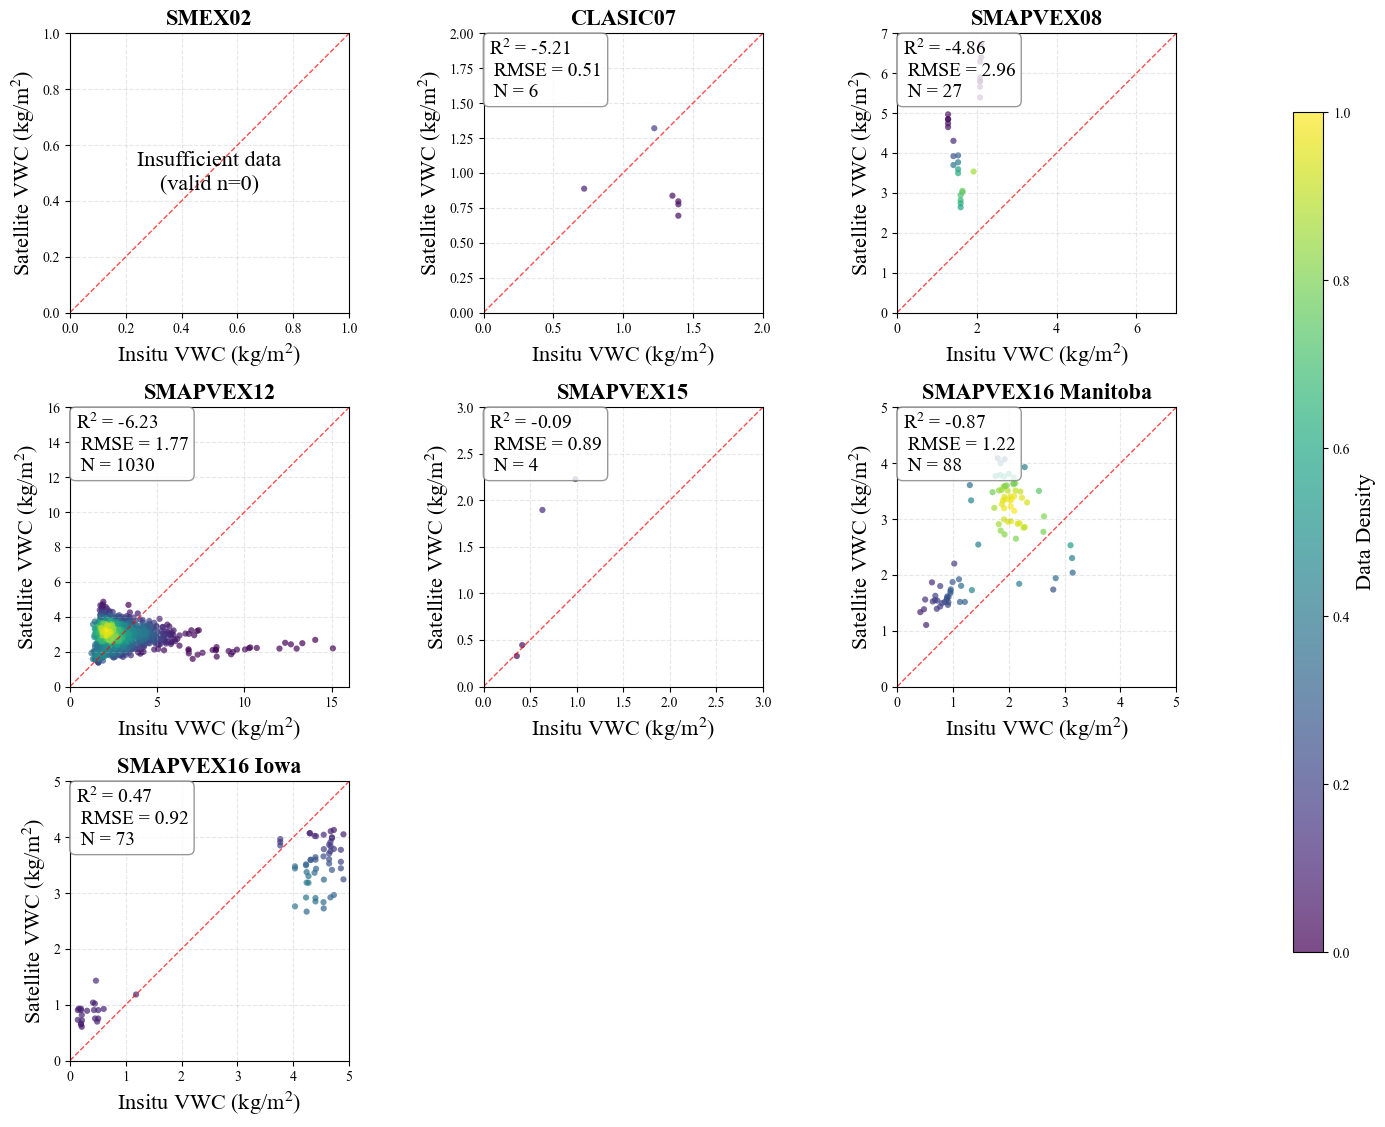

In [25]:
# save as plot_density_scatter.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import pearsonr, gaussian_kde
from math import sqrt, ceil

# 设置全局字体为新罗马
rcParams['font.family'] = 'Times New Roman'
rcParams['mathtext.fontset'] = 'stix'  # 数学字体也使用Times New Roman风格

# 读取Excel文件
file_path = r"G:\data\VWC\test-VWC\SMAP_PixelToPixel_Validation\VWC_Pre.xlsx"

# 定义要处理的工作表名称
sheet_names = ['SMEX02', 'CLASIC07', 'SMAPVEX08', 'SMAPVEX12', 'SMAPVEX15', 'SMAPVEX16 Manitoba', 'SMAPVEX16 Iowa']

# 创建一个3x3的子图布局
fig, axes = plt.subplots(3, 3, figsize=(15, 12), dpi=100)
axes = axes.flatten()  # 将3x3的axes数组展平为1维，方便遍历

# 设置全局标题
fig.suptitle('', fontsize=16, fontweight='bold')

# 定义一个函数计算RMSE
def calculate_rmse(y_true, y_pred):
    """计算均方根误差"""
    # 确保输入是numpy数组
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # 移除NaN值
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    if len(y_true) == 0:
        return np.nan
    
    mse = np.mean((y_true - y_pred) ** 2)
    return sqrt(mse)

# 用于存储每个工作表的有效数据
all_worksheet_data = []

# 遍历每个工作表，收集有效数据
for sheet_name in sheet_names:
    # 读取当前工作表
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
    except Exception as e:
        print(f"读取工作表 '{sheet_name}' 时出错: {e}")
        all_worksheet_data.append((sheet_name, np.array([]), np.array([])))
        continue
    
    # 检查必需的列
    required_columns = ['Map VWC', 'VWC_RF_AllVOD']
    missing_cols = [col for col in required_columns if col not in df.columns]
    
    if missing_cols:
        print(f"工作表 '{sheet_name}' 缺少必需的列: {missing_cols}")
        all_worksheet_data.append((sheet_name, np.array([]), np.array([])))
        continue
    
    # 提取数据
    x = df['Map VWC'].values.astype(float)  # 转换为浮点数
    y = df['VWC_RF_AllVOD'].values.astype(float)  # 转换为浮点数
    
    # 创建有效数据掩码：排除NaN和-9999
    x_valid_mask = ~(np.isnan(x) | (np.abs(x + 9999) < 1e-6))
    y_valid_mask = ~(np.isnan(y) | (np.abs(y + 9999) < 1e-6))
    valid_mask = x_valid_mask & y_valid_mask
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]
    
    # 存储数据
    all_worksheet_data.append((sheet_name, x_valid, y_valid))

# 收集所有有效数据用于统一的颜色映射
all_x_vals = []
all_y_vals = []

for sheet_name, x_valid, y_valid in all_worksheet_data:
    if len(x_valid) > 0 and len(y_valid) > 0:
        all_x_vals.extend(x_valid.tolist())
        all_y_vals.extend(y_valid.tolist())

# 计算密度估计用于颜色映射
if len(all_x_vals) > 0 and len(all_y_vals) > 0:
    all_x_vals = np.array(all_x_vals)
    all_y_vals = np.array(all_y_vals)
    
    # 使用高斯核密度估计
    xy = np.vstack([all_x_vals, all_y_vals])
    kde = gaussian_kde(xy)
    density = kde(xy)
    
    # 归一化密度
    density_norm = (density - density.min()) / (density.max() - density.min())
    
    # 计算密度值的范围用于颜色映射
    dmin, dmax = density.min(), density.max()
    print(f"全局密度范围: [{dmin:.2e}, {dmax:.2e}]")
else:
    density_norm = np.array([])
    dmin, dmax = 0, 1
    print("警告: 没有足够的数据计算密度")

# 用于存储有效的散点对象
valid_scatters = []

# 遍历每个工作表，绘制散点密度图
for idx, (sheet_name, x_valid, y_valid) in enumerate(all_worksheet_data):
    ax = axes[idx]
    
    # 计算有效样本数
    valid_count = len(x_valid)
    print(f"{sheet_name}:")
    print(f"  - 有效样本数: {valid_count}")
    
    # 计算统计指标
    if valid_count < 2:
        print(f"  - 警告: 有效样本数不足2个，无法计算统计指标")
        r_value_str = "N/A"
        r2_str = "N/A"
        rmse_str = "N/A"
    else:
        # 计算相关系数
        r_value, p_value = pearsonr(x_valid, y_valid)
        r_value_str = f"{r_value:.2f}"
        
        # 计算线性回归的决定系数 R²（不是 r²！）
        y_mean = np.mean(y_valid)
        ss_tot = np.sum((y_valid - y_mean)**2)
        ss_res = np.sum((y_valid - x_valid)**2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
        r2_str = f"{r2:.2f}"
        
        # 计算RMSE
        rmse = calculate_rmse(x_valid, y_valid)
        rmse_str = f"{rmse:.2f}"
    
    # 绘制散点图
    if valid_count >= 2:
        # 计算当前工作表的密度
        if len(all_x_vals) > 0 and len(density_norm) > 0:
            # 为当前工作表的点计算密度
            xy_current = np.vstack([x_valid, y_valid])
            density_current = kde(xy_current)
            density_current_norm = (density_current - dmin) / (dmax - dmin)
        else:
            density_current_norm = np.ones(valid_count) * 0.5
        
        # 绘制圆形散点
        scatter = ax.scatter(x_valid, y_valid, c=density_current_norm, cmap='viridis', 
                            s=20, alpha=0.7, edgecolors='none', vmin=0, vmax=1)
        valid_scatters.append(scatter)  # 保存有效的散点对象
        
        # 在左上角添加统计信息
        stats_text = f"R$^2$ = {r2_str}\n RMSE = {rmse_str}\n N = {valid_count}"
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                fontsize=14, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
        
        # 计算当前子图的数据范围
        x_min, x_max = np.min(x_valid), np.max(x_valid)
        y_min, y_max = np.min(y_valid), np.max(y_valid)
        
        # 计算绘图范围：取实测值和预测值的最大值，向上取整
        data_max = max(x_max, y_max)
        axis_max = ceil(data_max)
        axis_min = 0  # 从0开始
        
        # 如果axis_max小于1，设为1
        if axis_max < 1:
            axis_max = 1
        
        print(f"  - 子图坐标轴范围: [{axis_min}, {axis_max}]")
        
        # 绘制1:1参考线
        ax.plot([axis_min, axis_max], [axis_min, axis_max], 'r--', linewidth=1, alpha=0.7, label='1:1 line')
        
        # 设置坐标轴范围
        ax.set_xlim(axis_min, axis_max)
        ax.set_ylim(axis_min, axis_max)
        
        # 打印当前工作表的统计信息
        print(f"  - 相关系数 (R) = {r_value:.2f}, p = {p_value:.2e} ({'significant' if p_value<0.05 else 'not significant'})")
        print(f"  - 决定系数 (R$^2$): {r2_str}")
        print(f"  - 均方根误差 (RMSE): {rmse_str} kg/m²")
    else:
        # 创建空白子图
        ax.text(0.5, 0.5, f'Insufficient data\n(valid n={valid_count})', 
                ha='center', va='center', fontsize=16, transform=ax.transAxes)
        
        # 设置默认坐标轴范围
        axis_min, axis_max = 0, 1
        ax.set_xlim(axis_min, axis_max)
        ax.set_ylim(axis_min, axis_max)
        
        # 绘制1:1参考线
        ax.plot([axis_min, axis_max], [axis_min, axis_max], 'r--', linewidth=1, alpha=0.7, label='1:1 line')
    
    # 设置坐标轴标签
    ax.set_xlabel('Insitu VWC (kg/m$^2$)', fontsize=16)
    ax.set_ylabel('Satellite VWC (kg/m$^2$)', fontsize=16)
    
    # 设置子图标题
    ax.set_title(sheet_name, fontsize=16, fontweight='bold')
    
    # 添加网格
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # 确保坐标轴比例相同
    ax.set_aspect('equal', adjustable='box')
    
    print()

# === 新增 Summary 子图（第 3 行第 2 列，axes[8]） ===
summary_ax = axes[8]

if len(all_x_vals) >= 2:
    # 全数据统计量
    r_value, p_value = pearsonr(all_x_vals, all_y_vals)
    r_value_str = f"{r_value:.2f}"

    # R²（线性回归方式计算）
    y_mean = np.mean(all_y_vals)
    ss_tot = np.sum((all_y_vals - y_mean)**2)
    ss_res = np.sum((all_y_vals - all_x_vals)**2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
    r2_str = f"{r2:.2f}"

    # RMSE
    rmse = calculate_rmse(all_x_vals, all_y_vals)
    rmse_str = f"{rmse:.2f}"

    # 散点密度（使用全局 KDE）
    xy_summary = np.vstack([all_x_vals, all_y_vals])
    density_summary = kde(xy_summary)
    density_summary_norm = (density_summary - dmin) / (dmax - dmin)

    # 绘制散点
    scatter = summary_ax.scatter(
        all_x_vals, all_y_vals,
        c=density_summary_norm, cmap='viridis',
        s=20, alpha=0.7, edgecolors='none',
        vmin=0, vmax=1
    )

    # 文本框
    stats_text = f"R$^2$ = {r2_str}\n RMSE = {rmse_str}\n N = {len(all_x_vals)}"
    summary_ax.text(0.02, 0.98, stats_text,
                    transform=summary_ax.transAxes,
                    fontsize=14, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white',
                              alpha=0.8, edgecolor='gray'))

    # 坐标轴范围
    x_min, x_max = np.min(all_x_vals), np.max(all_x_vals)
    y_min, y_max = np.min(all_y_vals), np.max(all_y_vals)
    axis_max = ceil(max(x_max, y_max))
    if axis_max < 1:
        axis_max = 1

    summary_ax.plot([0, axis_max], [0, axis_max],
                    'r--', linewidth=1, alpha=0.7)

    summary_ax.set_xlim(0, axis_max)
    summary_ax.set_ylim(0, axis_max)

else:
    summary_ax.text(0.5, 0.5, 'Insufficient data',
                    ha='center', va='center', fontsize=16)

# x/y 轴名称与其他图一致
summary_ax.set_xlabel('Insitu VWC (kg/m$^2$)', fontsize=16)
summary_ax.set_ylabel('Satellite VWC (kg/m$^2$)', fontsize=16)

summary_ax.set_title("Summary", fontsize=16, fontweight='bold')
summary_ax.grid(True, linestyle='--', alpha=0.3)
summary_ax.set_aspect('equal', adjustable='box')

# === 单独保存 Summary（总图）散点密度图 ===
fig_summary, ax_summary = plt.subplots(figsize=(6, 5), dpi=300)

if len(all_x_vals) >= 2:
    # 计算散点密度（沿用全局 KDE）
    xy_summary = np.vstack([all_x_vals, all_y_vals])
    density_summary = kde(xy_summary)
    density_summary_norm = (density_summary - dmin) / (dmax - dmin)

    # 绘制散点
    scatter_summary = ax_summary.scatter(
        all_x_vals, all_y_vals,
        c=density_summary_norm, cmap='viridis',
        s=20, alpha=0.7, edgecolors='none',
        vmin=0, vmax=1
    )

    # 统计指标
    r_value, p_value = pearsonr(all_x_vals, all_y_vals)
    r2 = 1 - np.sum((all_y_vals - all_x_vals)**2) / np.sum((all_y_vals - np.mean(all_y_vals))**2)
    rmse = calculate_rmse(all_x_vals, all_y_vals)

    stats_text = f"R$^2$ = {r2:.2f}\n RMSE = {rmse:.2f}\n N = {len(all_x_vals)}"
    ax_summary.text(0.02, 0.98, stats_text,
                    transform=ax_summary.transAxes,
                    fontsize=14, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white',
                              alpha=0.8, edgecolor='gray'))

    # 坐标轴范围
    axis_max = max(np.max(all_x_vals), np.max(all_y_vals))
    axis_max = ceil(axis_max) if axis_max >= 1 else 1
    ax_summary.plot([0, axis_max], [0, axis_max],
                    'r--', linewidth=1, alpha=0.7)
    ax_summary.set_xlim(0, axis_max)
    ax_summary.set_ylim(0, axis_max)
else:
    ax_summary.text(0.5, 0.5, "Insufficient data",
                    ha='center', va='center', fontsize=16)

# 标签与标题
ax_summary.set_xlabel('Insitu VWC (kg/m$^2$)', fontsize=16)
ax_summary.set_ylabel('Satellite VWC (kg/m$^2$)', fontsize=16)
ax_summary.set_title('Summary', fontsize=18, fontweight='bold')
ax_summary.grid(True, linestyle='--', alpha=0.3)
ax_summary.set_aspect('equal', adjustable='box')

# 添加颜色条
cbar = fig_summary.colorbar(scatter_summary)
cbar.set_label('Data Density', fontsize=14)

# 保存独立 Summary 图
output_summary_path = r"G:\文章\HUITU\Fig\Pixeltopixel\VWC_Summary_ScatterDensity.png"
fig_summary.savefig(output_summary_path, dpi=300, bbox_inches='tight')
print(f"Summary 图已单独保存到: {output_summary_path}")

plt.close(fig_summary)

# 隐藏多余的空子图
for idx in range(len(sheet_names), len(axes)):
    axes[idx].set_visible(False)

# 调整子图布局
if valid_scatters:  # 如果有有效的散点对象
    plt.tight_layout(rect=[0, 0, 0.85, 0.96])  # 为全局标题和颜色条留出空间
    
    # 创建颜色条轴
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [左, 下, 宽, 高]
    cb = fig.colorbar(valid_scatters[0], cax=cbar_ax)  # 使用第一个有效的散点对象
    cb.set_label('Data Density', fontsize=16)
else:
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # 没有颜色条，使用完整宽度

# 保存图形（可选）
output_fig_path = r"G:\文章\HUITU\Fig\Pixeltopixel\VWC_Map_align_ScatterDensity.png"
plt.savefig(output_fig_path, dpi=300, bbox_inches='tight')
print(f"\n图形已保存到: {output_fig_path}")

# 显示图形
plt.show()

### 2.2 SMELR部分 (Corn2017、Oat2017、Grass2018、Flight2018)

#### 2.2.1 前置处理部分

In [ ]:
import pandas as pd
import os
from pathlib import Path

# 定义文件路径
file1_path = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\DuolunExp_Veg_ML.xlsx"
file2_path = r"G:\data\VWC\test-VWC\多频多角度地基微波辐射计及地表参量观测数据集\ZhenglanqiExp_VWC_ML.xlsx"
file3_path = r"G:\data\VWC\test-VWC\SMELR_航带样方\SMELR_HD.xlsx"
output_path = r"G:\data\VWC\test-VWC\VWC Map Validation\SMELR_VWC_results.xlsx"

# 确保输出目录存在
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 读取第一个文件的指定sheet
try:
    # 读取DuolunExp_Veg_ML.xlsx中的四个sheet
    print("正在读取 DuolunExp_Veg_ML.xlsx...")
    duolun_sheets = ['CornVegMeasured', 'CornVegFitting', 'OatVegMeasured', 'OatVegFitting']
    duolun_data = {}
    
    for sheet_name in duolun_sheets:
        try:
            df = pd.read_excel(file1_path, sheet_name=sheet_name)
            duolun_data[sheet_name] = df
            print(f"  ✓ 已读取: {sheet_name} (行数: {len(df)}, 列数: {len(df.columns)})")
        except Exception as e:
            print(f"  ✗ 读取 {sheet_name} 时出错: {e}")
    
except Exception as e:
    print(f"读取文件1时出错: {e}")
    duolun_data = {}

# 读取第二个文件的指定sheet
try:
    print("\n正在读取 ZhenglanqiExp_VWC_ML.xlsx...")
    zhenglanqi_sheets = ['GrassVWC']
    zhenglanqi_data = {}
    
    for sheet_name in zhenglanqi_sheets:
        try:
            df = pd.read_excel(file2_path, sheet_name=sheet_name)
            zhenglanqi_data[sheet_name] = df
            print(f"  ✓ 已读取: {sheet_name} (行数: {len(df)}, 列数: {len(df.columns)})")
        except Exception as e:
            print(f"  ✗ 读取 {sheet_name} 时出错: {e}")
    
except Exception as e:
    print(f"读取文件2时出错: {e}")
    zhenglanqi_data = {}

# 读取第三个文件
try:
    print("\n正在读取 SMELR_HD.xlsx...")
    if os.path.exists(file3_path):
        # 读取文件，假设只有一个sheet或者读取第一个sheet
        df = pd.read_excel(file3_path)
        # 使用指定的名称保存
        hd_data = {"Grass Flight 2018": df}
        print(f"  ✓ 已读取: SMELR_HD.xlsx (行数: {len(df)}, 列数: {len(df.columns)})")
        print(f"  → 将保存为: Grass Flight 2018")
    else:
        print(f"  ✗ 文件不存在: {file3_path}")
        hd_data = {}
except Exception as e:
    print(f"读取文件3时出错: {e}")
    hd_data = {}

# 合并所有数据
all_data = {**duolun_data, **zhenglanqi_data, **hd_data}

# 保存到目标文件
if all_data:
    try:
        print(f"\n正在保存到: {output_path}")
        
        # 使用ExcelWriter保存多个sheet
        with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
            for sheet_name, df in all_data.items():
                df.to_excel(writer, sheet_name=sheet_name, index=False)
                print(f"  ✓ 已保存: {sheet_name}")
        
        print(f"\n✅ 完成！文件已保存到: {output_path}")
        print(f"总共保存了 {len(all_data)} 个sheet:")
        for sheet_name in all_data.keys():
            print(f"  - {sheet_name}")
            
    except Exception as e:
        print(f"保存文件时出错: {e}")
else:
    print("\n⚠ 没有读取到任何数据，请检查原始文件是否存在。")